In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from tqdm.auto import tqdm

import sys
sys.path.append("../")
import json

import logging
from src.utils import logging_utils
from src.utils import env_utils
from src import functional

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.INFO,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}")
logger.info(f"{transformers.__version__=}")

/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2024-08-27 11:42:52 __main__ INFO     torch.__version__='2.3.1', torch.version.cuda='12.1'
2024-08-27 11:42:52 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=1, torch.cuda.get_device_name()='NVIDIA RTX A6000'
2024-08-27 11:42:52 __main__ INFO     transformers.__version__='4.43.3'


In [3]:
from dataclasses_json import DataClassJsonMixin
from dataclasses import dataclass, field, fields
from typing import Optional
import random
from src.dataset import BridgeSample, BridgeRelation, BridgeDataset
from src.dataset import load_bridge_relation, load_bridge_relations, load_bridge_dataset        

In [4]:
import torch

from nnsight import LanguageModel
from src.models import ModelandTokenizer

model_key = "meta-llama/Meta-Llama-3-8B-Instruct"

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.float16,
)

2024-08-27 11:42:53 accelerate.utils.modeling INFO     We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards: 100%|██████████| 4/4 [00:08<00:00,  2.01s/it]

2024-08-27 11:43:01 src.models INFO     loaded model </home/local_arnab/Codes/00_MODEL/meta-llama/Meta-Llama-3-8B-Instruct> | size: 15316.516 MB | dtype: torch.float16 | device: cuda:0


In [5]:
cached_known_dir = os.path.join(
    env_utils.DEFAULT_DATA_DIR,
    "bridge_cached",
    mt.name.split("/")[-1],
)

file_name = os.listdir(cached_known_dir)[0]

with open (os.path.join(cached_known_dir, file_name), "r") as f:
    json_data = json.load(f)

dataset = BridgeDataset.from_dict(json_data)

2024-08-27 11:43:01 src.dataset INFO     initialized bridge relation superpower_characters with 26 examples
2024-08-27 11:43:01 src.dataset INFO     initialized bridge relation sport_players with 22 examples
2024-08-27 11:43:01 src.dataset INFO     initialized bridge relation movie_actor with 51 examples
2024-08-27 11:43:01 src.dataset INFO     initialized bridge relation architect_building with 20 examples
2024-08-27 11:43:01 src.dataset INFO     initialized bridge dataset with 4 relations and 95 examples


In [85]:
from src.models import prepare_input
from src.functional import predict_next_token, predict_bridge_entity

mt.reset_forward()

s_idx = 38
# s_idx = 48
question, answer = dataset[s_idx]

print(question)
# predict_bridge_entity(mt, question)

Given two entities, find a common link between them.
#
What is a common link between Wolverine and Deadpool?
A: healing factor - an attribute that both characters Wolverine and Deadpool possess.
#
What is a common link between Kelly Slater and Andy Irons?
A: surfing - a sport where both Kelly Slater and Andy Irons are known for.
#
What is a common link between Colin Firth and King George VI?
A: The King's Speech - a movie where Colin Firth played the role of King George VI.
#
What is a common link between Fallingwater and Guggenheim Museum?
A: Frank Lloyd Wright - who was the architect of both buildings Fallingwater and Guggenheim Museum.
#
What is a common link between Michael Vaughan and Sourav Ganguly?
A:


In [86]:
mt.reset_forward()

inputs = prepare_input(
    prompts = question,
    tokenizer=mt,
    add_bos_token=False,
    return_offsets_mapping=True
)
offsets = inputs.pop("offset_mapping")[0]

top_predictios = predict_next_token(mt, inputs, k=5)[0]
base_prediction = top_predictios[0]

top_predictios

[PredictedToken(token=' captain', prob=0.14219197630882263, token_id=tensor(24862, device='cuda:0')),
 PredictedToken(token=' Cricket', prob=0.12946726381778717, token_id=tensor(59019, device='cuda:0')),
 PredictedToken(token=' England', prob=0.1197376474738121, token_id=tensor(9635, device='cuda:0')),
 PredictedToken(token=' Test', prob=0.11605370789766312, token_id=tensor(3475, device='cuda:0')),
 PredictedToken(token=' Captain', prob=0.1056680977344513, token_id=tensor(22022, device='cuda:0'))]

In [8]:
# import types
# import baukit
# from src.hooking.llama_attention import LlamaAttentionPatcher, AttentionEdge
# from tqdm.auto import tqdm

# head_ablation_results = torch.zeros(mt.n_layer, mt.config.num_attention_heads) - 1

# ablation_spec = []
# for q_idx in range(1, inputs["input_ids"].shape[1]):
#     ablation_spec.extend(
#         [AttentionEdge(q_idx, k_idx) for k_idx in range(1, q_idx + 1)]
#     )

# for layer in tqdm(range(mt.n_layer)):
#     for head in range(mt.config.num_attention_heads):
#         mt.reset_forward()

#         module_name = mt.attn_module_name_format.format(layer)
#         attn_module = baukit.get_module(
#             mt._model,
#             module_name
#         )
#         # cache_attn_matrices = {}
#         # cache_attn_contributions = {}

#         attn_module.forward = types.MethodType(
#             LlamaAttentionPatcher(
#                 # block_name=module_name,
#                 # save_attn_for=[head],
#                 # attn_matrices=cache_attn_matrices,
#                 # attn_contributions=cache_attn_contributions,
#                 cut_attn_edges={
#                     head: ablation_spec
#                 }
#             ),
#             attn_module
#         )

#         output = mt._model(**inputs)
#         logits = output.logits[:, -1, :].squeeze()
#         head_ablation_results[layer, head] = logits.softmax(dim=-1)[base_prediction.token_id].item()

In [9]:
# head_ablation_effects = (base_prediction.prob - head_ablation_results) / base_prediction.prob
# head_ablation_effects.shape

In [10]:
from scripts.locate_heads import ExperimentResults

with open(
    os.path.join(
        env_utils.DEFAULT_RESULTS_DIR, 
        "top_heads", 
        mt.name.split("/")[-1],
        "head_ablation.json"
    ), "r"
) as f:
    json_data = json.load(f)

locate_heads_results = ExperimentResults.from_dict(json_data)

In [11]:
mean_effects = torch.tensor(
    [e.effects for e in locate_heads_results.ablation_effects]
).mean(dim=0)

mean_effects.shape

torch.Size([32, 32])

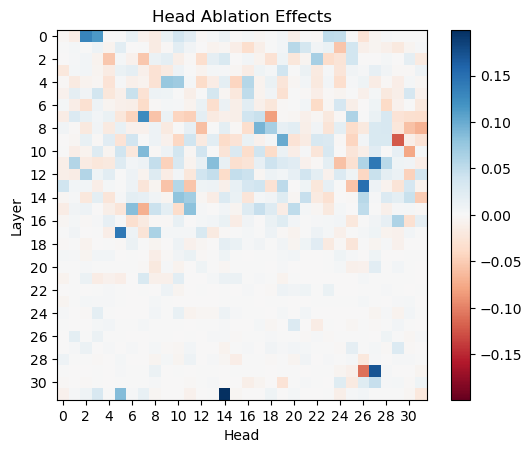

In [12]:
from src.plotting import matrix_heatmap

matrix_heatmap(
    matrix = mean_effects,
    x_label="Head",
    y_label="Layer",
    tick_gap=2,
    title="Head Ablation Effects",
)

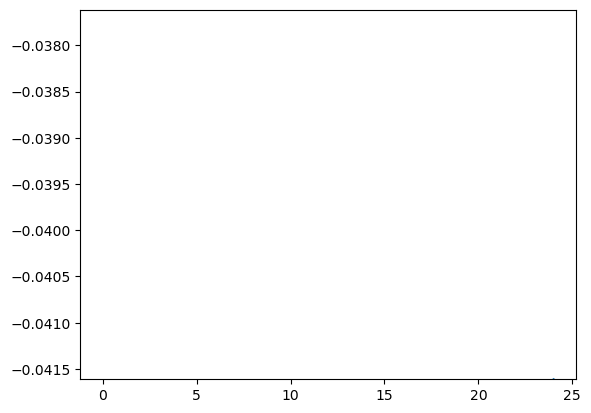

In [93]:
from scripts.locate_heads import HeadAblationEffect

topk = (-mean_effects).reshape(
    mean_effects.shape[0] * mean_effects.shape[1]
).topk(
    # mean_effects.shape[0] * mean_effects.shape[1]
    25
)
indices = [
    (
        i.item() // mean_effects.shape[1],
        i.item() % mean_effects.shape[1],
    ) for i in topk.indices
]

top_effects = [
    HeadAblationEffect(
        layer=i,
        head=j,
        effect=mean_effects[i, j].item()
    ) for i, j in indices
]

import matplotlib.pyplot as plt

plt.plot(
    [e.effect for e in top_effects],
    # marker="o"
)
plt.ylim(bottom=min(0, top_effects[-1].effect))
plt.show()

In [94]:
indices

[(9, 29),
 (29, 26),
 (7, 18),
 (10, 30),
 (15, 7),
 (8, 31),
 (8, 12),
 (8, 30),
 (11, 24),
 (7, 8),
 (13, 9),
 (13, 25),
 (1, 24),
 (13, 11),
 (2, 7),
 (2, 4),
 (14, 31),
 (7, 11),
 (11, 9),
 (12, 30),
 (7, 6),
 (4, 15),
 (9, 25),
 (7, 10),
 (9, 10)]

In [68]:
from src.utils.typing import TokenizerOutput
from src.hooking.llama_attention import AttentionEdge, LlamaAttentionPatcher
import baukit
import types
import numpy as np
from src.functional import get_module_nnsight

@torch.inference_mode()
def cache_ablated_head_outputs(
    mt: ModelandTokenizer,
    inputs: TokenizerOutput,
    heads: dict[int, list[int]],  # {layer: [head]}
    save_path: str,
) -> torch.Tensor:

    mt.reset_forward()

    # q can only attend to <bos>. cut all other edges.
    ablation_spec: list[AttentionEdge] = []
    for q_idx in range(1, inputs["input_ids"].shape[1]):
        ablation_spec.extend(
            [AttentionEdge(q_idx, k_idx) for k_idx in range(1, q_idx + 1)]
        )

    save_path = os.path.join(env_utils.DEFAULT_RESULTS_DIR, save_path)
    os.makedirs(save_path, exist_ok=True)

    all_head_contributions: dict[str, dict[int, torch.Tensor]] = {}
    for l in heads:
        module_name = mt.attn_module_name_format.format(l)
        all_head_contributions[module_name] = {}
        attn_module = baukit.get_module(mt._model, module_name)
        attn_module.forward = types.MethodType(
            LlamaAttentionPatcher(
                cut_attn_edges={h: ablation_spec for h in heads[l]},
                save_attn_for=heads[l],
                attn_contributions=all_head_contributions[module_name],
            ),
            attn_module,
        )
    
    o_proj_inputs: dict[str, dict[int, torch.Tensor]] = {}
    head_dim = mt.n_embd // mt.model.config.num_attention_heads
    with mt.trace(inputs, scan = False) as tracer:
        for l in heads:
            attn_module_name = mt.attn_module_name_format.format(l)
            o_proj_inputs[attn_module_name] = {}
            o_proj_name = attn_module_name + ".o_proj"
            o_proj = get_module_nnsight(mt, o_proj_name)
            
            for h in heads[l]:
                o_proj_inputs[attn_module_name][h] = o_proj.input[0][0][
                    :, :, h * head_dim : (h + 1) * head_dim
                ].save()
        
        output = mt.output.save()

    mt.reset_forward()

    for l in heads:
        module_name = mt.attn_module_name_format.format(l)
        for h in heads[l]:
            all_head_contributions[module_name][h] = all_head_contributions[module_name][h].mean(dim=1).cpu().numpy().astype(np.float32)
            o_proj_inputs[module_name][h] = o_proj_inputs[module_name][h].mean(dim=1).cpu().numpy().astype(np.float32)
    
    np.savez_compressed(
        os.path.join(save_path, "ablated_head_outputs.npz"),
        allow_pickle=True,
        **all_head_contributions,
    )
    np.savez_compressed(
        os.path.join(save_path, "o_proj_inputs.npz"),
        allow_pickle=True,
        **o_proj_inputs,
    )
    
    return output.logits[:, -1, :].squeeze()


all_heads = {}
for l in range(mt.n_layer):
    all_heads[l] = list(range(mt.config.num_attention_heads))

cache_ablated_head_outputs(
    mt = mt,
    inputs = inputs,
    heads = all_heads,
    save_path = "cache_heads/demo"
)

tensor([ 7.9766,  9.6562, 11.6719,  ..., -4.1875, -4.1875, -4.1875],
       device='cuda:0')

In [69]:
npz_file = np.load(
    os.path.join(env_utils.DEFAULT_RESULTS_DIR, "cache_heads/demo/o_proj_inputs.npz"),
    allow_pickle=True,
)
npz_file.files

['allow_pickle',
 'model.layers.0.self_attn',
 'model.layers.1.self_attn',
 'model.layers.2.self_attn',
 'model.layers.3.self_attn',
 'model.layers.4.self_attn',
 'model.layers.5.self_attn',
 'model.layers.6.self_attn',
 'model.layers.7.self_attn',
 'model.layers.8.self_attn',
 'model.layers.9.self_attn',
 'model.layers.10.self_attn',
 'model.layers.11.self_attn',
 'model.layers.12.self_attn',
 'model.layers.13.self_attn',
 'model.layers.14.self_attn',
 'model.layers.15.self_attn',
 'model.layers.16.self_attn',
 'model.layers.17.self_attn',
 'model.layers.18.self_attn',
 'model.layers.19.self_attn',
 'model.layers.20.self_attn',
 'model.layers.21.self_attn',
 'model.layers.22.self_attn',
 'model.layers.23.self_attn',
 'model.layers.24.self_attn',
 'model.layers.25.self_attn',
 'model.layers.26.self_attn',
 'model.layers.27.self_attn',
 'model.layers.28.self_attn',
 'model.layers.29.self_attn',
 'model.layers.30.self_attn',
 'model.layers.31.self_attn']

In [71]:
# inp_5_6 = torch.Tensor(npz_file["model.layers.5.self_attn"].item()[6])

# # torch.allclose(inp_5_6.mean(dim=1), inp_5_6[:, 0])
# inp_5_6.shape

In [88]:
cached_o_proj: dict[str, dict[int, torch.Tensor]] = {}

for l in npz_file.files:
    if l == "allow_pickle":
        continue
    cached_o_proj[l] = {}
    for h in npz_file[l].item():
        cached_o_proj[l][h] = torch.Tensor(npz_file[l].item()[h])

In [89]:
def ablate_heads_with_cached_oproj_inps(
    mt: ModelandTokenizer,
    inputs: TokenizerOutput,
    heads: dict[int, list[int]],  # {layer: [head]}
    o_proj_inputs: dict[str, dict[int, np.ndarray | torch.Tensor]],
) -> torch.Tensor:
    
    head_dim = mt.n_embd // mt.model.config.num_attention_heads
    with mt.trace(inputs, scan = False) as tracer:
        for l in heads:
            attn_module_name = mt.attn_module_name_format.format(l)
            o_proj_name = attn_module_name + ".o_proj"
            o_proj = get_module_nnsight(mt, o_proj_name)
            
            for h in heads[l]:
                ablated_input = torch.Tensor(o_proj_inputs[attn_module_name][h]).to(mt.device)
                o_proj.input[0][0][
                    :, :, h * head_dim : (h + 1) * head_dim
                ] = ablated_input
        
        output = mt.output.save()
    
    return output.logits[:, -1, :].squeeze()

# ablated_logits_inp = ablate_heads_with_cached_oproj_inps(
#     mt = mt,
#     inputs = inputs,
#     heads = all_heads,
#     o_proj_inputs = cached_o_proj,
# )

# interpret_logits(
#     tokenizer = mt, logits = ablated_logits_inp,
#     k = 5, get_proba = True
# )

In [97]:
from scripts.locate_heads import get_ablation_effect_of_heads
from src.hooking.llama_attention import AttentionEdge
from src.functional import interpret_logits


# q can only attend to <bos>. cut all other edges.
ablation_spec: list[AttentionEdge] = []
for q_idx in range(1, inputs["input_ids"].shape[1]):
    ablation_spec.extend(
        [AttentionEdge(q_idx, k_idx) for k_idx in range(1, q_idx + 1)]
    )


important_heads = {}
for e in top_effects:
    if e.layer not in important_heads:
        important_heads[e.layer] = []
    important_heads[e.layer].append(e.head)

# unimportant_heads = {}
# for layer in range(mt.n_layer):
#     if layer not in unimportant_heads:
#         unimportant_heads[layer] = []
#     for head in range(mt.config.num_attention_heads):
#         if head not in important_heads.get(layer, []):
#             unimportant_heads[layer].append(head)    


# ablated_logits = get_ablation_effect_of_heads(
#     mt, inputs, 
#     # heads = {},
#     # heads=all_heads,
#     heads=important_heads,
#     # heads=unimportant_heads,
#     ablation_spec=ablation_spec
# )


# interpret_logits(
#     tokenizer = mt, logits = ablated_logits,
#     k = 5, get_proba = True
# )

In [98]:
ablated_logits_inp = ablate_heads_with_cached_oproj_inps(
    mt = mt,
    inputs = inputs,
    heads = important_heads,
    o_proj_inputs = cached_o_proj,
)

interpret_logits(
    tokenizer = mt, logits = ablated_logits_inp,
    k = 5, get_proba = True
)

[(' Test', 0.247),
 (' Cricket', 0.132),
 (' Ash', 0.124),
 (' cricket', 0.108),
 (' England', 0.103)]

In [80]:
# #! even though the ablation effects are different, the predictions are the same.
# torch.allclose(ablated_logits, ablated_logits_inp)

False

In [ ]:
import baukit
import types
from src.hooking.llama_attention import LlamaAttentionPatcher

mt.reset_forward()

important_heads = {}
for e in top_effects:
    if e.layer not in important_heads:
        important_heads[e.layer] = []
    important_heads[e.layer].append(e.head)


cache_attn_matrices = {}
cache_attn_contributions = {}

for l in important_heads:

    print(l, " => ", important_heads[l])

    module_name = mt.attn_module_name_format.format(l)
    attn_module = baukit.get_module(
        mt._model,
        module_name
    )

    layer_attn_matrices = {}
    layer_attn_contributions = {}

    attn_module.forward = types.MethodType(
        LlamaAttentionPatcher(
            block_name=module_name,
            save_attn_for=important_heads[l],
            attn_matrices=layer_attn_matrices,
            attn_contributions=layer_attn_contributions,
        ),
        attn_module
    )
    cache_attn_matrices[l] = layer_attn_matrices
    cache_attn_contributions[l] = layer_attn_contributions


output = mt._model(**inputs)
logits = output.logits[:, -1, :].squeeze()

interpret_logits(
    tokenizer = mt, logits = logits,
    k = 5, get_proba = True
)

31  =>  [14, 5]
29  =>  [27]
13  =>  [26]
11  =>  [27, 13, 26]
17  =>  [5, 8]
0  =>  [2, 3]
7  =>  [7, 25]
9  =>  [19]
8  =>  [17, 18]
10  =>  [7]
15  =>  [6, 11]
14  =>  [10, 11]
4  =>  [9, 10]
2  =>  [22]
16  =>  [29]
2024-08-01 18:31:02 src.hooking.llama_attention WARNING  torch.allclose(attn_output, __attn_output, atol=1e-3)=True | attn_output.norm().item()=6.62890625, __attn_output.norm().item()=6.62890625
2024-08-01 18:31:02 src.hooking.llama_attention WARNING  torch.allclose(attn_output, __attn_output, atol=1e-3)=True | attn_output.norm().item()=8.1875, __attn_output.norm().item()=8.1875
2024-08-01 18:31:02 src.hooking.llama_attention WARNING  torch.allclose(attn_output, __attn_output, atol=1e-3)=True | attn_output.norm().item()=14.546875, __attn_output.norm().item()=14.546875
2024-08-01 18:31:02 src.hooking.llama_attention WARNING  torch.allclose(attn_output, __attn_output, atol=1e-3)=True | attn_output.norm().item()=24.640625, __attn_output.norm().item()=24.640625
2024-08-01 1

[(' captain', 0.143),
 (' Cricket', 0.13),
 (' England', 0.118),
 (' Test', 0.117),
 (' Captain', 0.105)]

In [ ]:
from src.functional import find_token_range

st, nd = find_token_range(
    string = question,
    substring = "#",
    tokenizer=mt.tokenizer,
    occurrence=-1,
    offset_mapping=offsets
)

for idx in range(st, nd):
    print(f"{idx=}, {mt.tokenizer.decode(inputs['input_ids'][0, idx].item())=}")

idx=141, mt.tokenizer.decode(inputs['input_ids'][0, idx].item())='.\n'
idx=142, mt.tokenizer.decode(inputs['input_ids'][0, idx].item())='#\n'


In [ ]:
import wikipedia
import yake
kw_extractor = yake.KeywordExtractor(lan="en", n=1, dedupLim=0.9, windowsSize=1, top=50)

def get_key_words(entity):
    if entity not in wikipedia.search(entity):
        raise ValueError(f"{entity} is not found in wikipedia")
    page = wikipedia.page(entity)
    text = page.content
    keywords = kw_extractor.extract_keywords(text)
    return list(set([k[0] for k in keywords]))

entities = dataset.examples[s_idx].entity_pair

related_words = []
for entity in entities:
    keywords = get_key_words(entity)
    related_words.extend(keywords)

related_words = list(set(related_words))

In [ ]:
from src.functional import is_nontrivial_prefix

def calculate_attribute_rate(predictions, keywords):
    count = 0
    for t, proba in predictions:
        if len(t.strip()) < 3:
            continue
        for k in keywords:
            if is_nontrivial_prefix(prediction=t, target = k):
                # print(f"{t=}, {k=}, {proba=}")
                count += 1
                break
    return count / len(predictions)

# top_predictions = logit_lens(mt = mt, h = h, get_proba=True, k=50)
# calculate_attribute_rate(top_predictions, related_words)

In [ ]:
def plot_attribution_rates(contributions):
    attribute_rates = [
        calculate_attribute_rate(
            logit_lens(mt = mt, h = h, get_proba=True, k=50),
            related_words
        ) for h in contributions[nd:]
    ]

    with plt.rc_context(
        rc={
            "font.family": "Times New Roman",
            # "font.size": 3,
        }
    ):  
        plt.figure(figsize=(6, 2))
        # plt.plot(attribute_rates, linewidth=0.5)
        plt.bar(
            x = range(len(attribute_rates)), 
            height = attribute_rates
        )
        plt.ylim(bottom=0, top = 0.2)
        plt.xticks(
            range(len(attribute_rates)),
            [mt.tokenizer.decode(t) for t in inputs["input_ids"][0][nd:]],
            rotation=90
        )

        plt.show()

Layer 31, Head 14


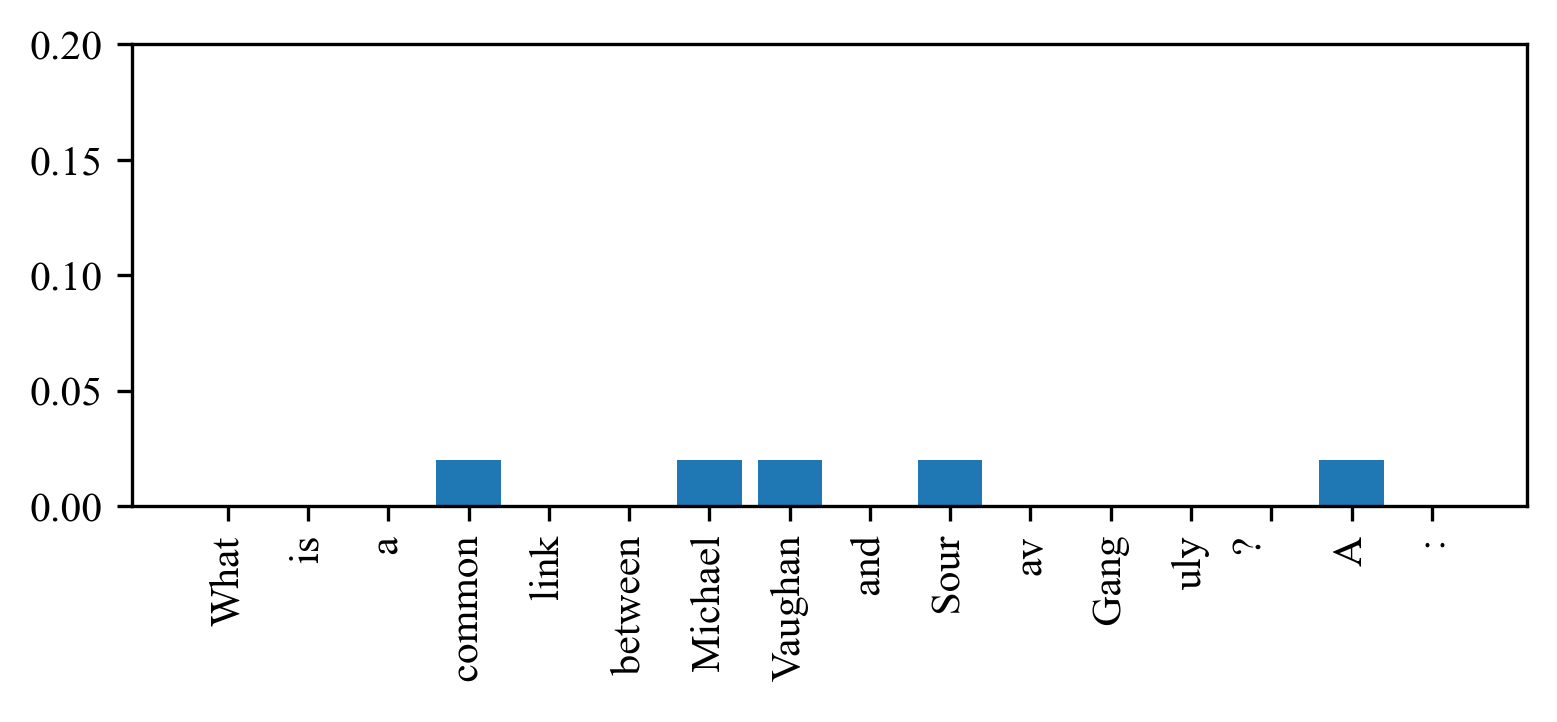

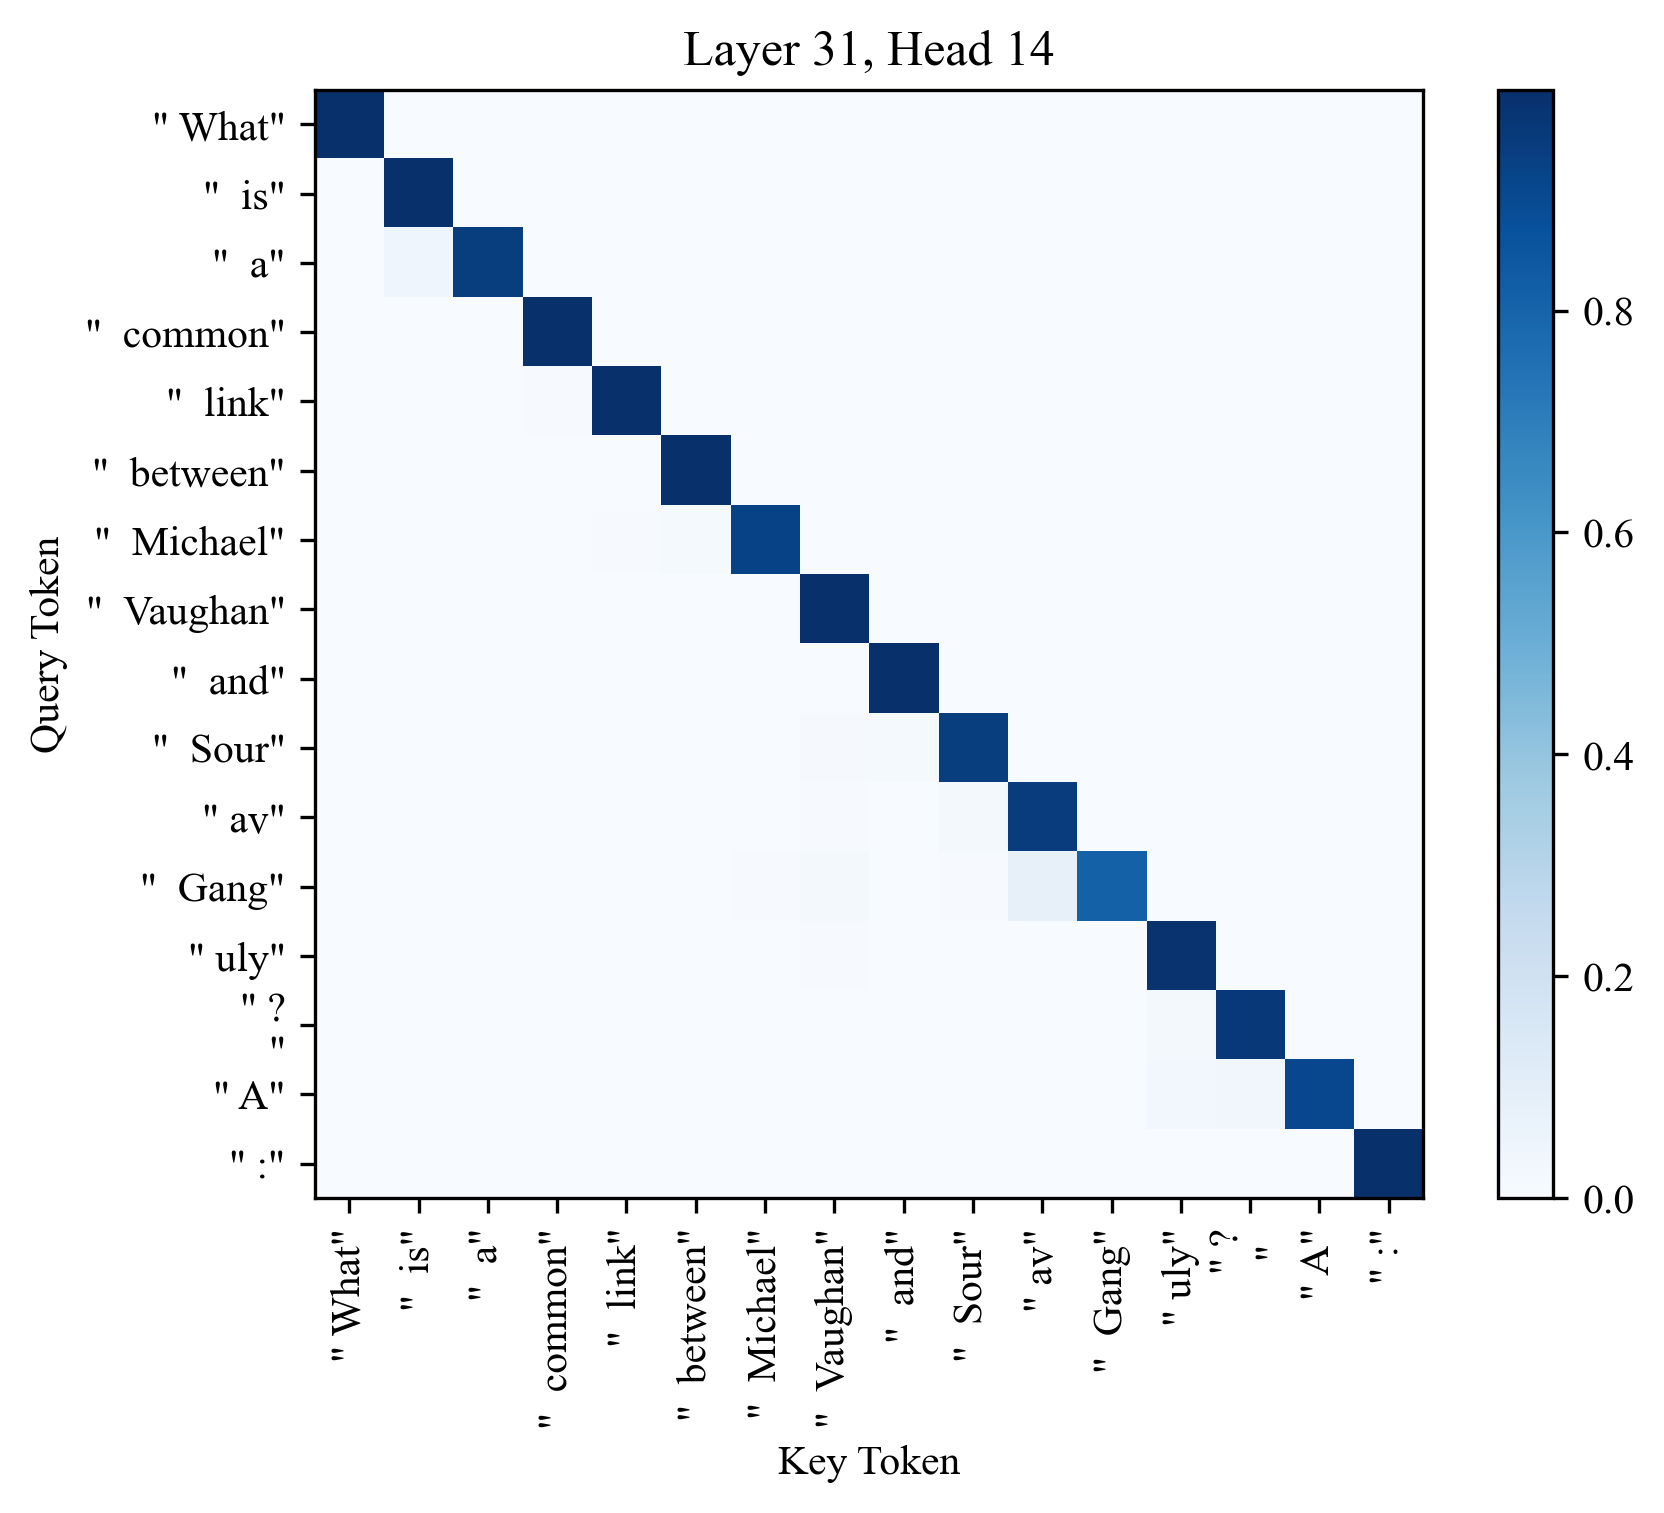

Layer 31, Head 5


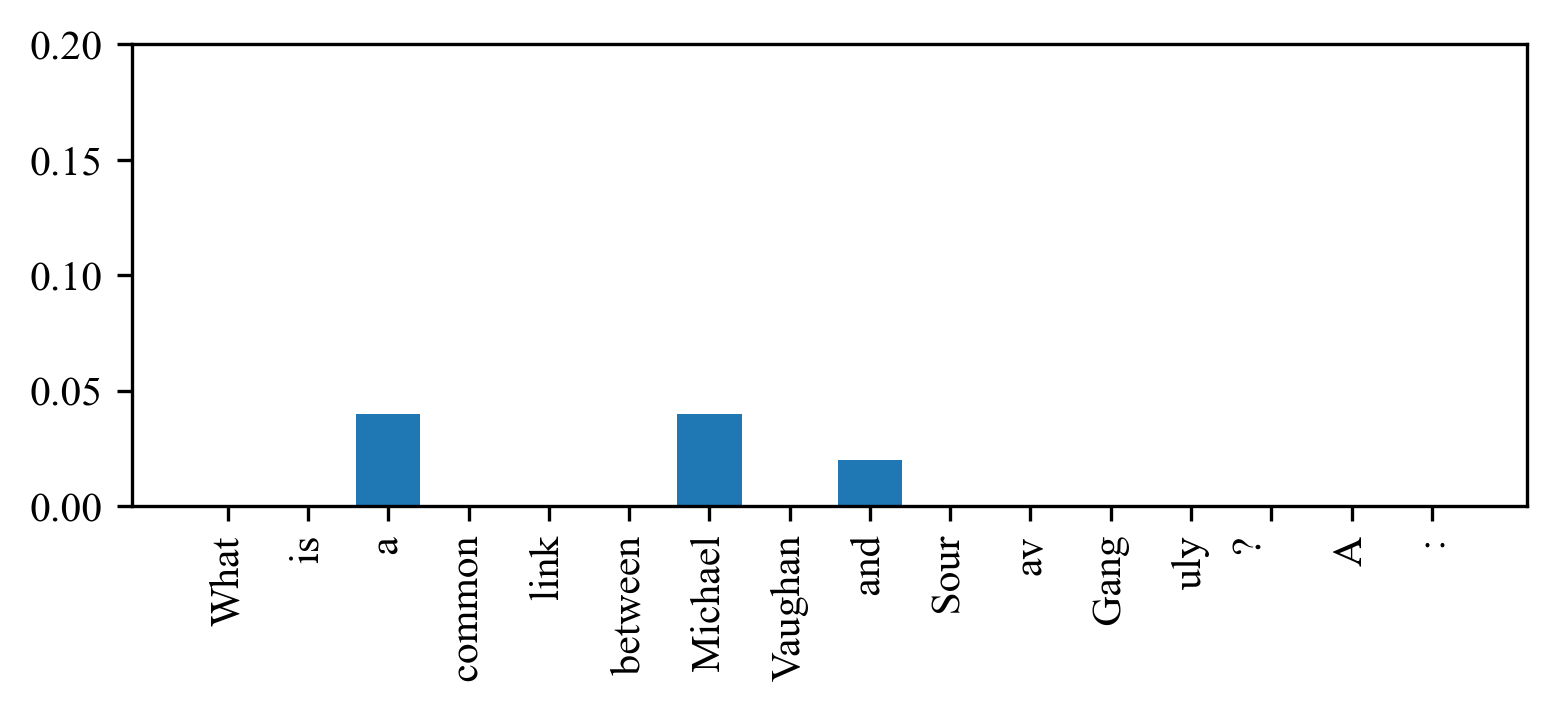

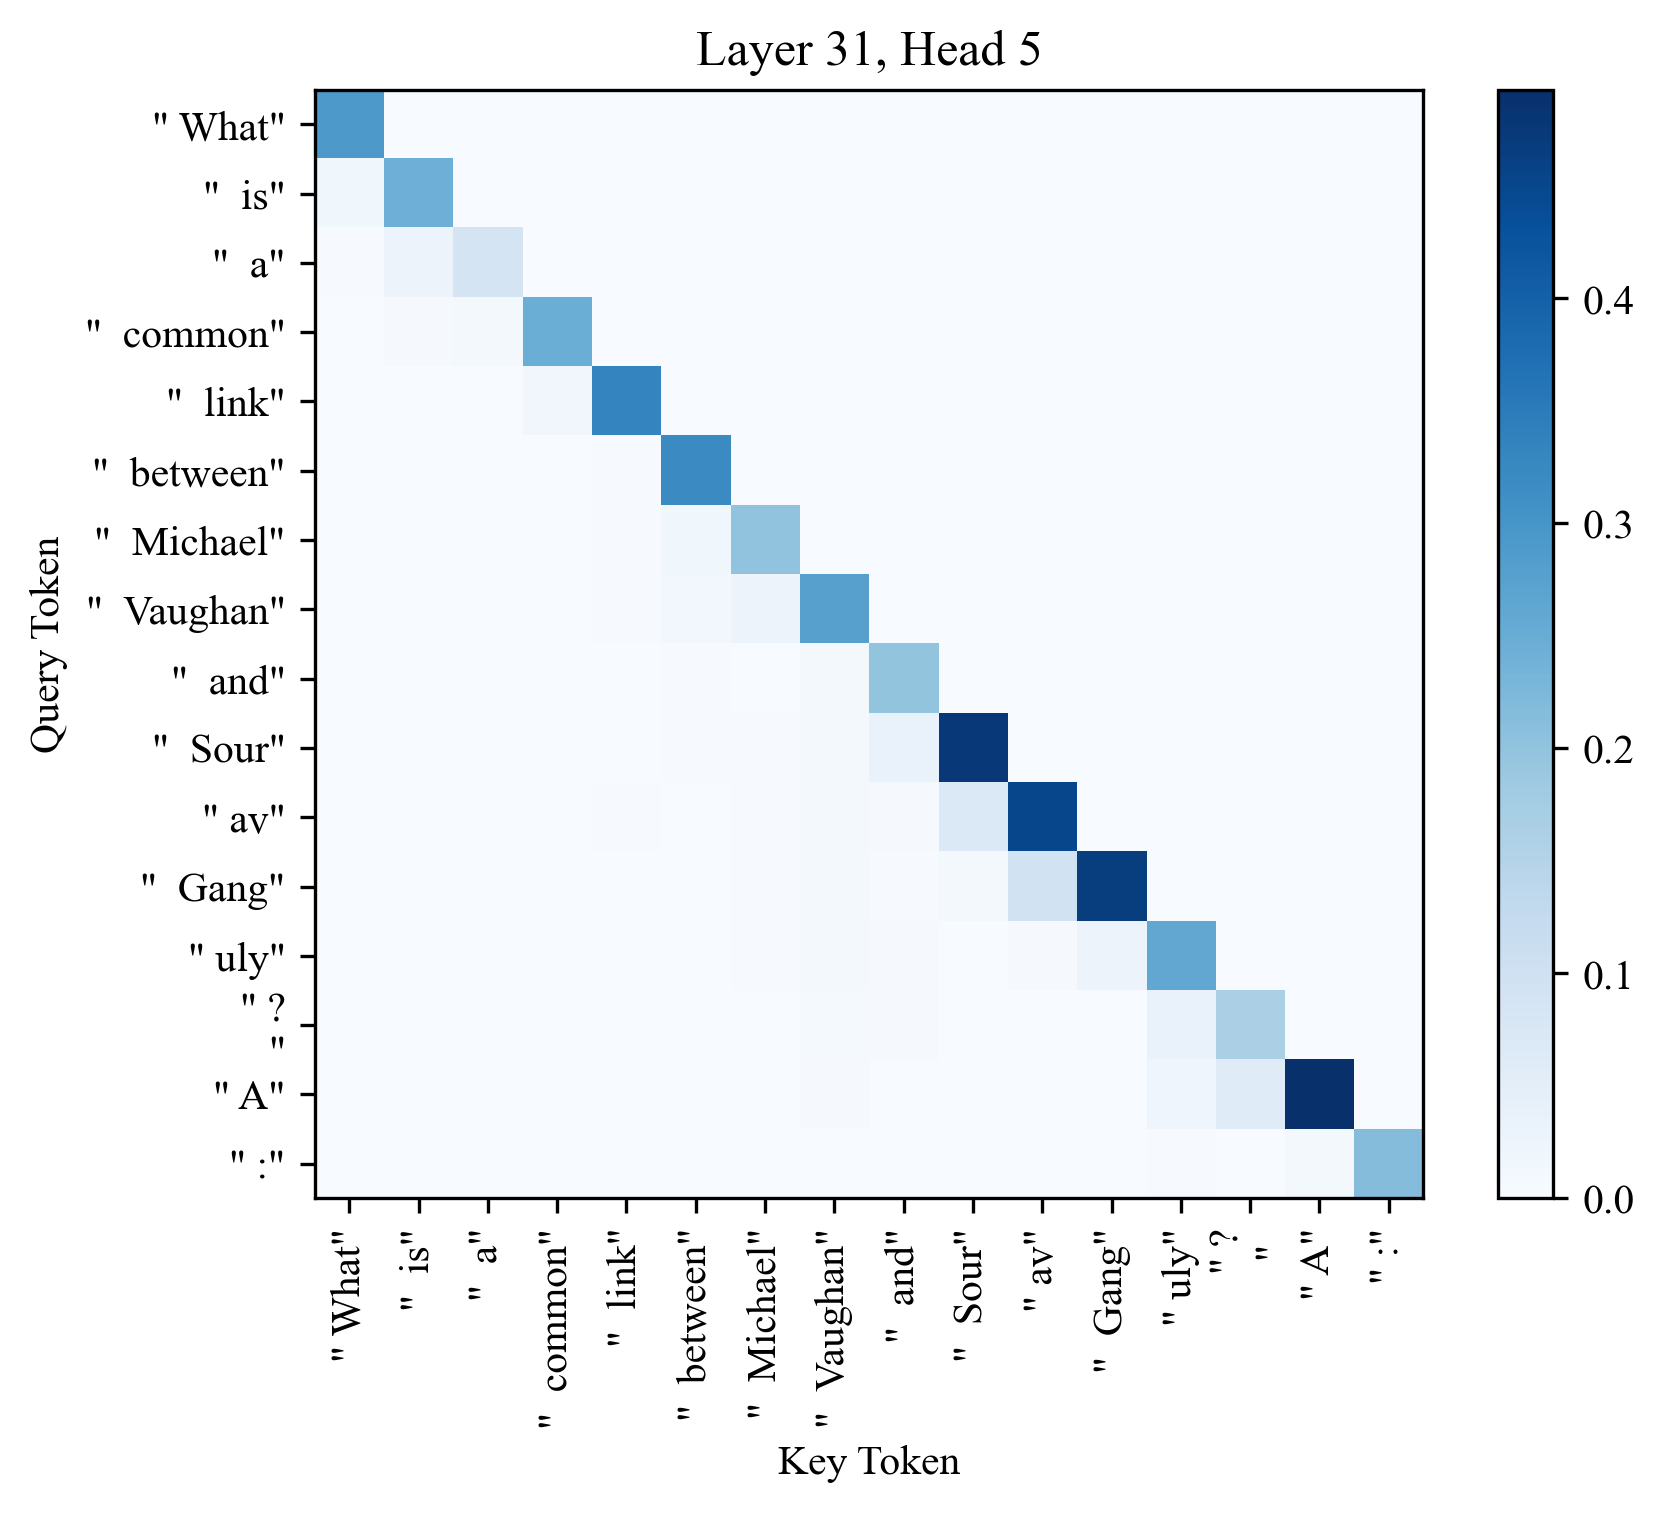

Layer 29, Head 27


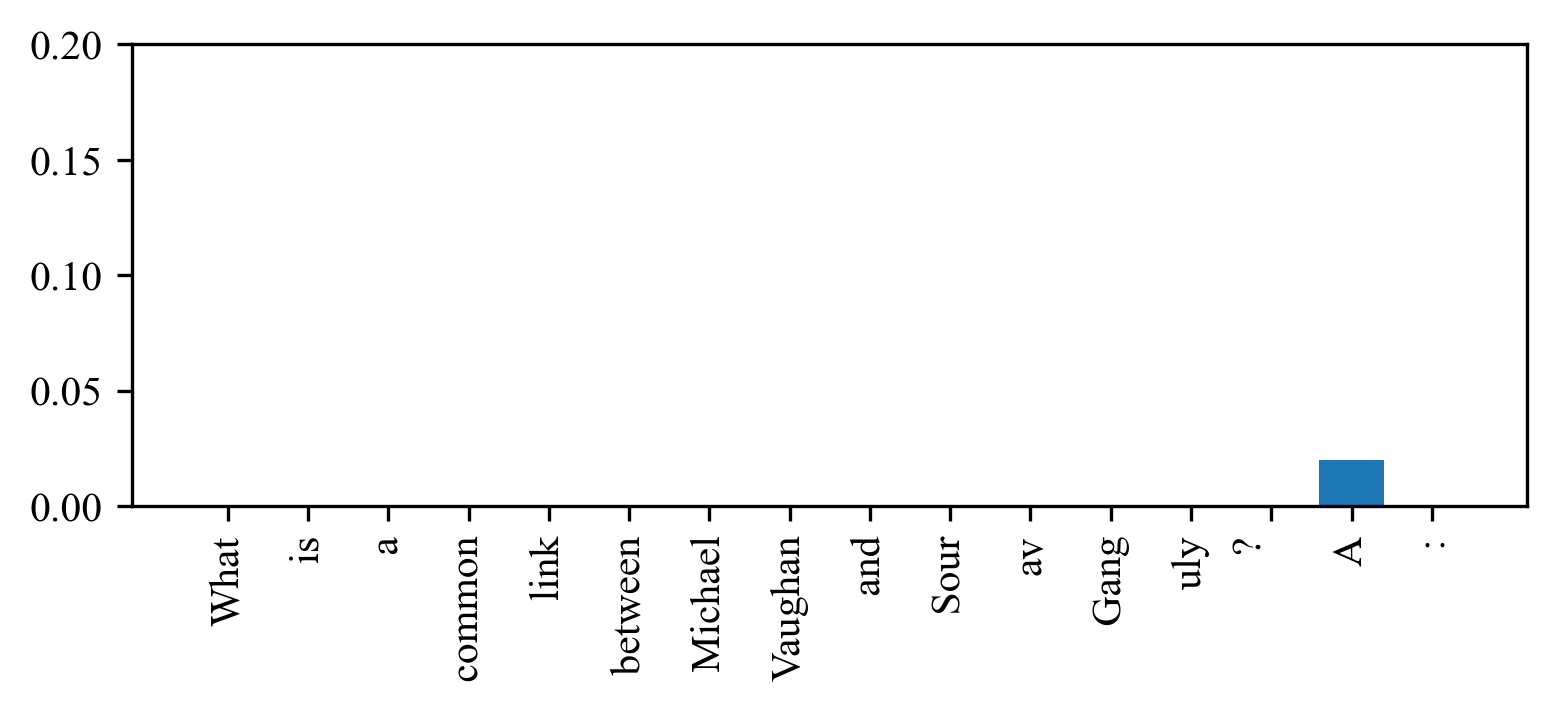

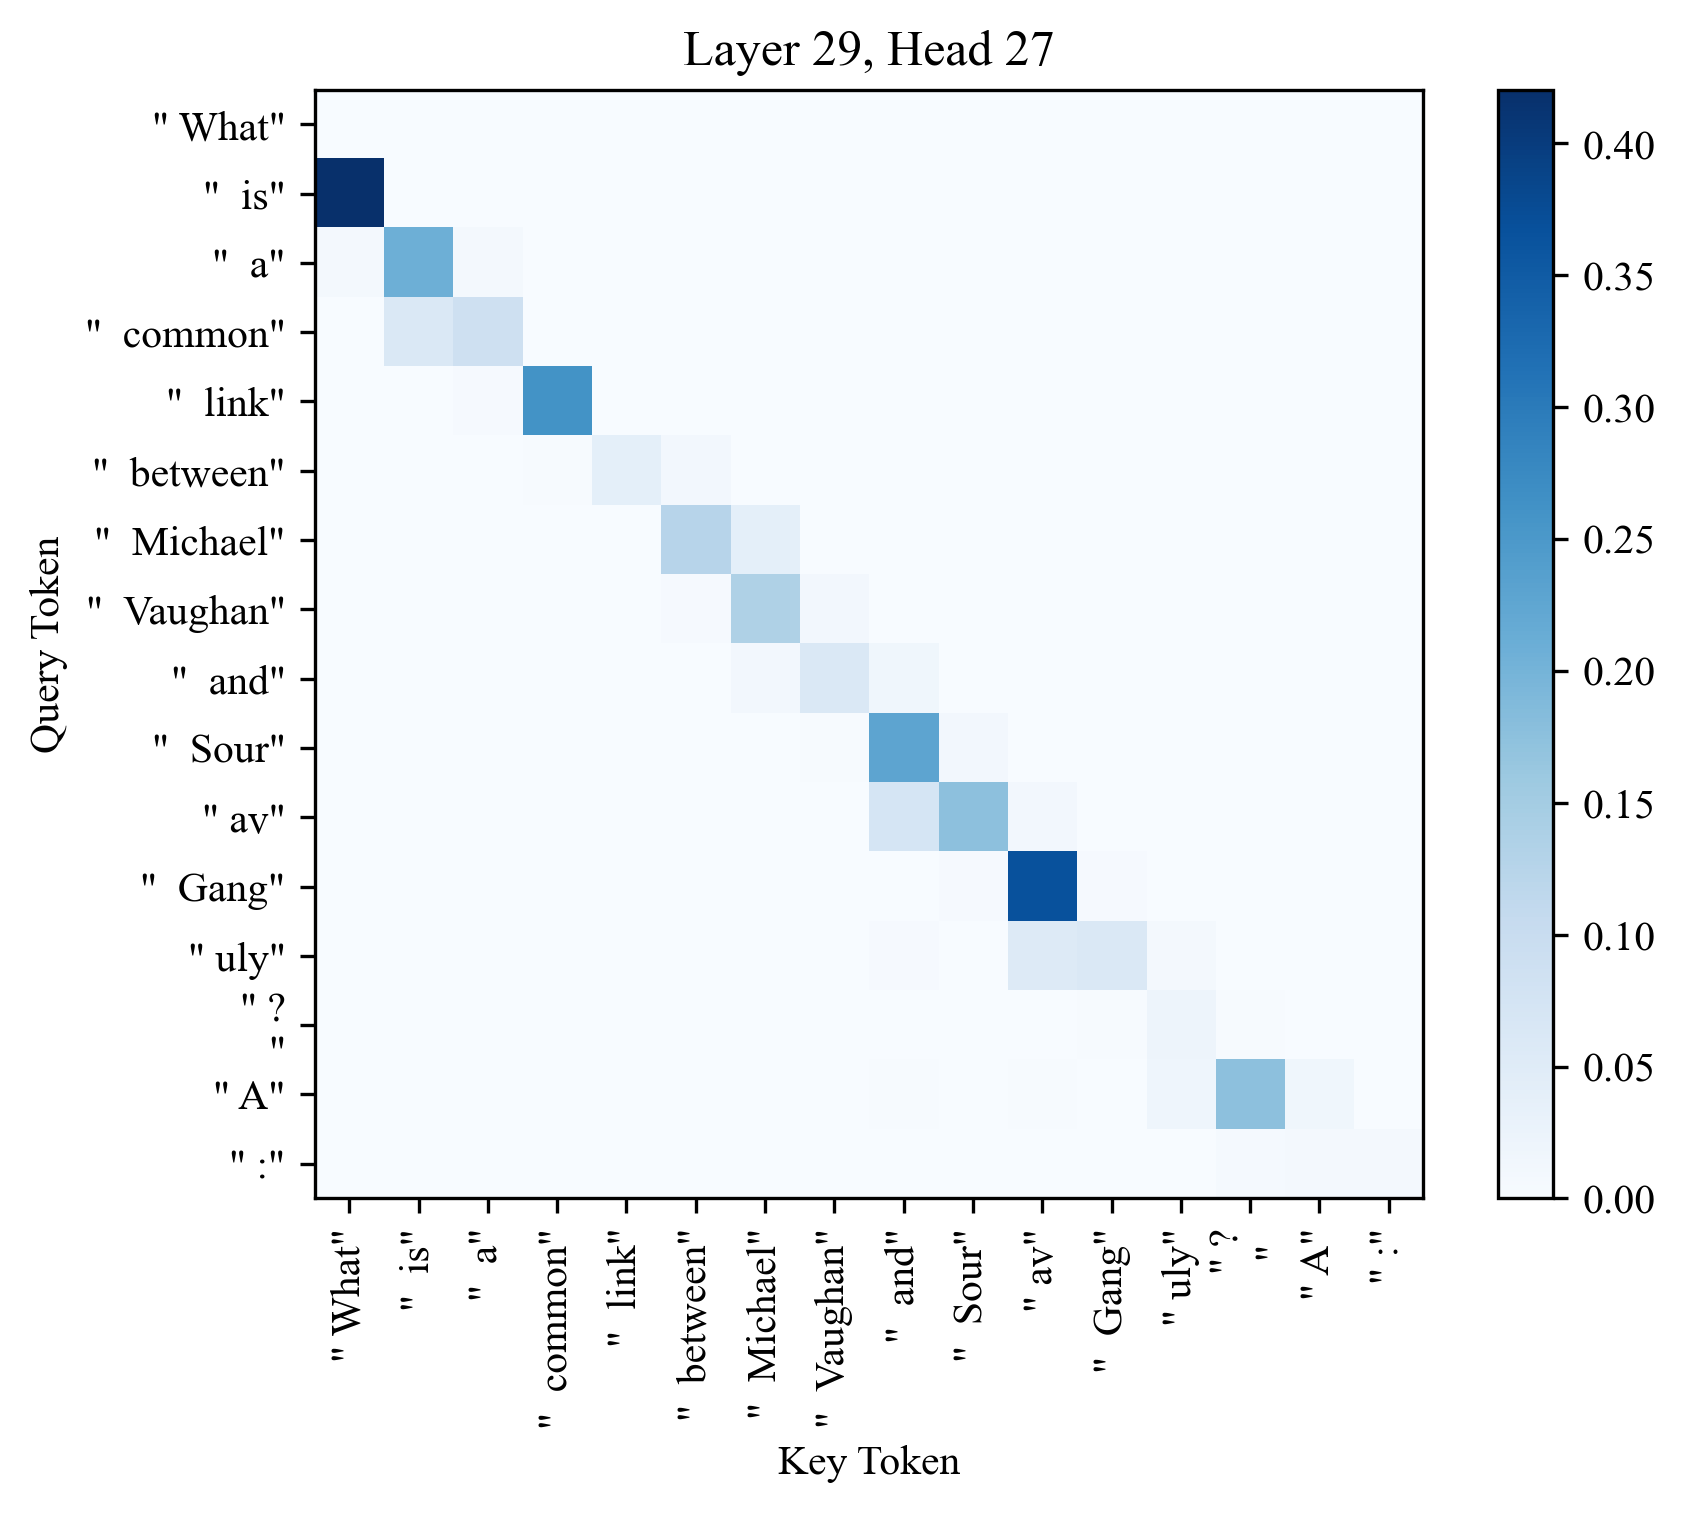

Layer 13, Head 26


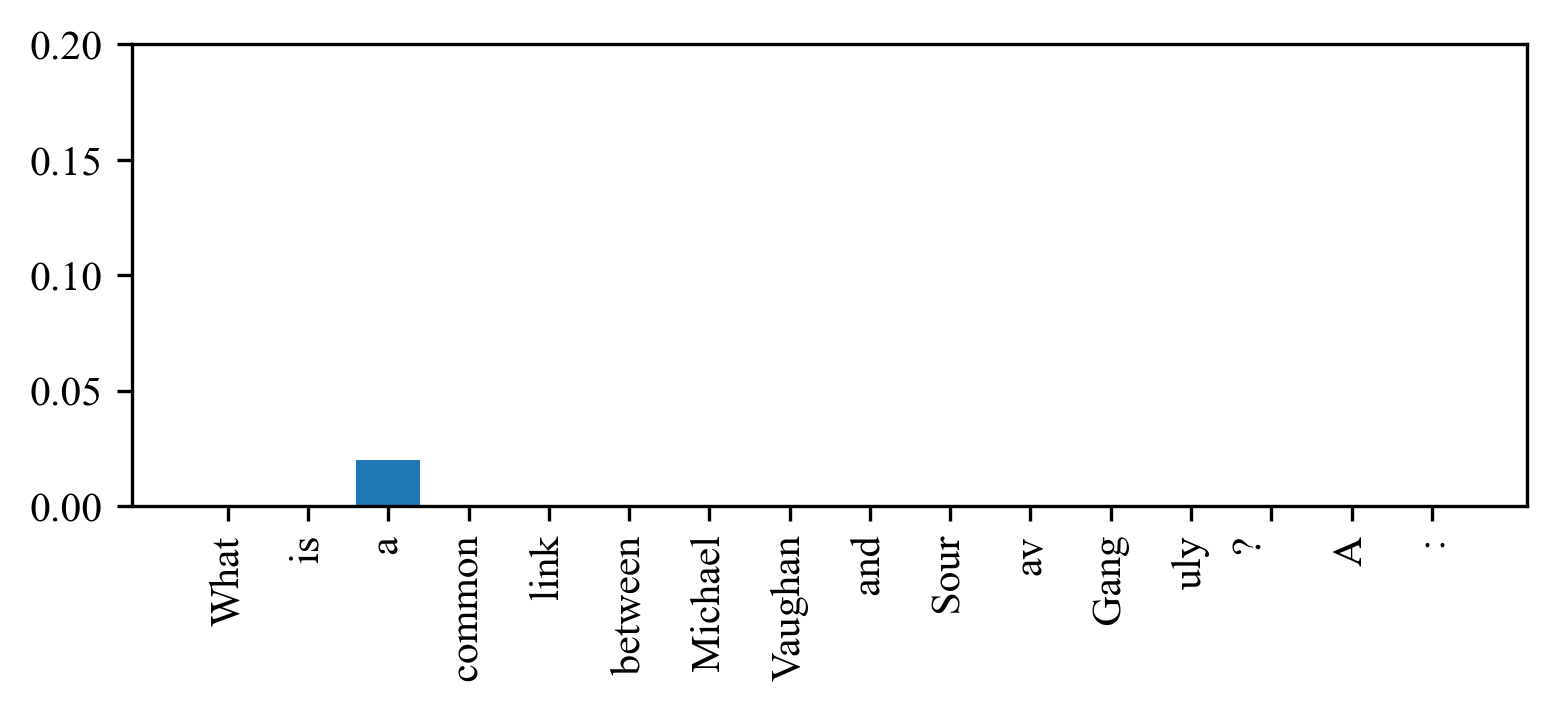

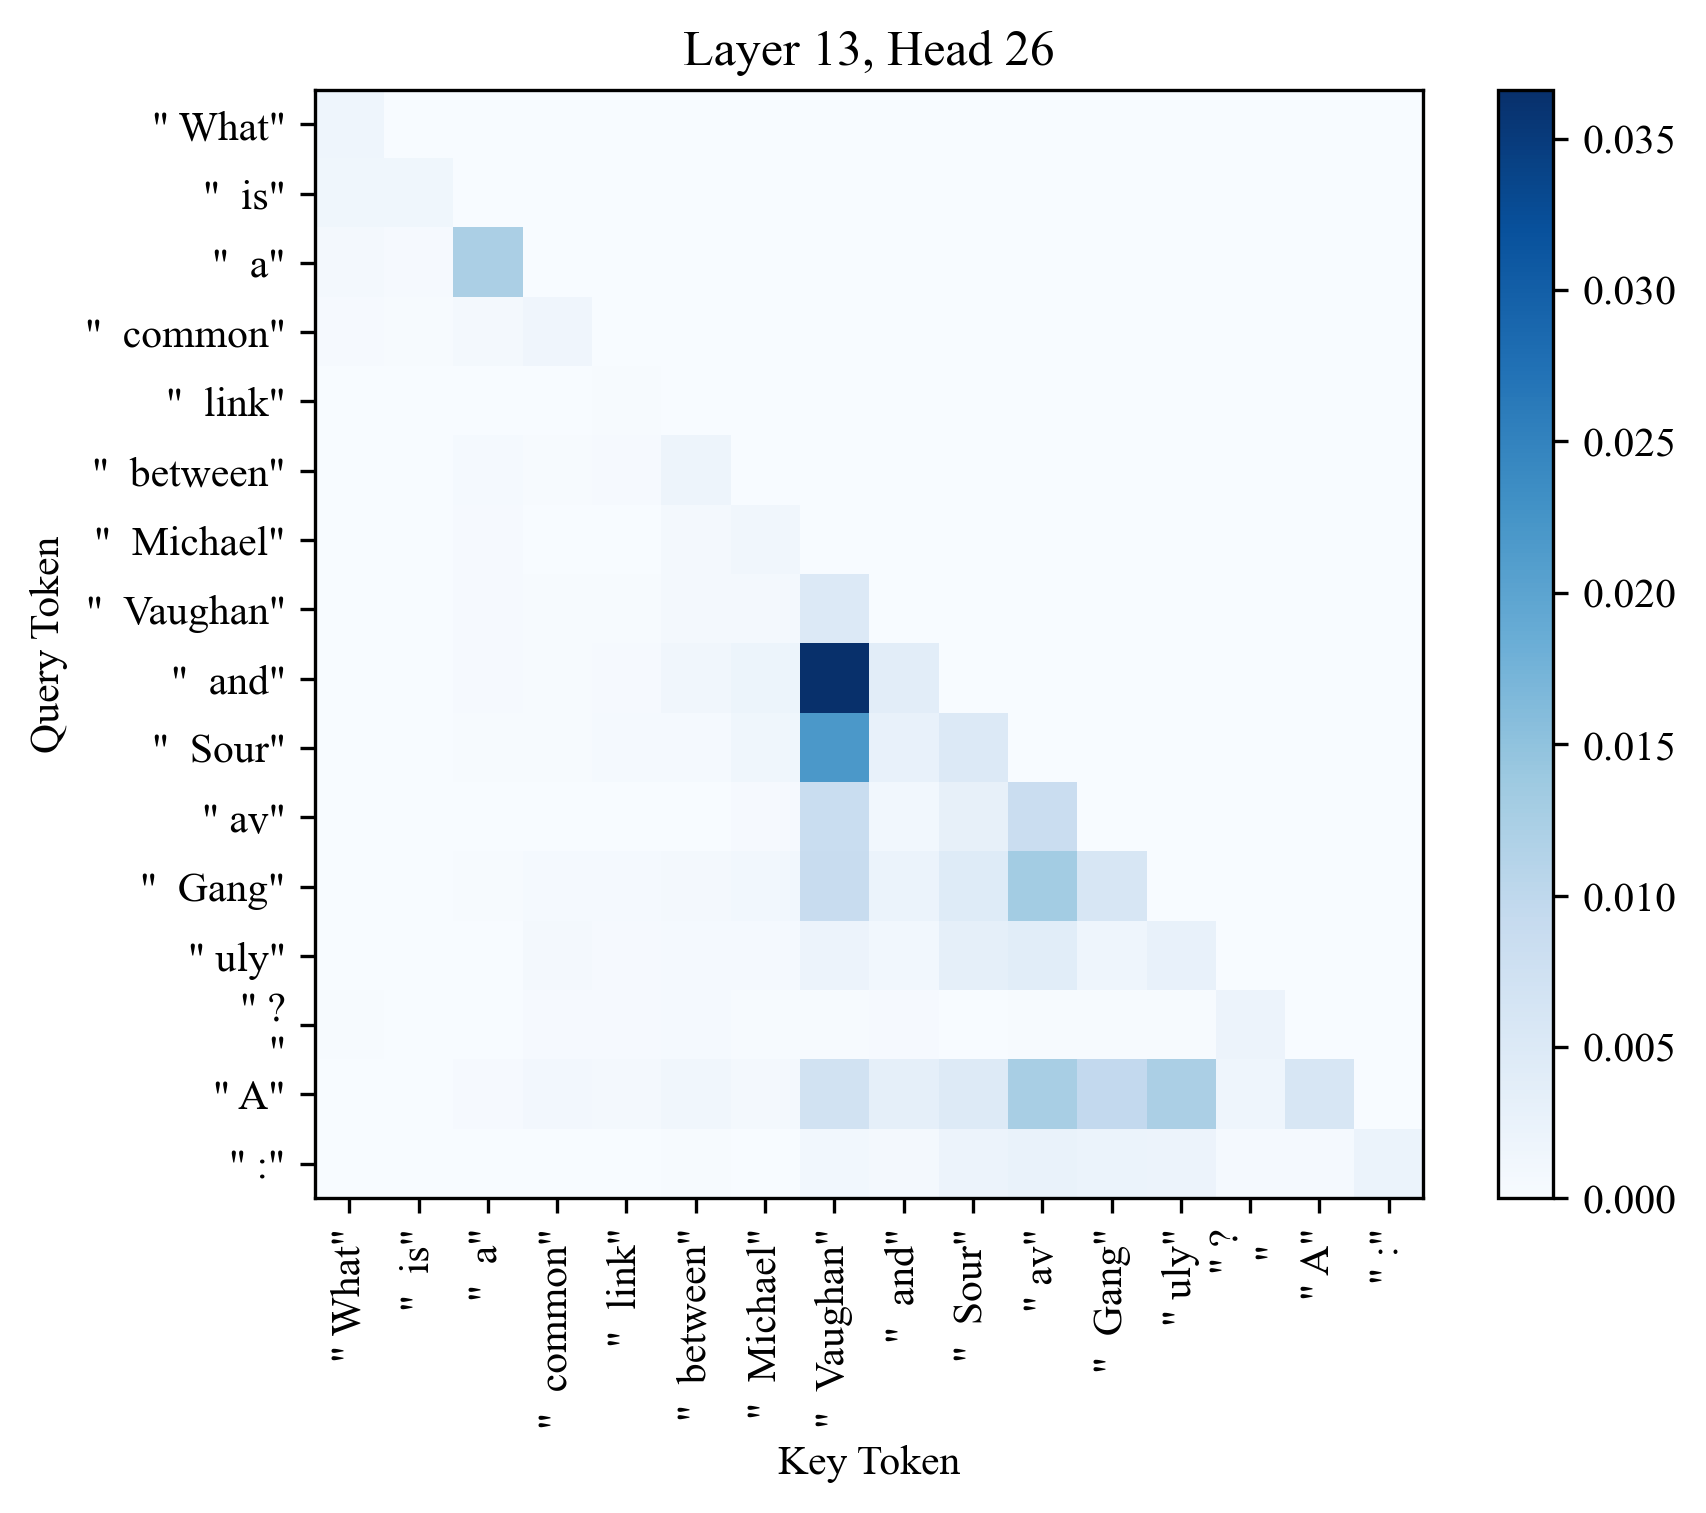

Layer 11, Head 27


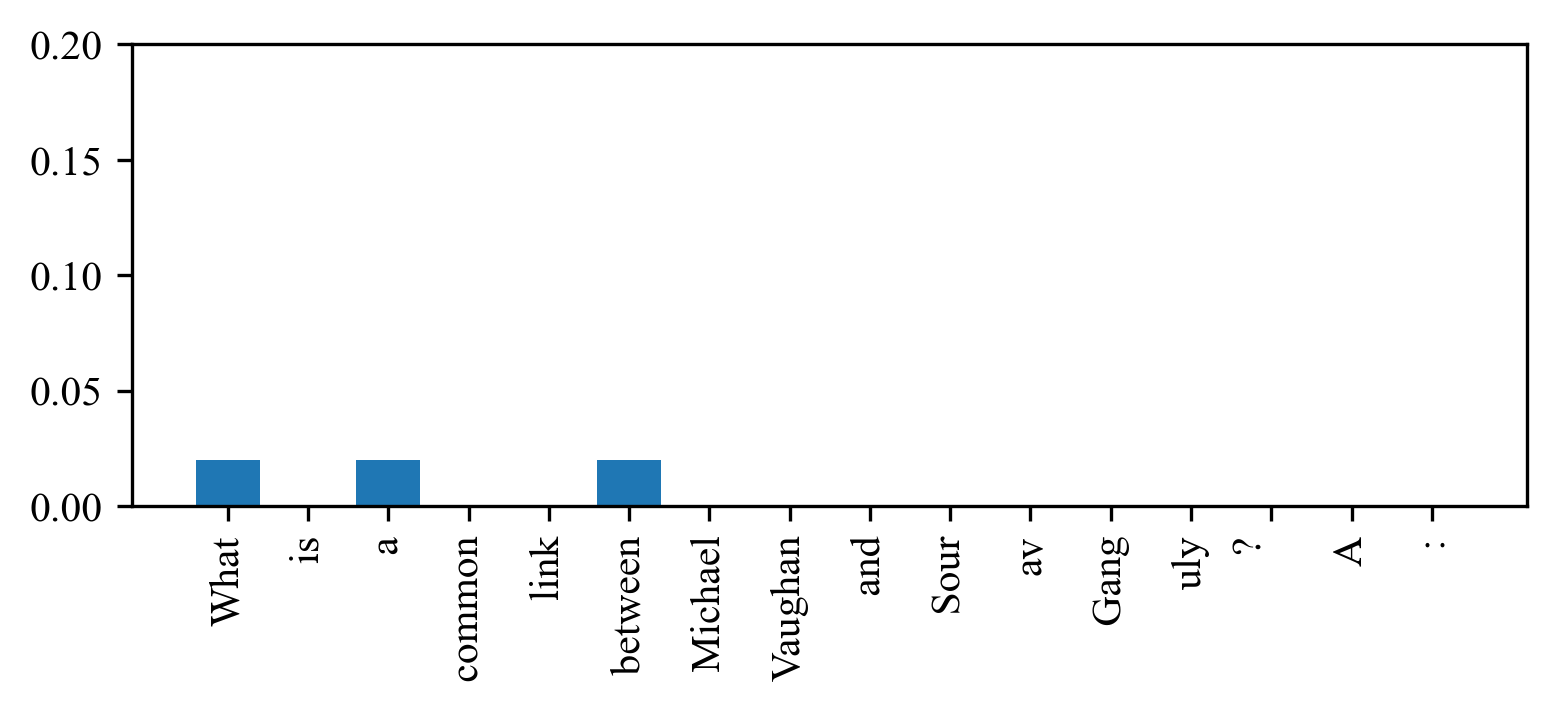

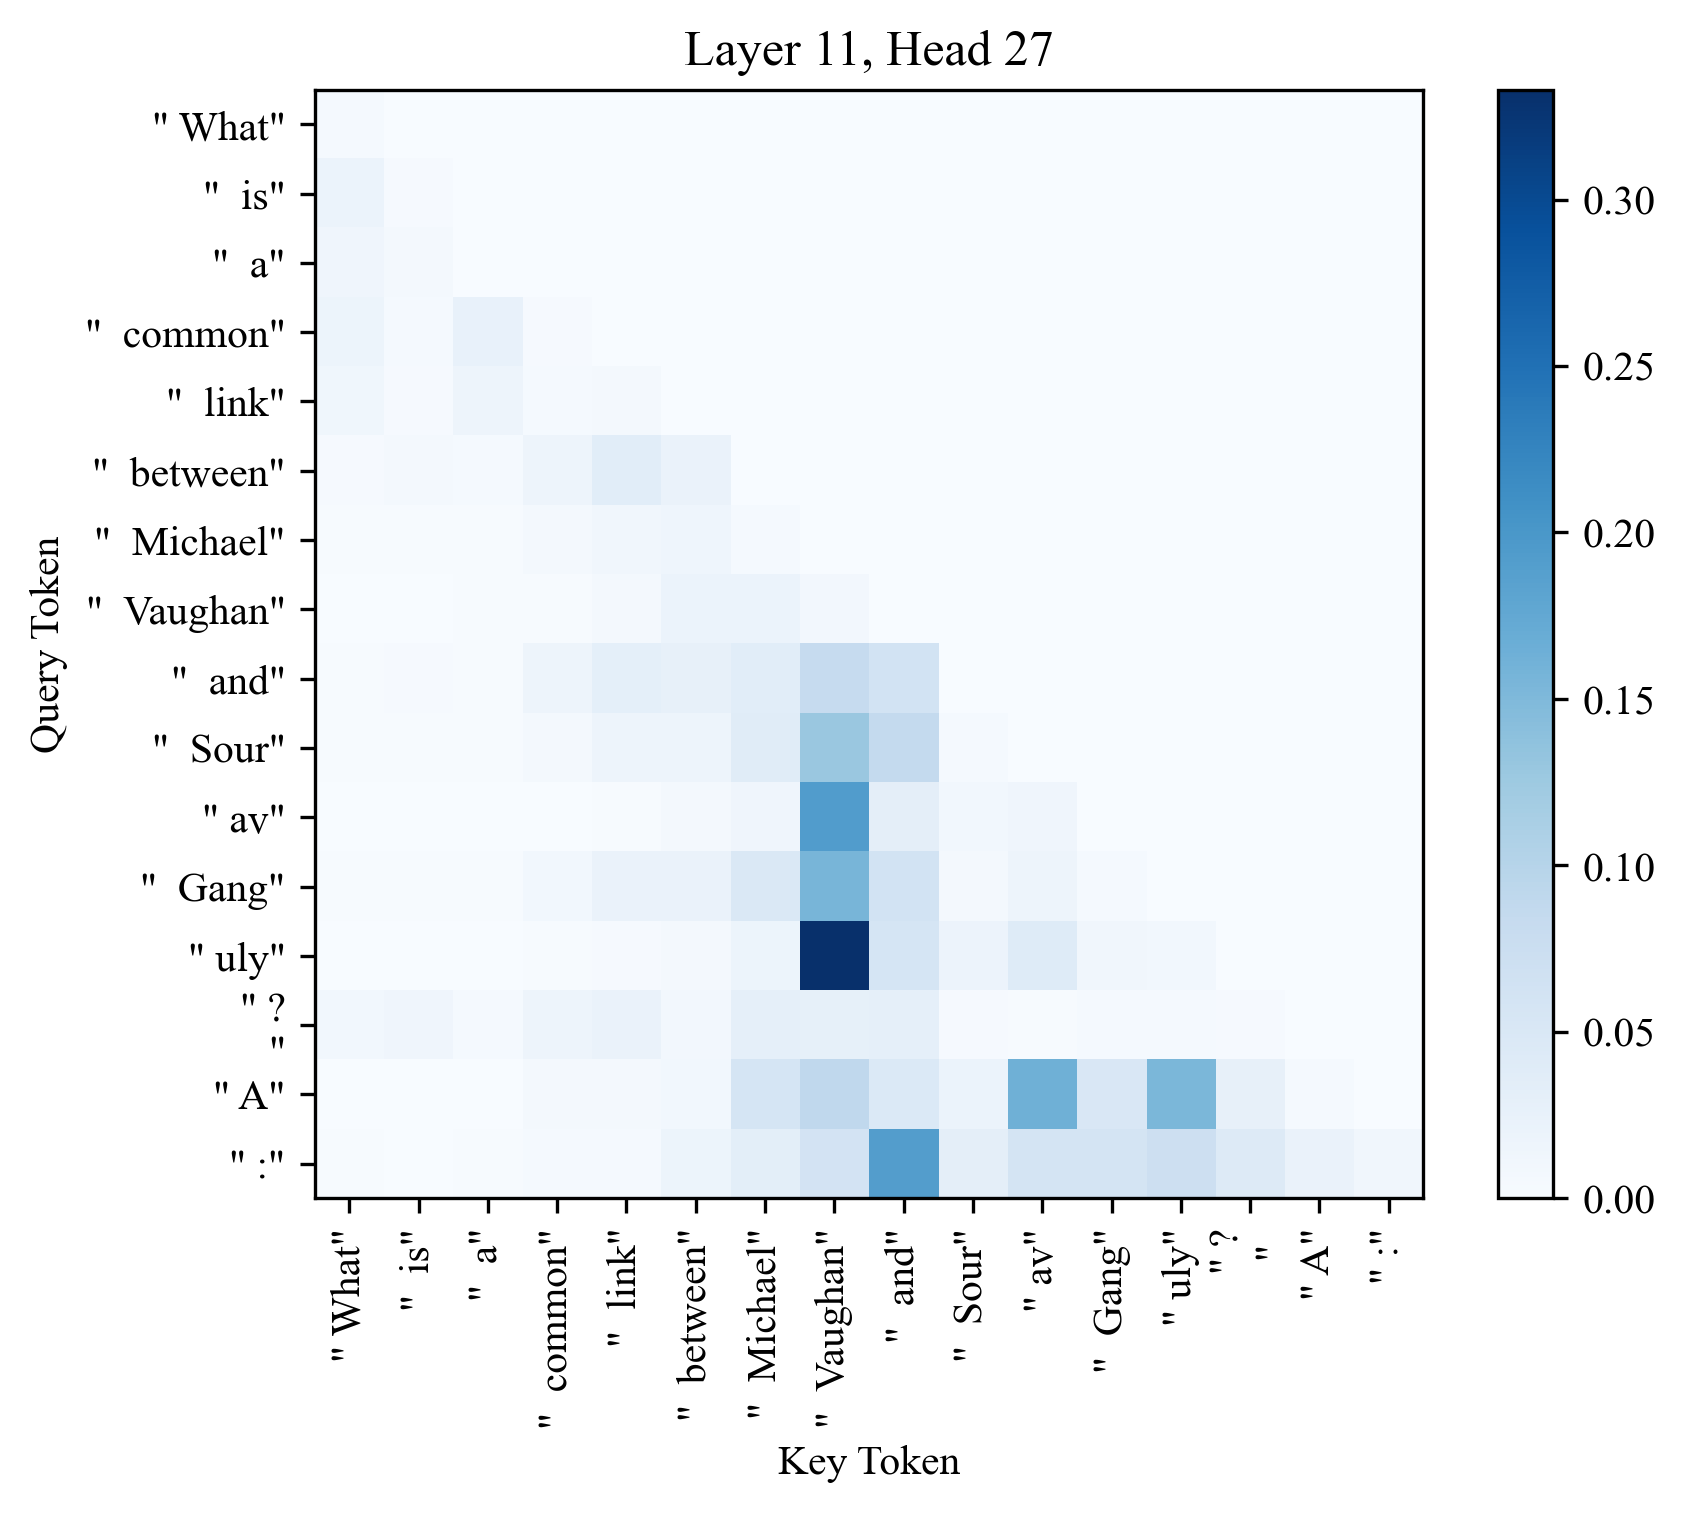

Layer 11, Head 13


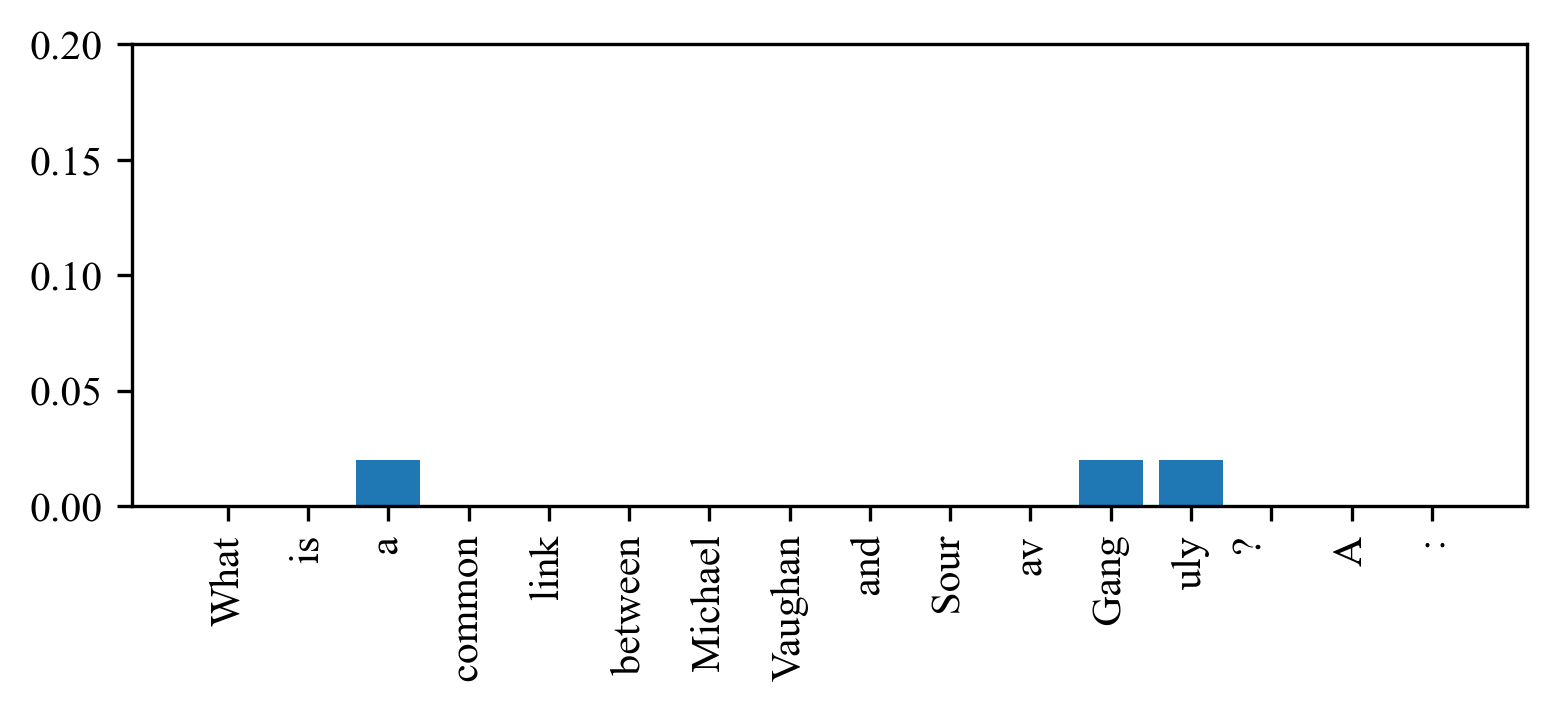

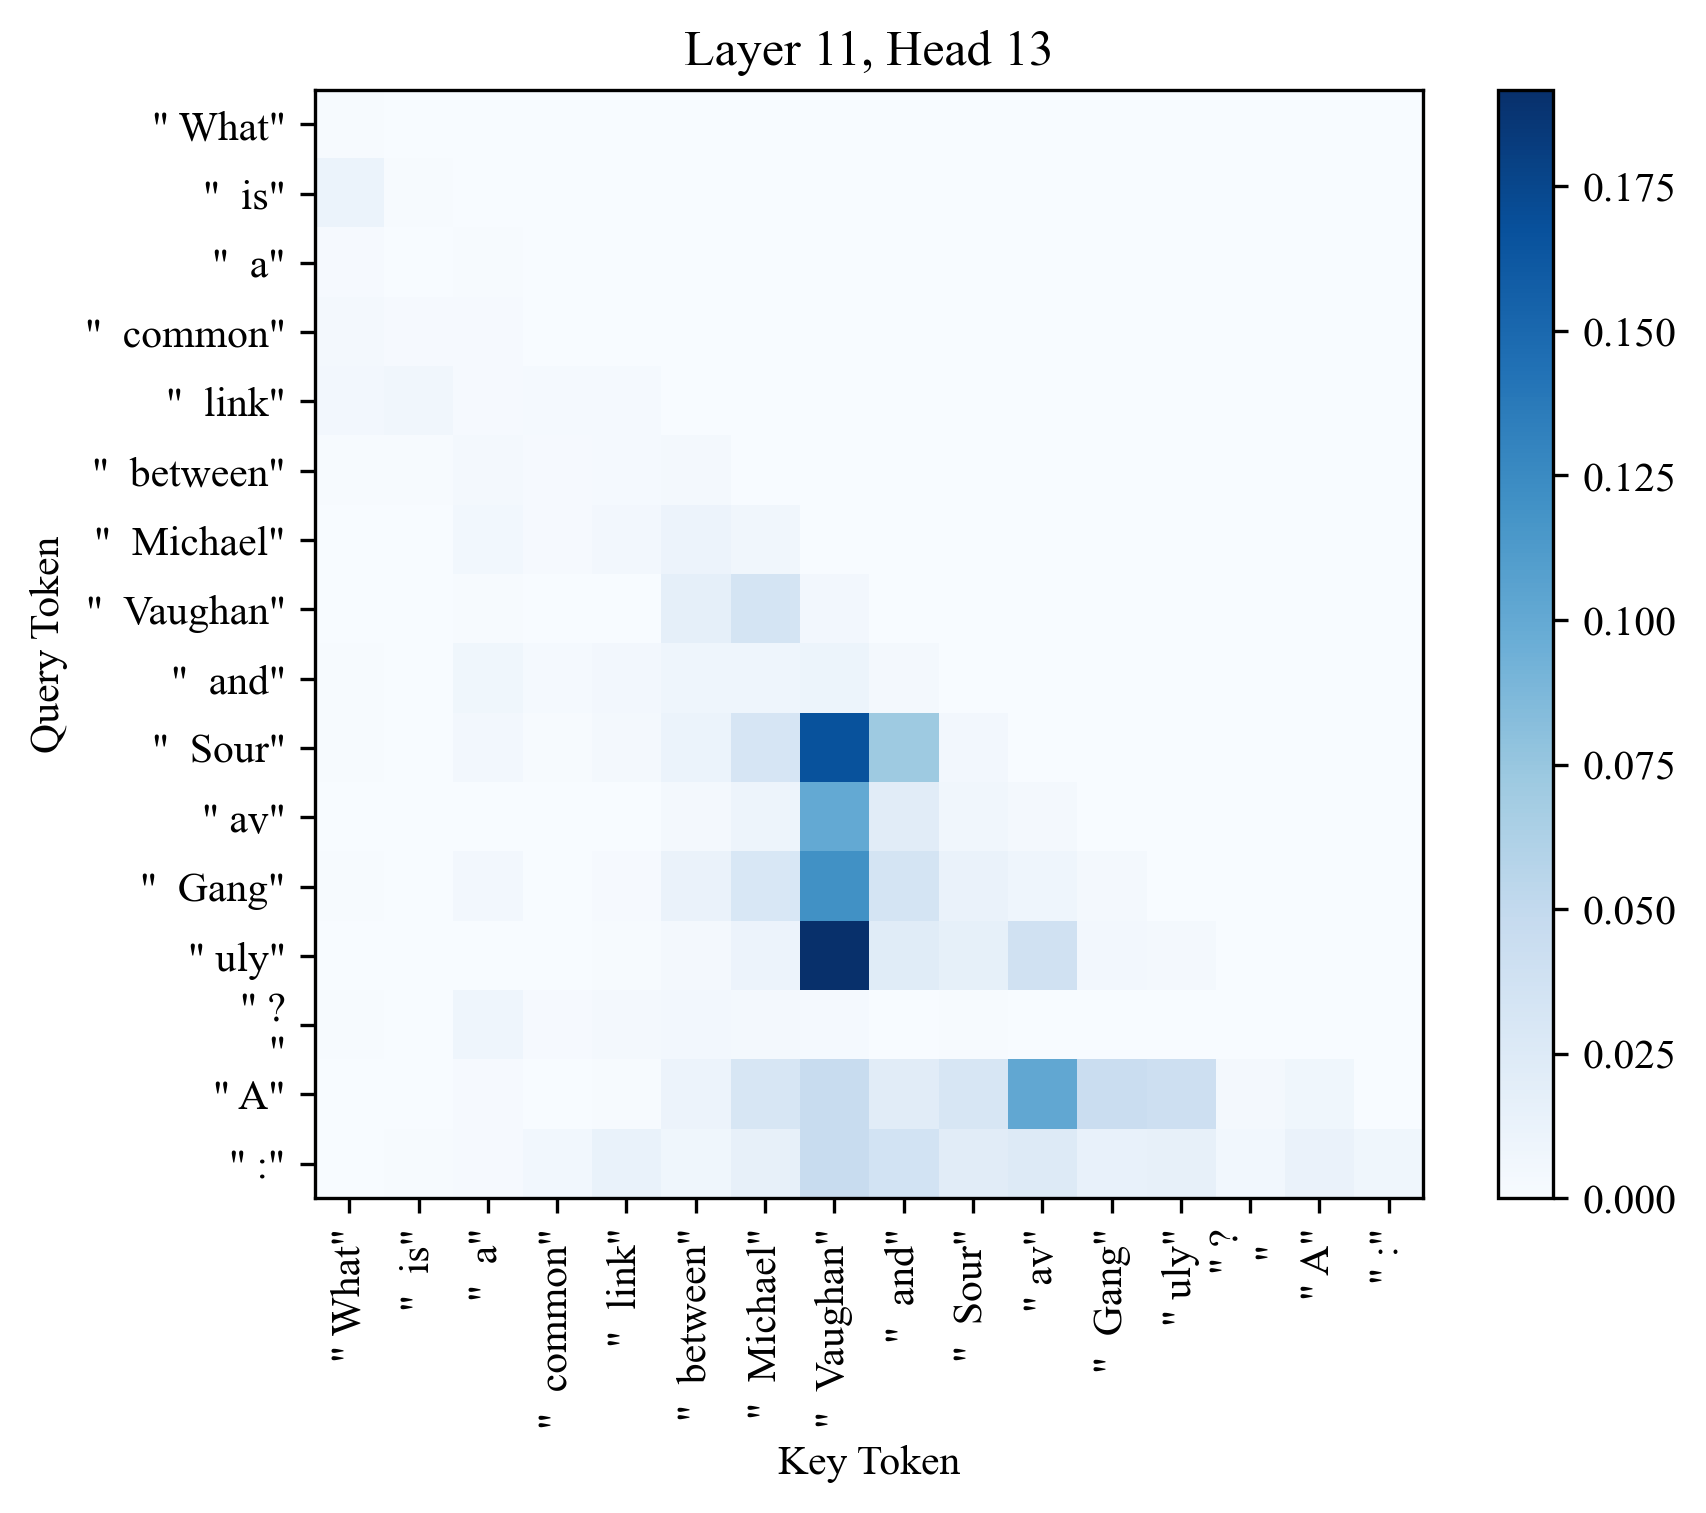

Layer 11, Head 26


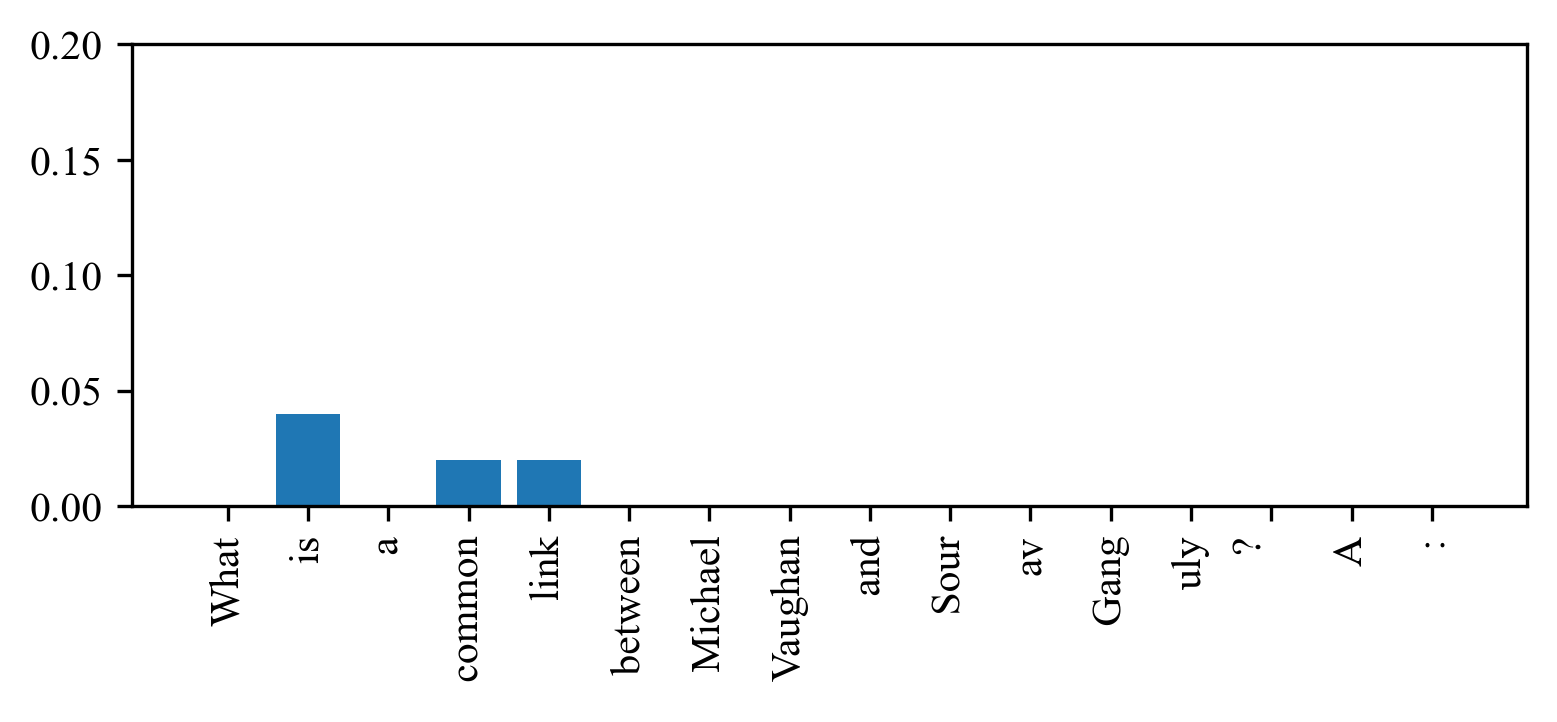

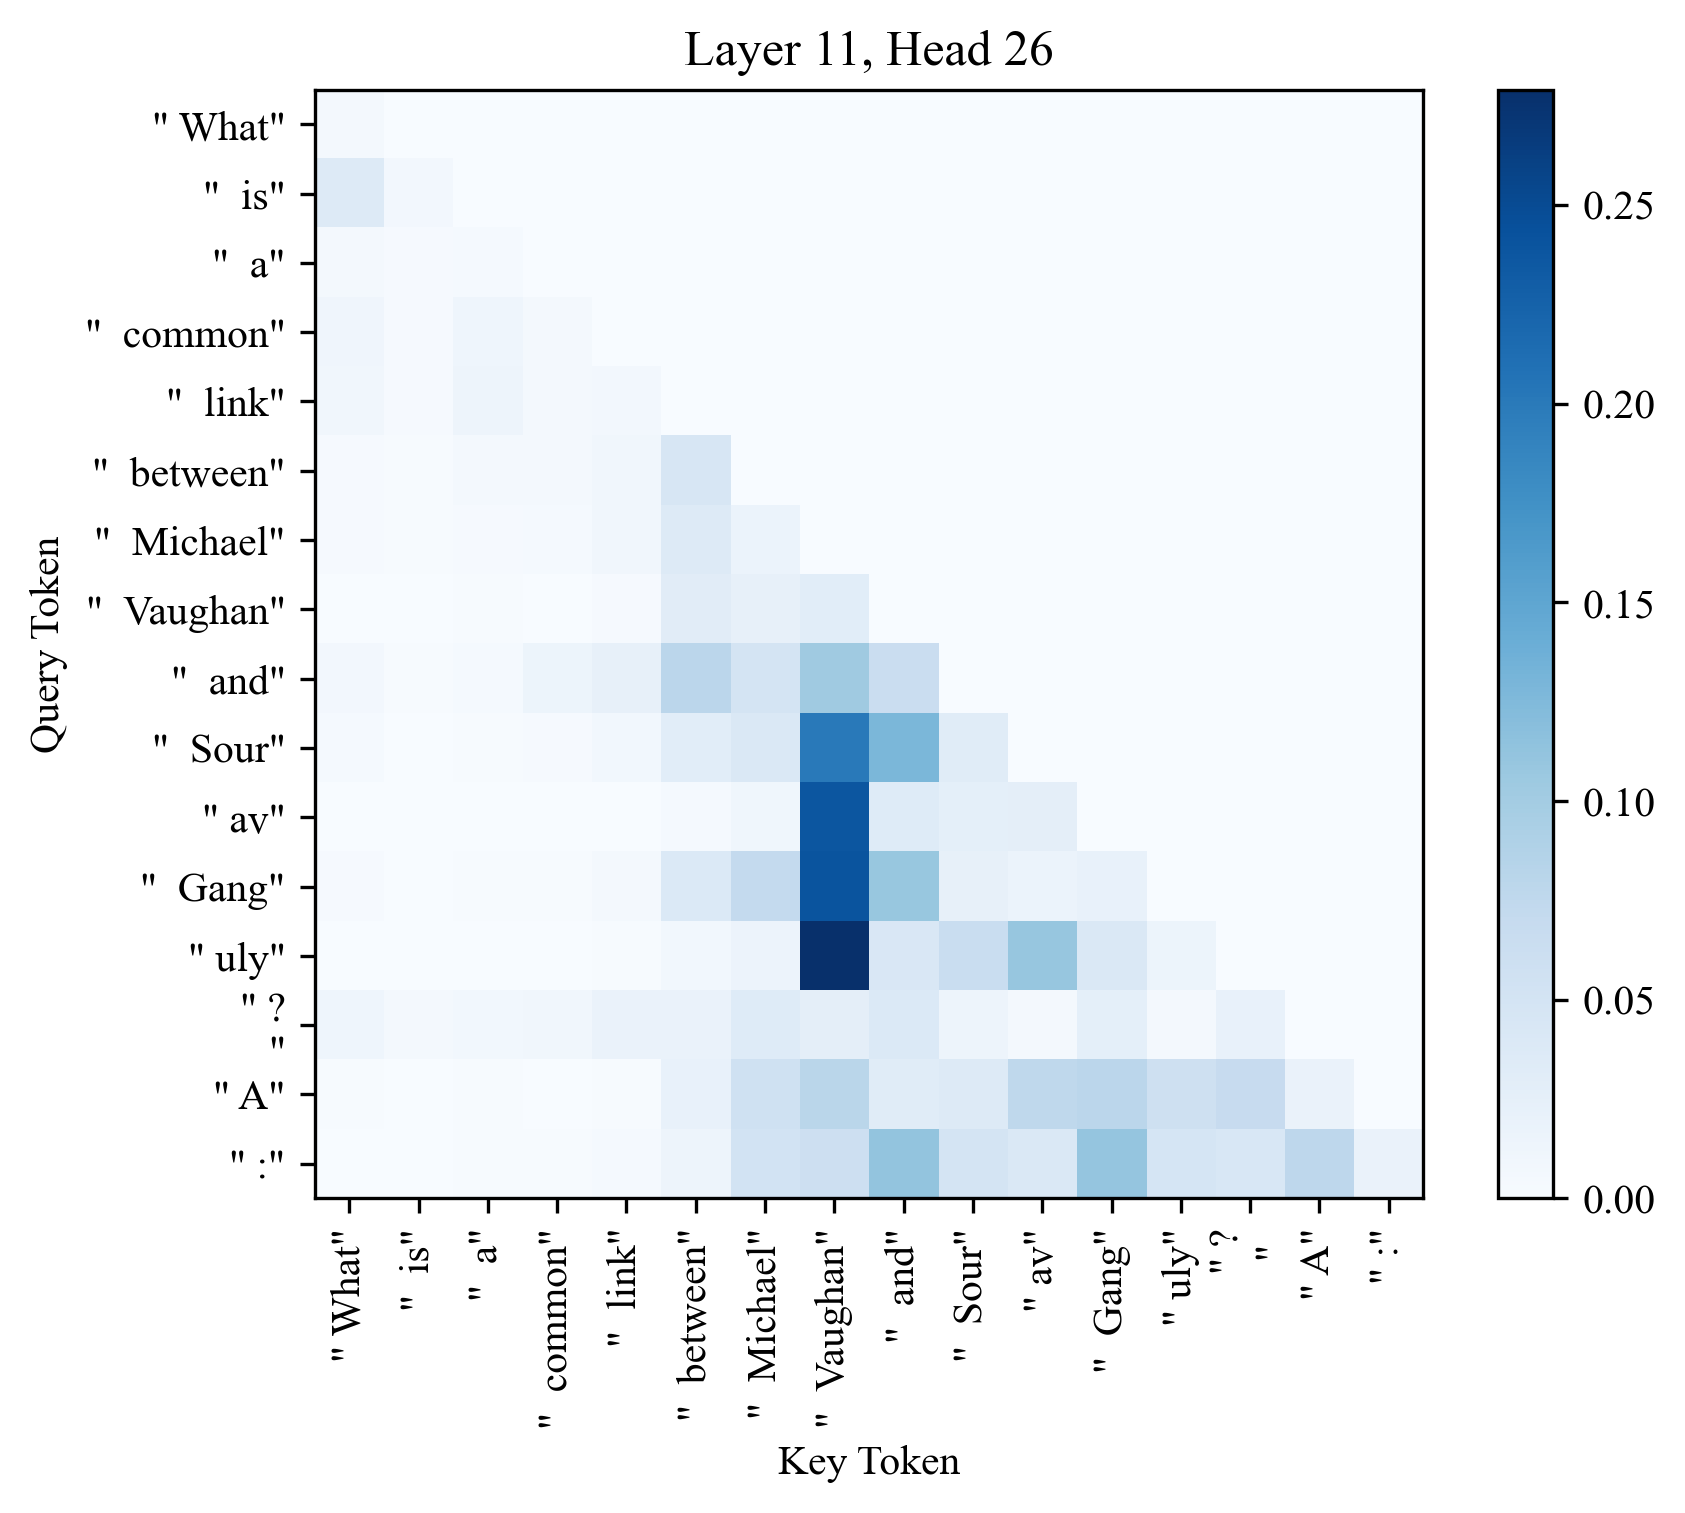

Layer 17, Head 5


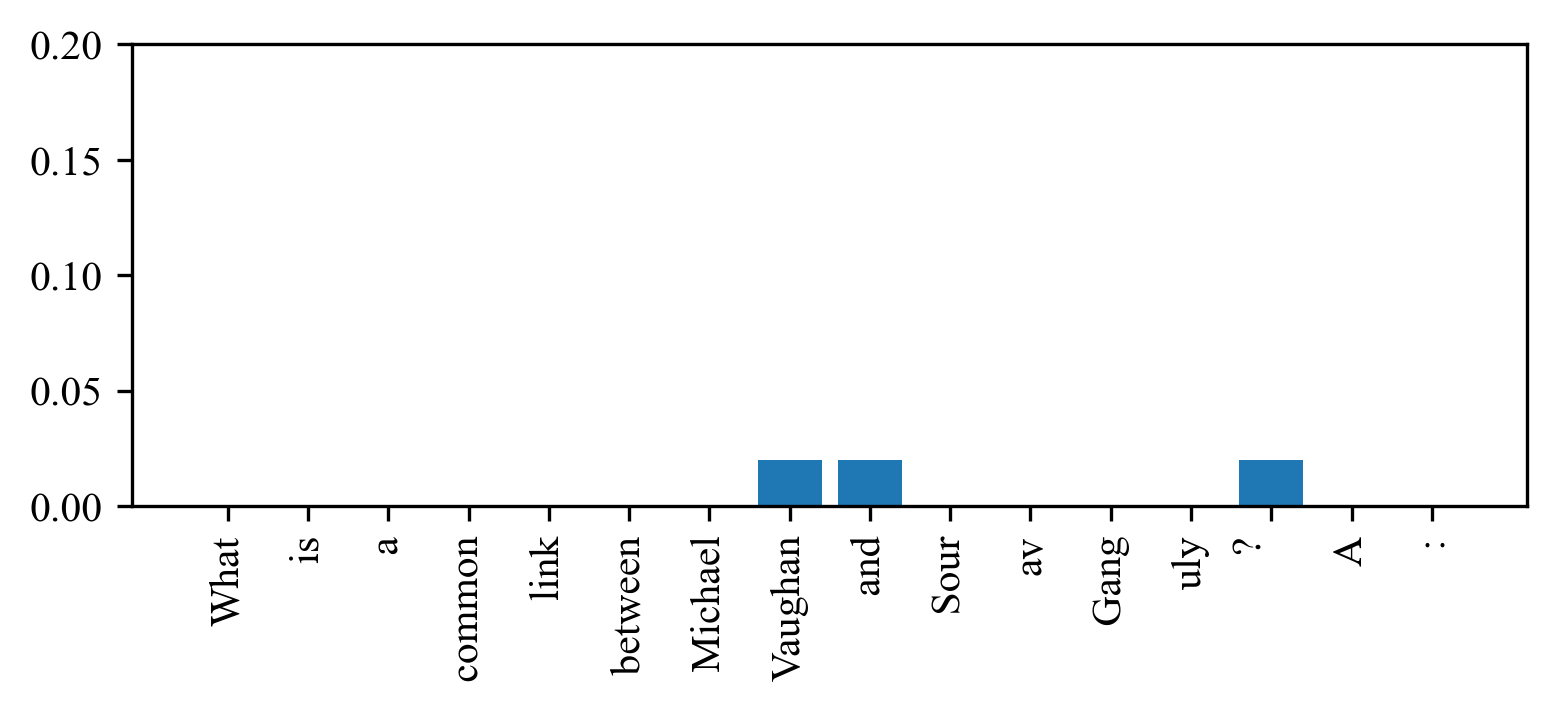

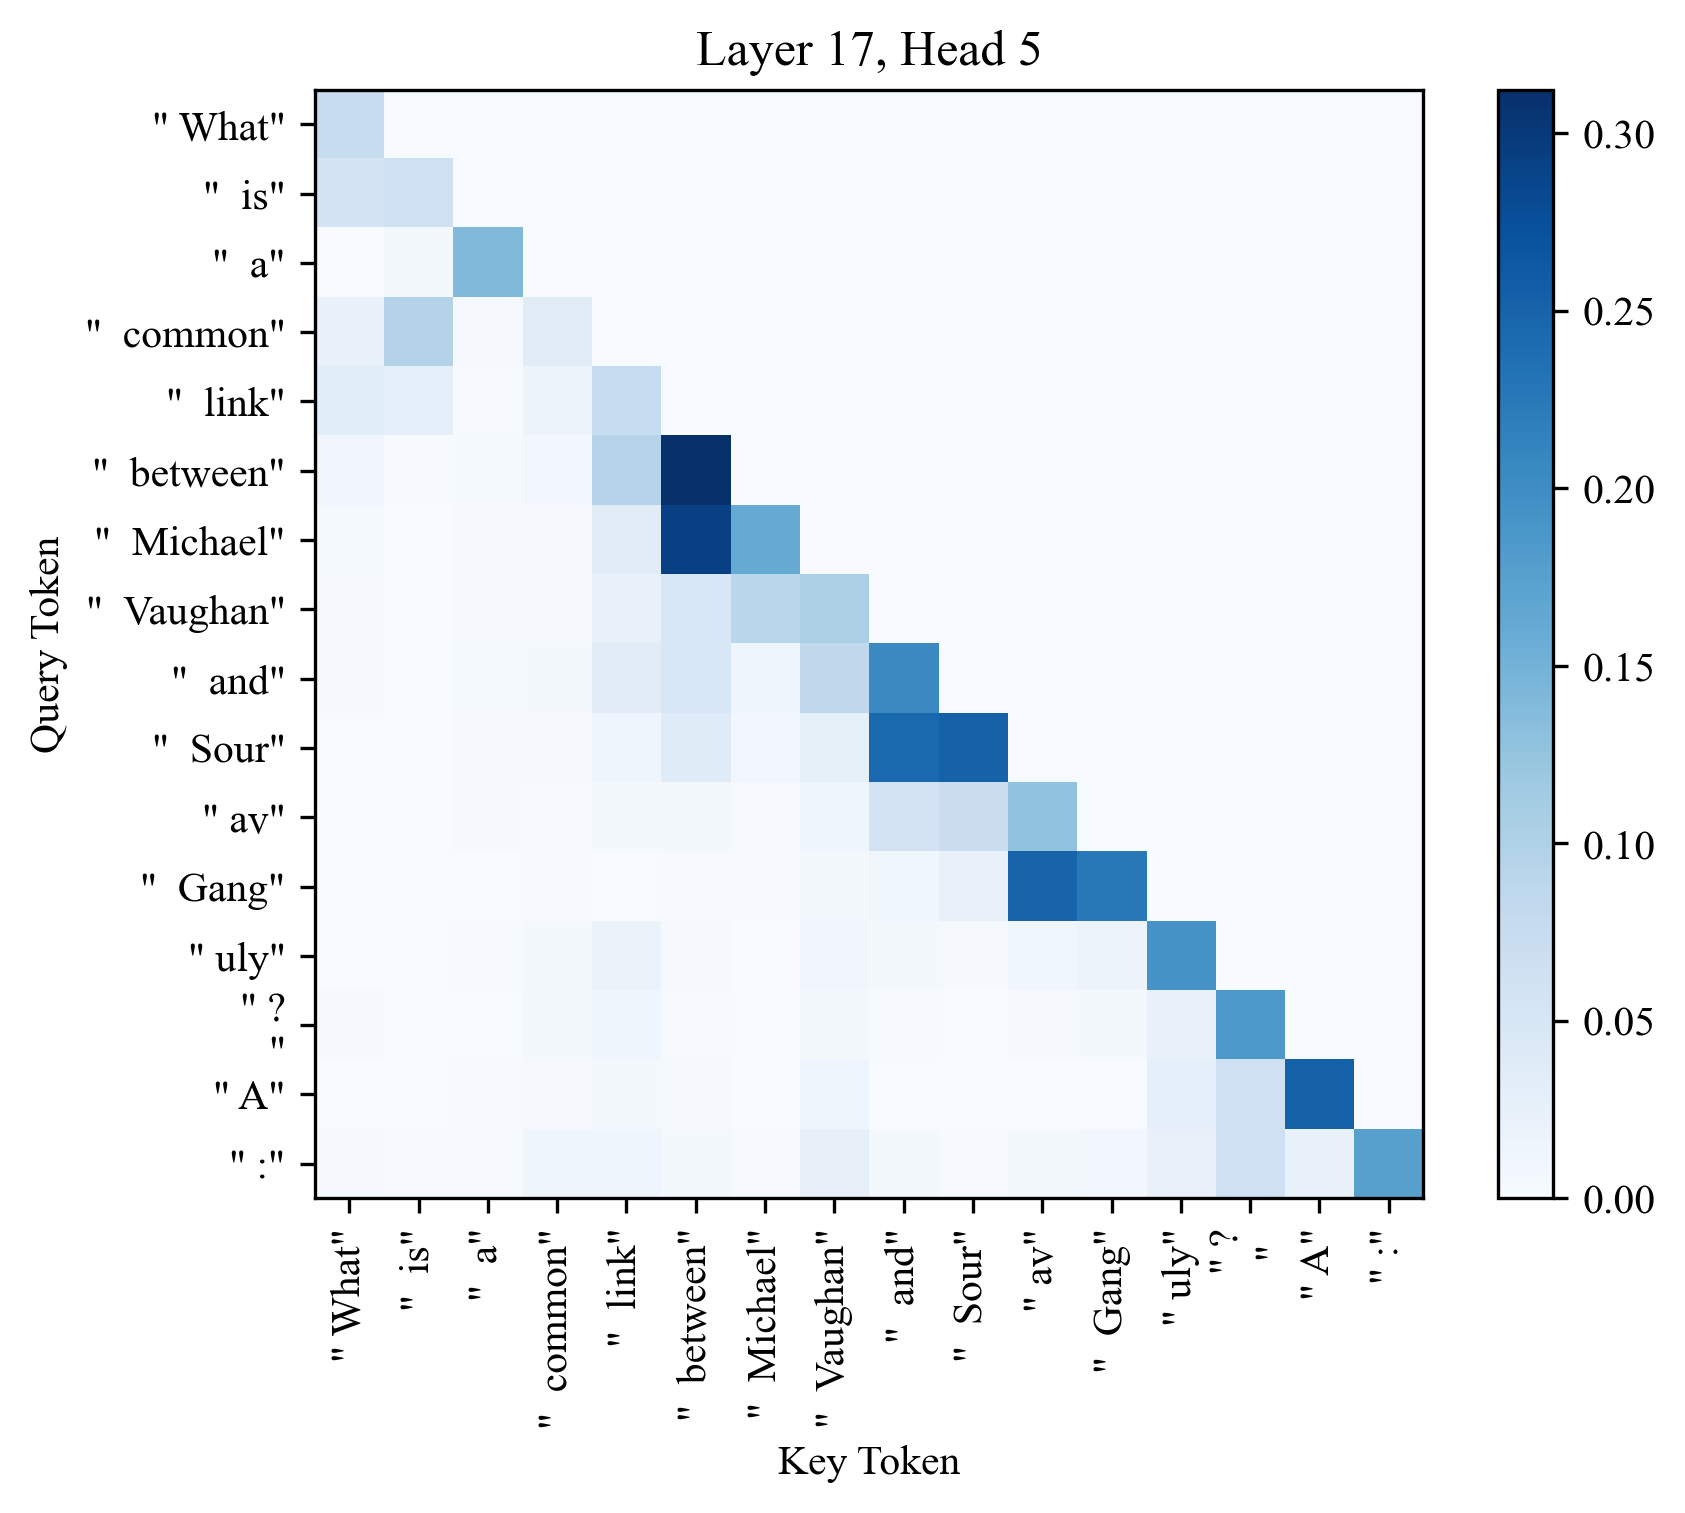

Layer 17, Head 8


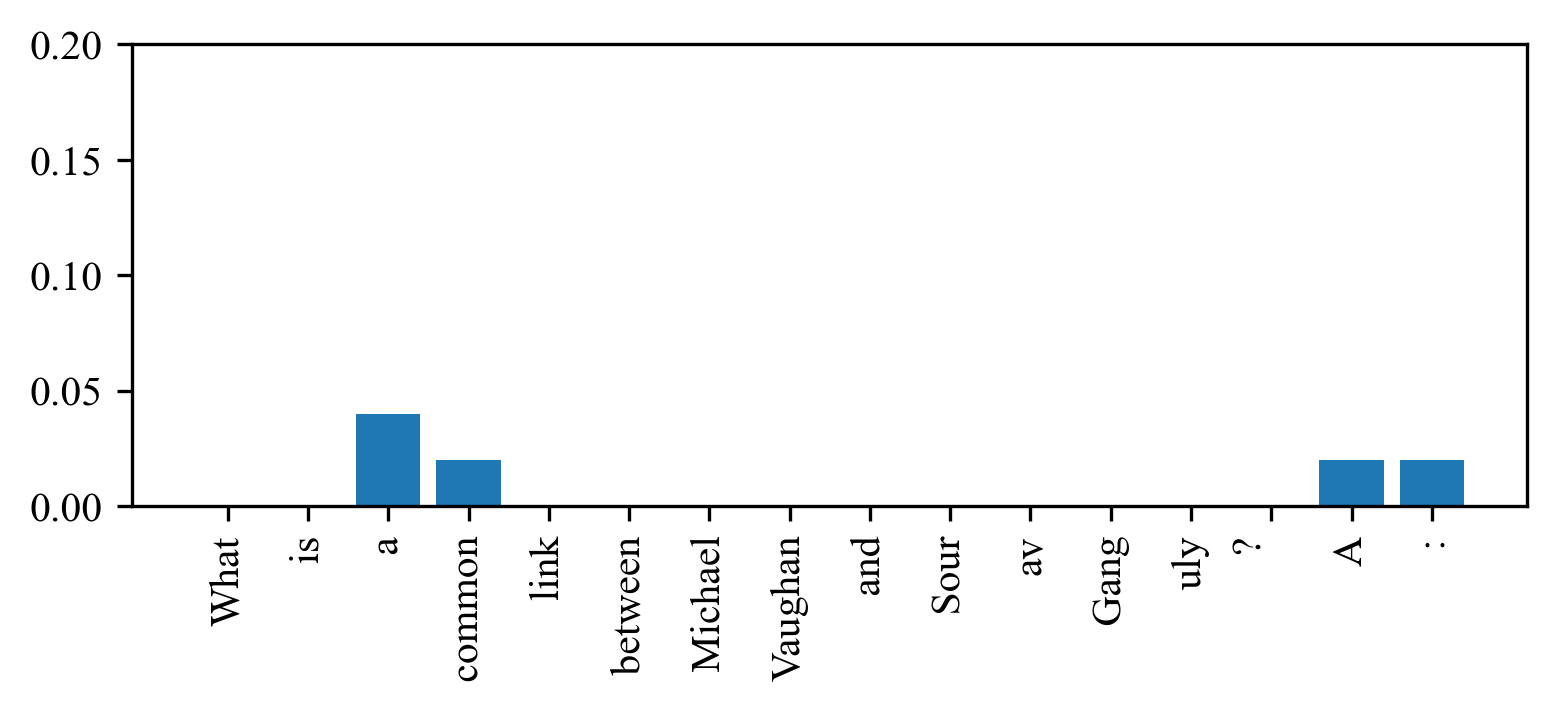

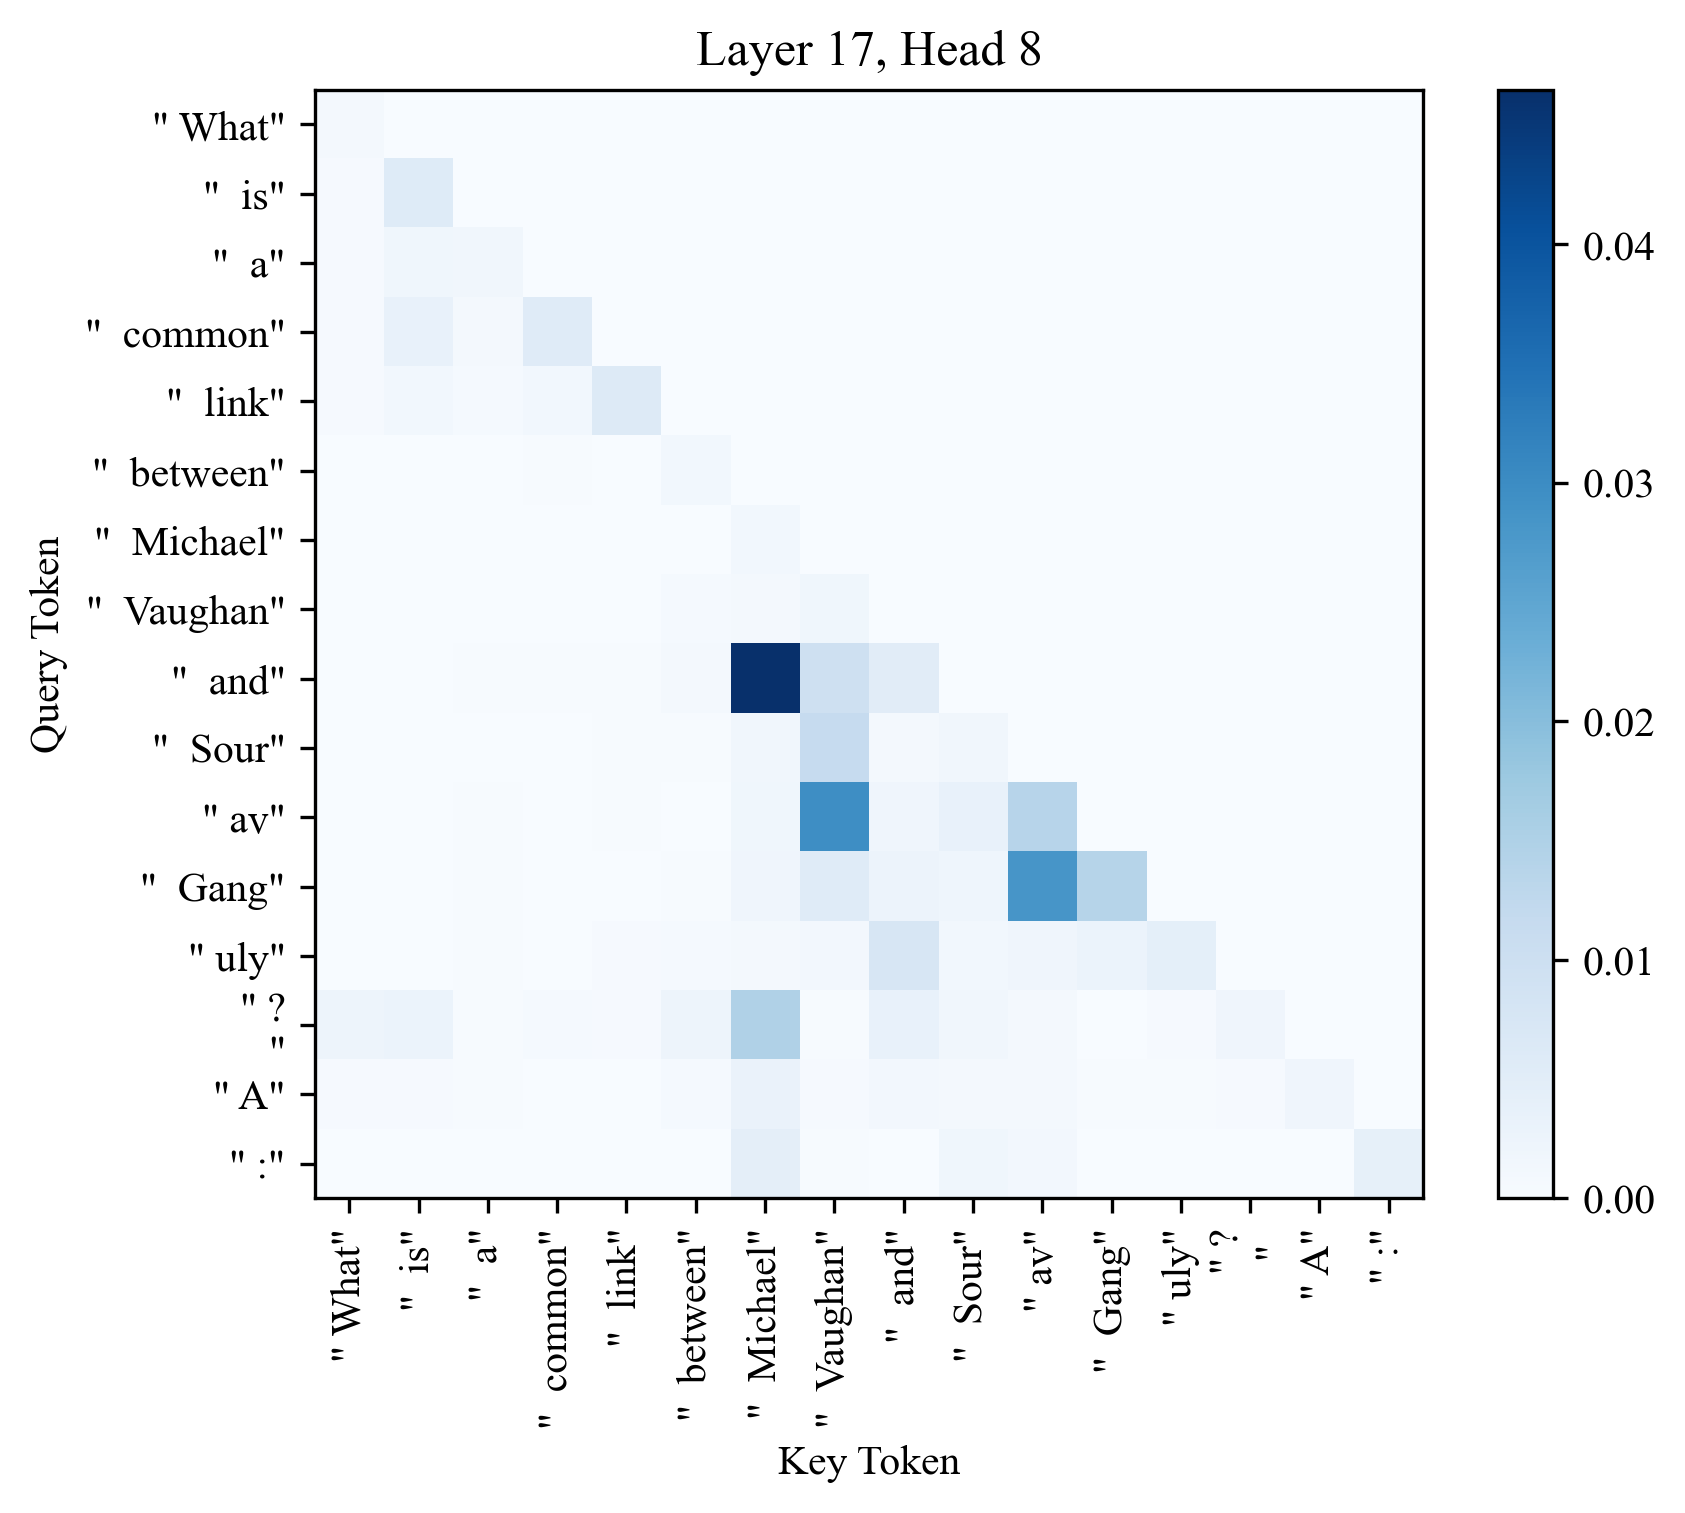

Layer 0, Head 2


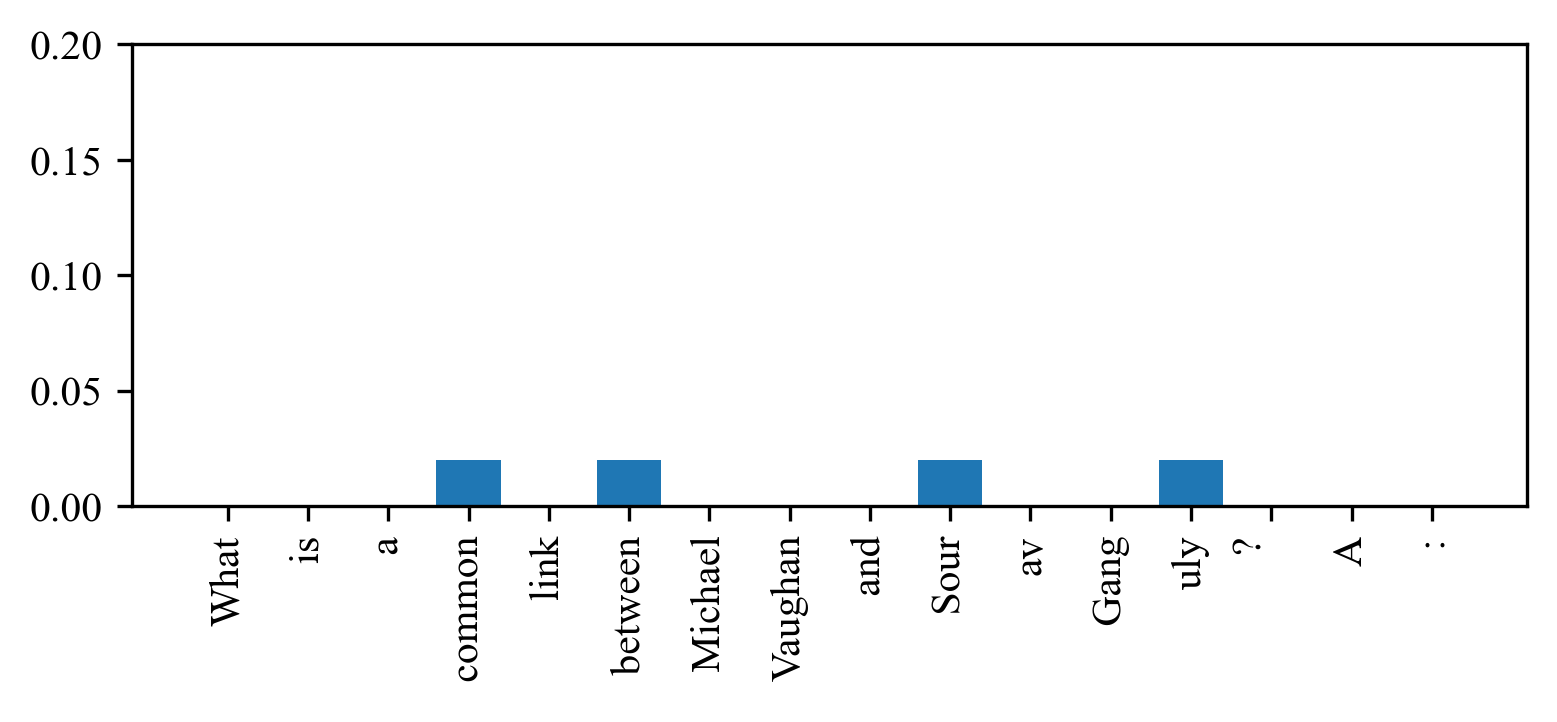

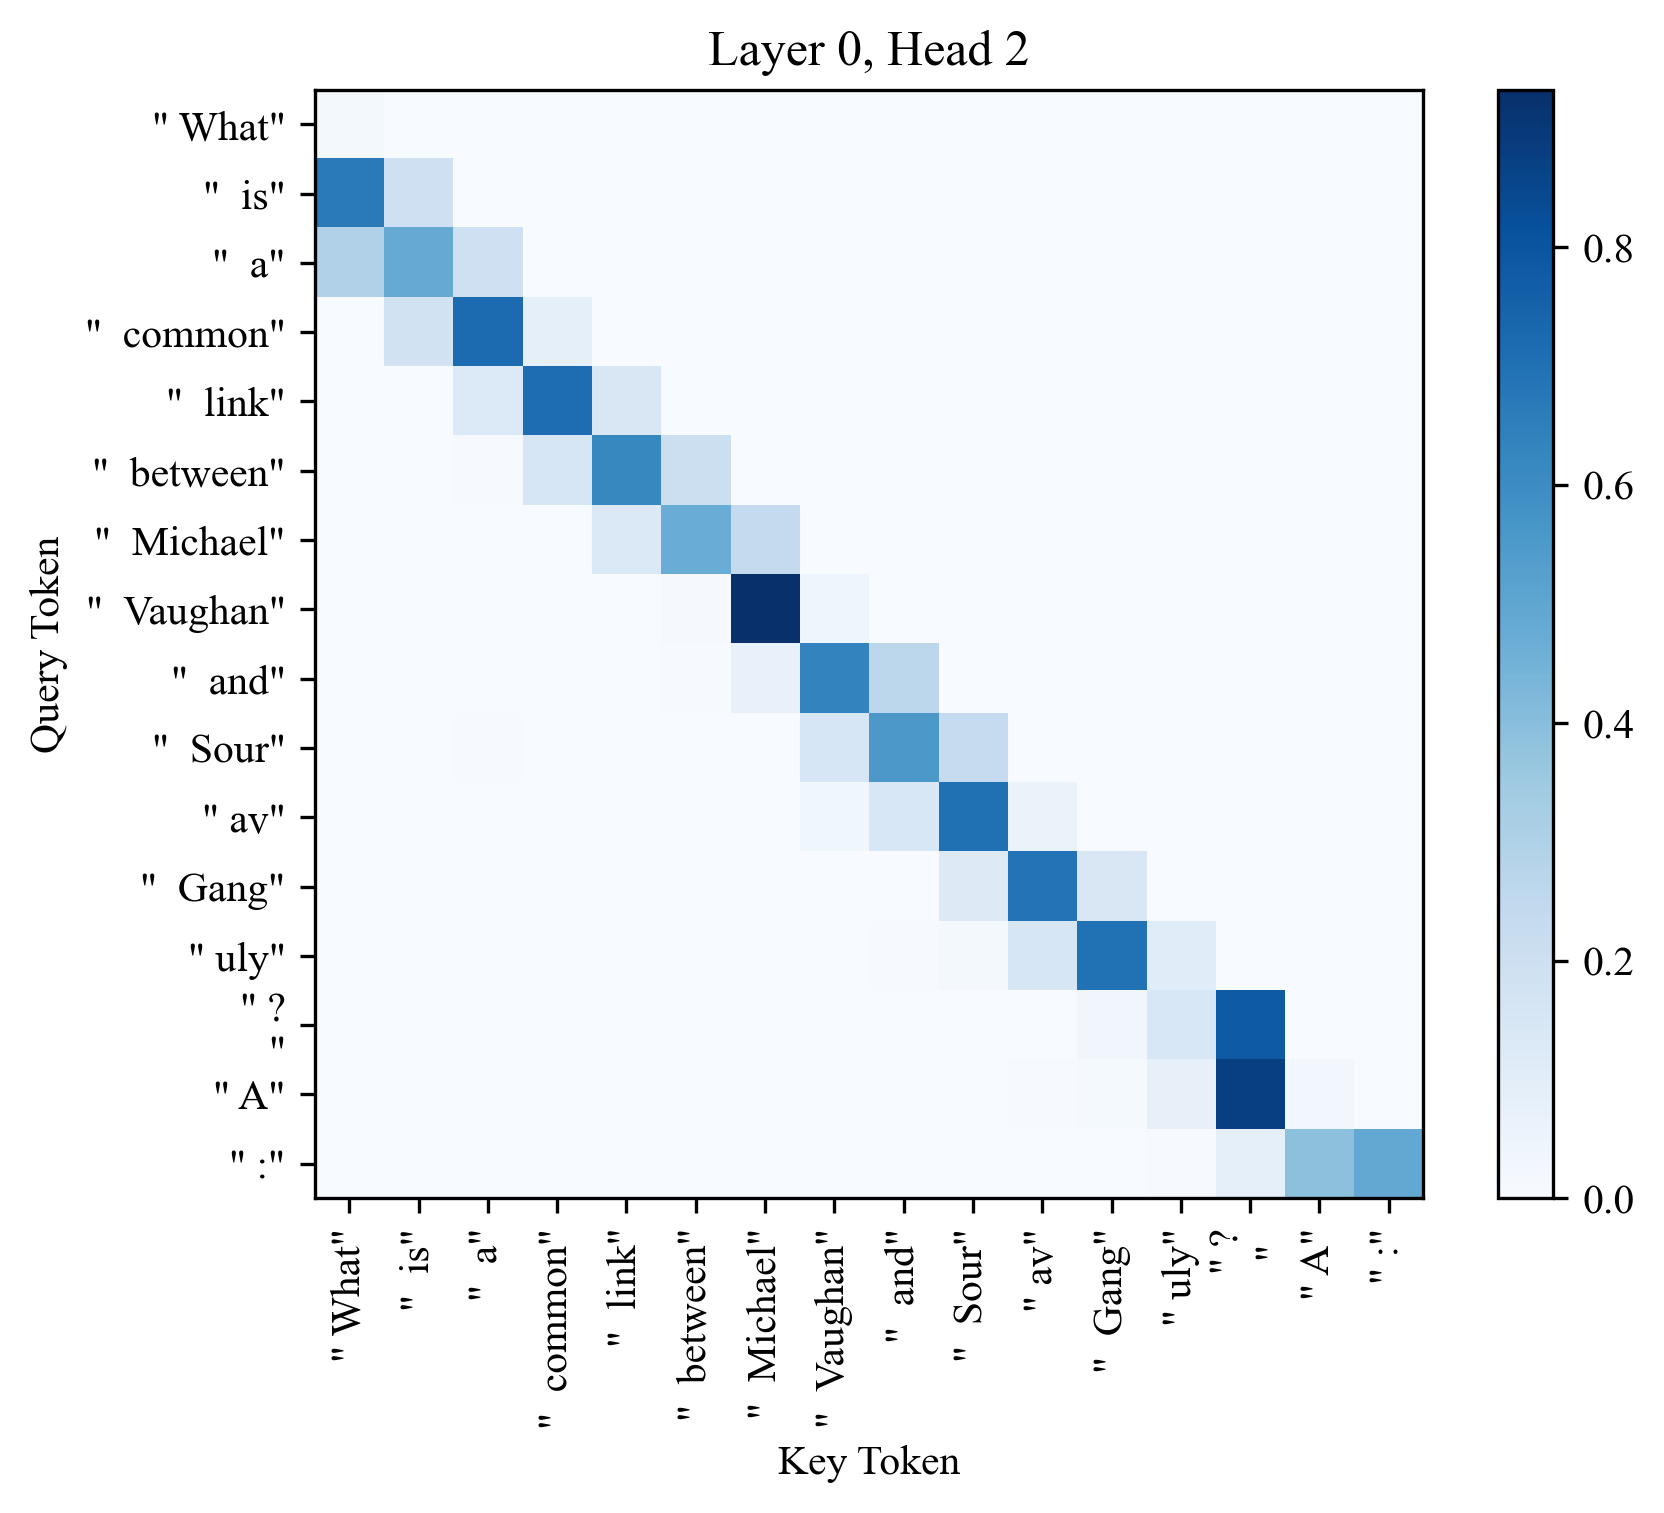

Layer 0, Head 3


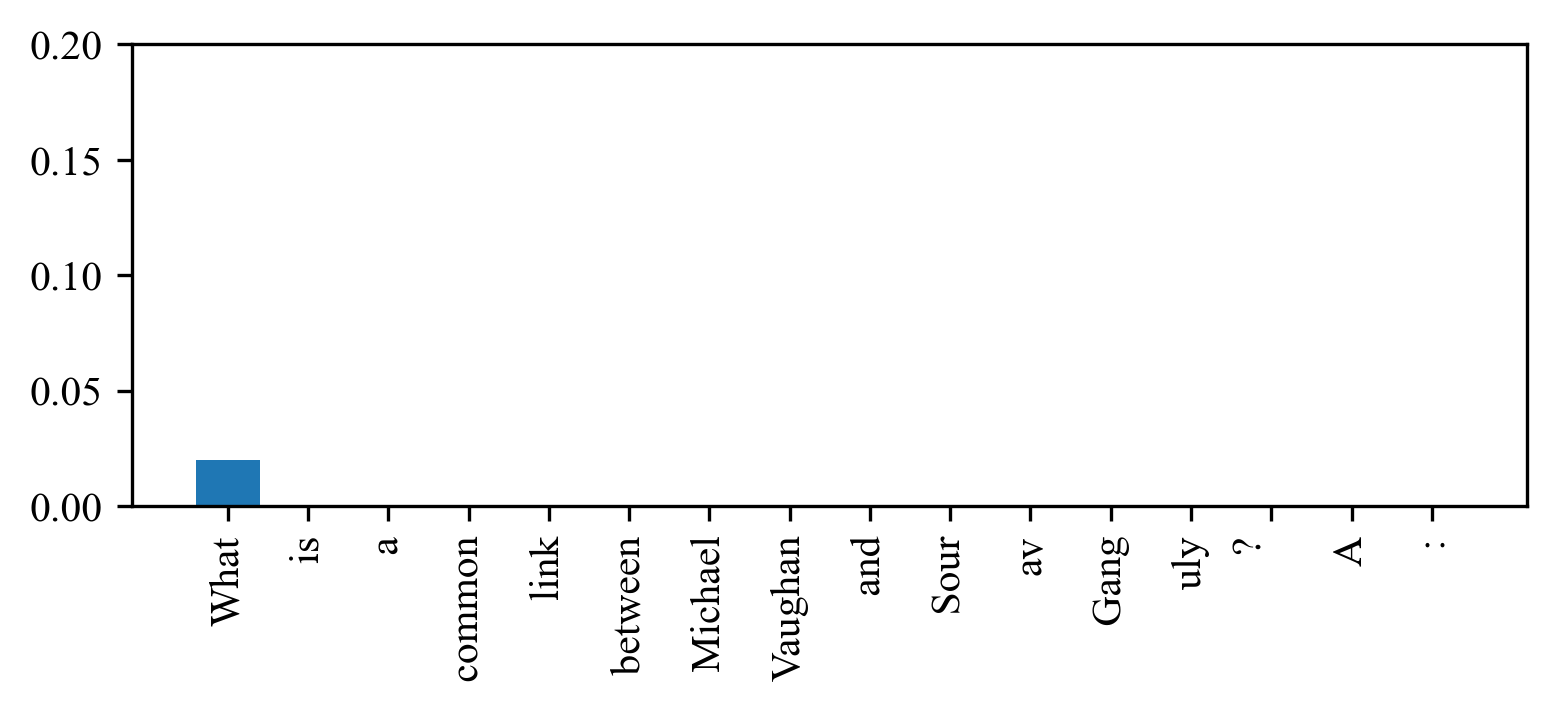

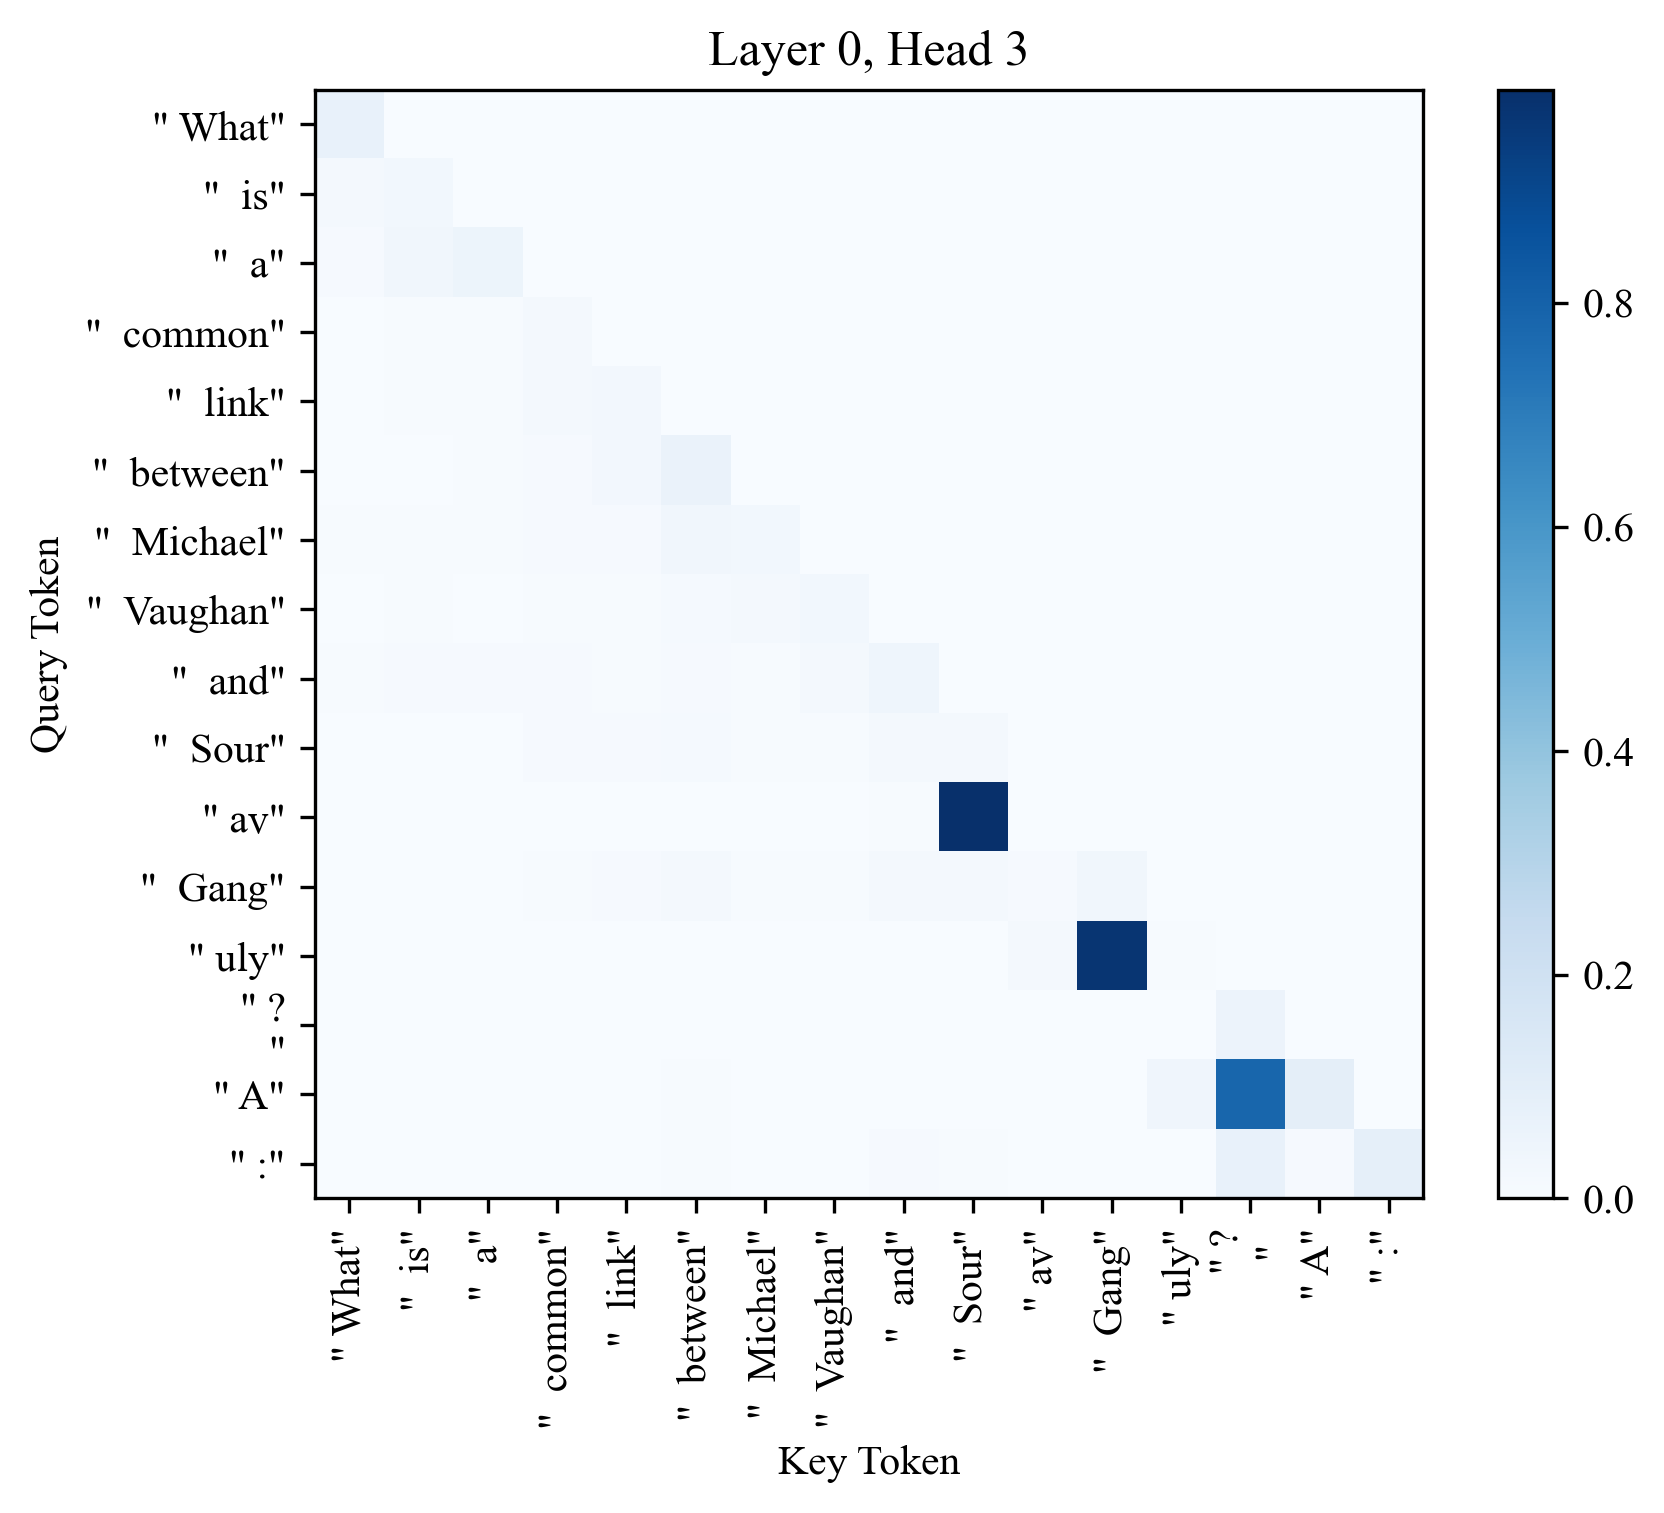

Layer 7, Head 7


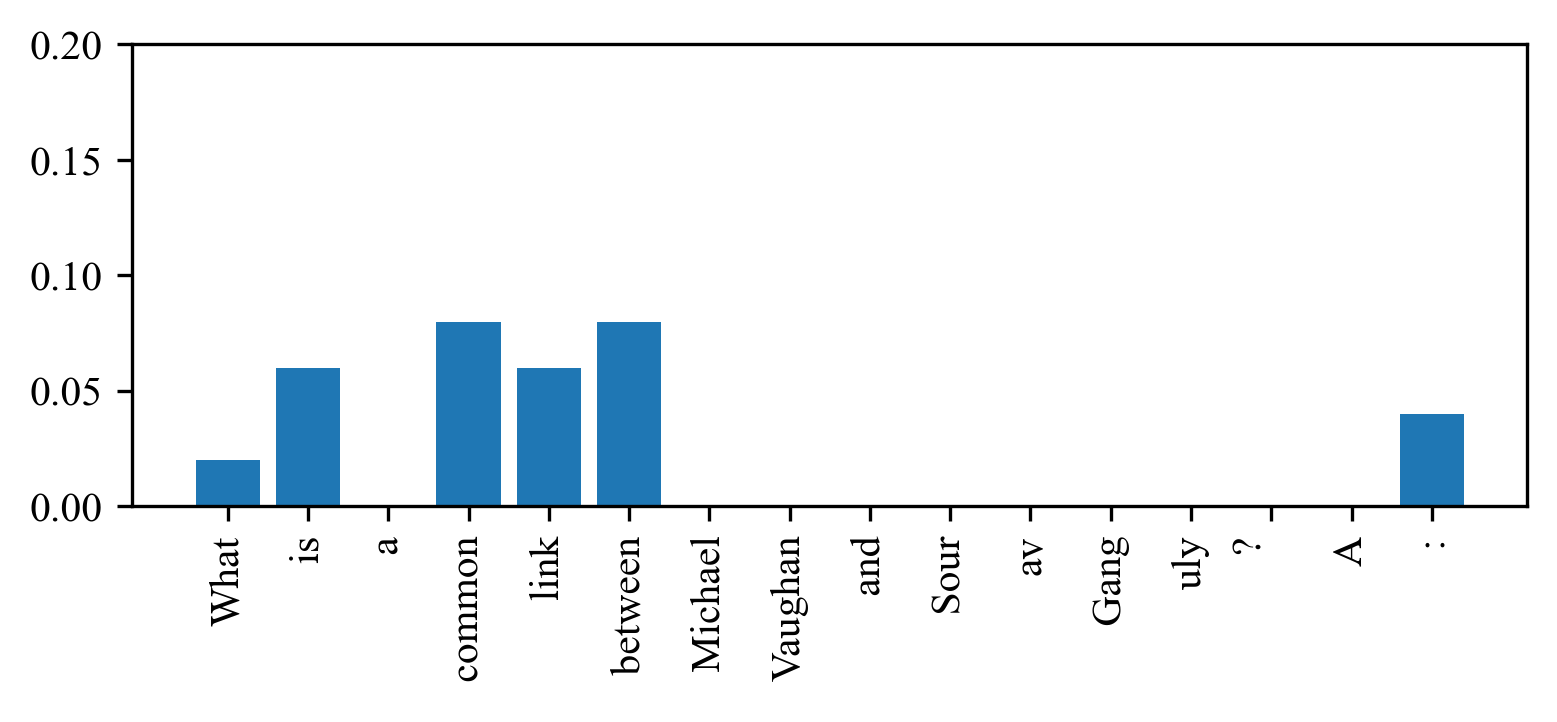

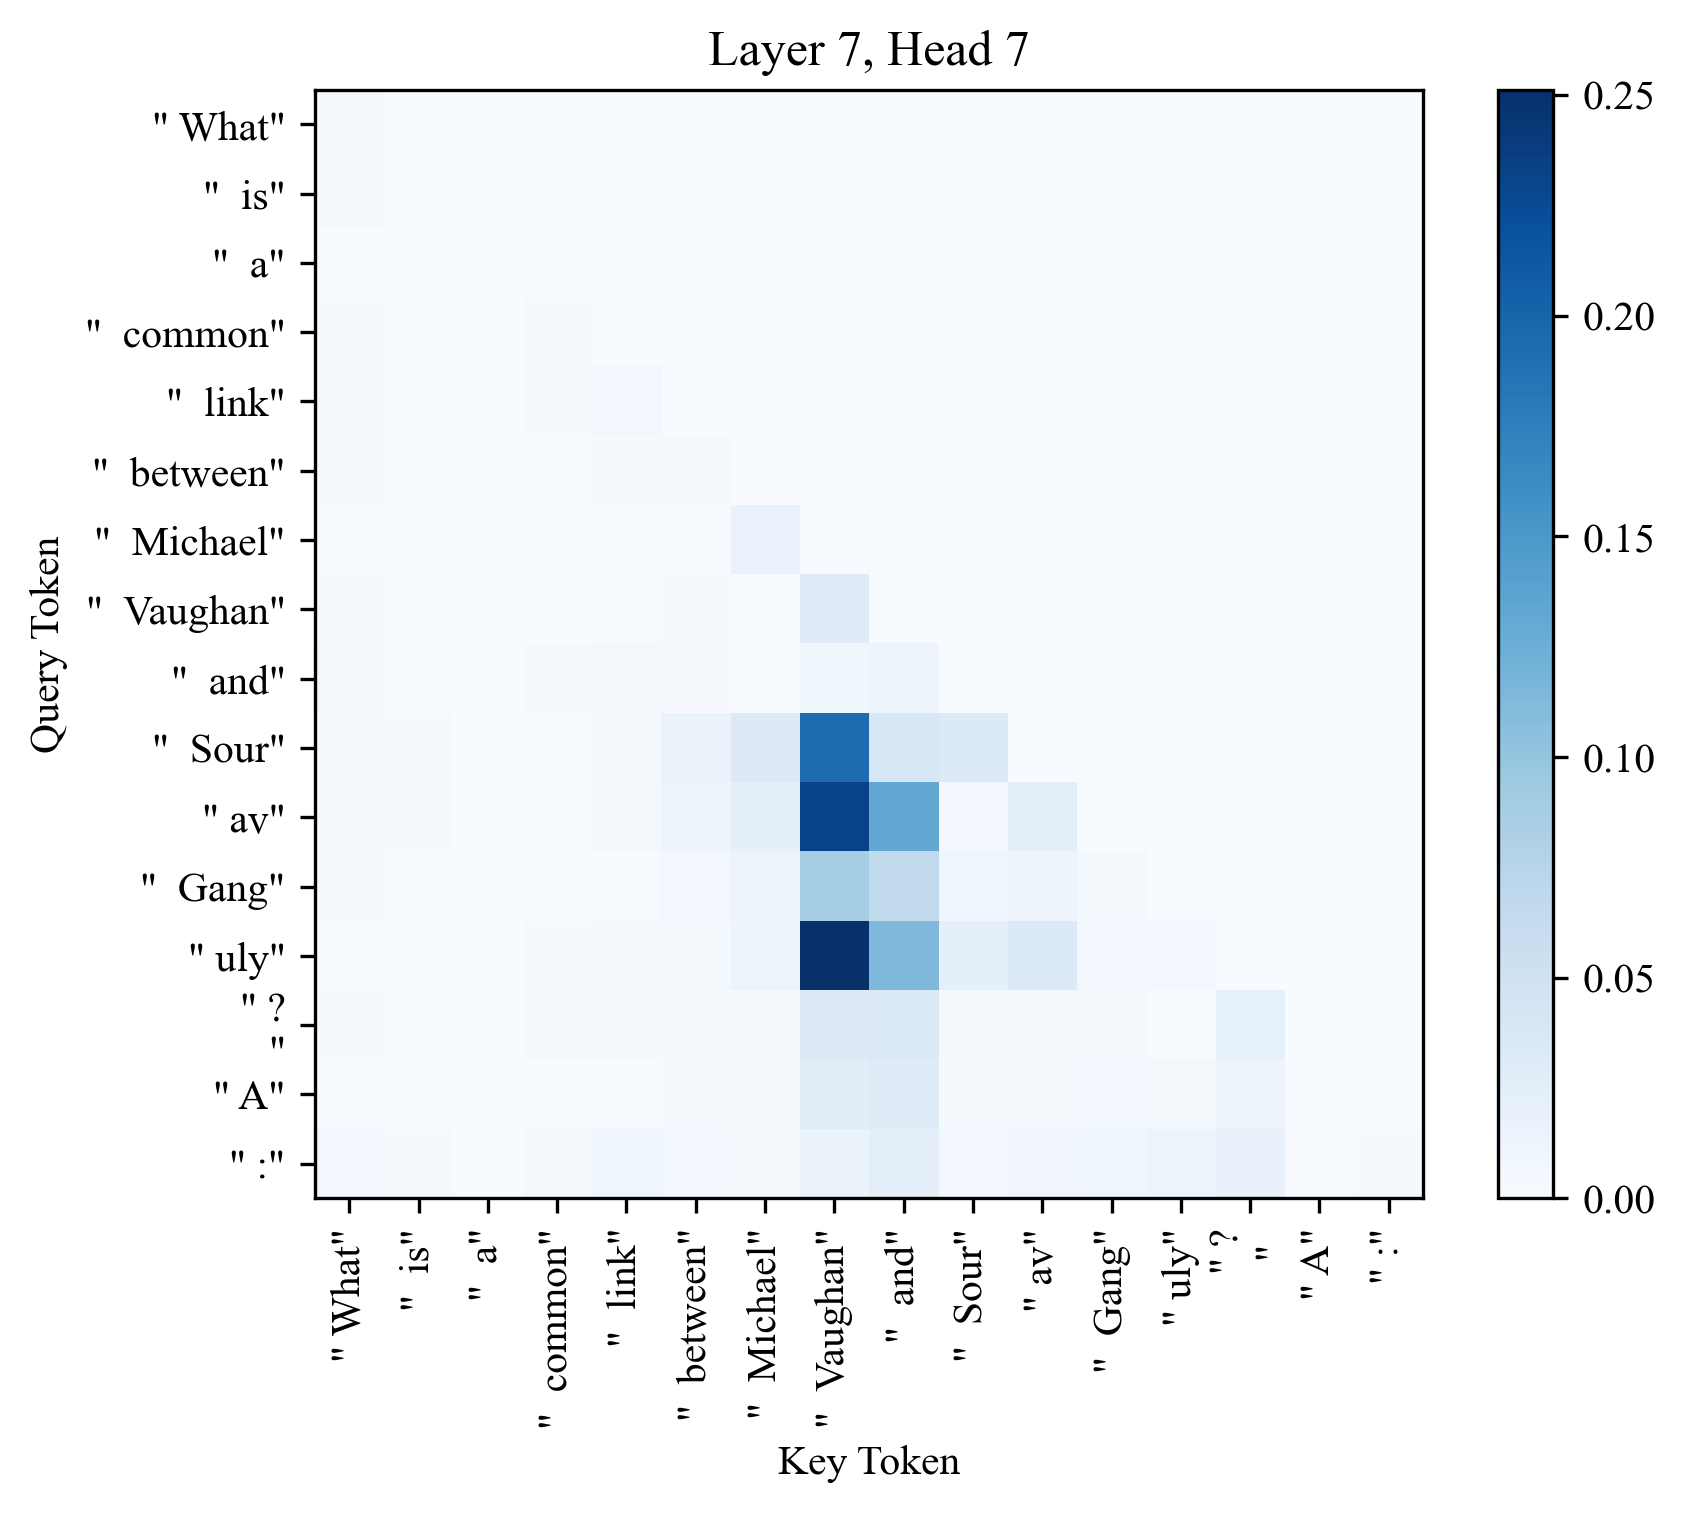

Layer 7, Head 25


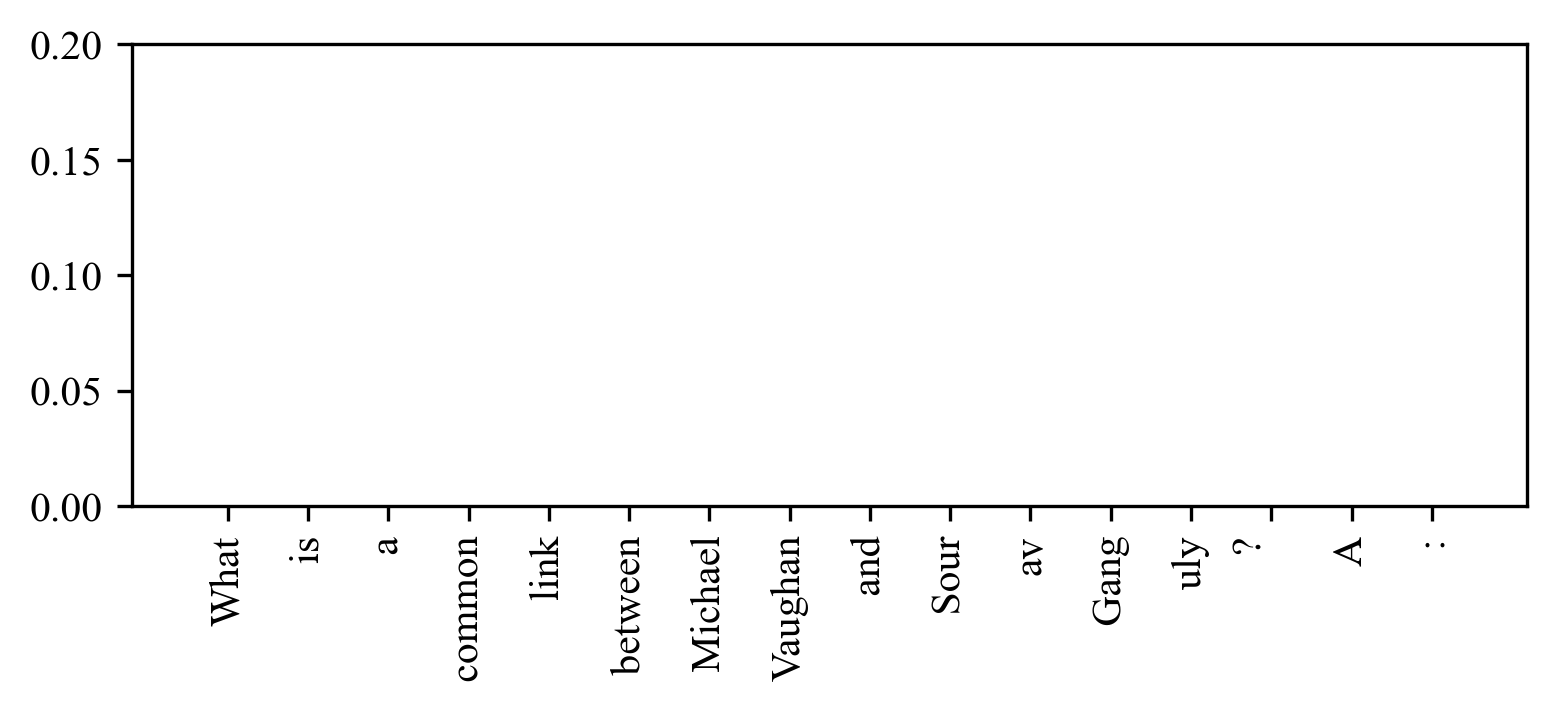

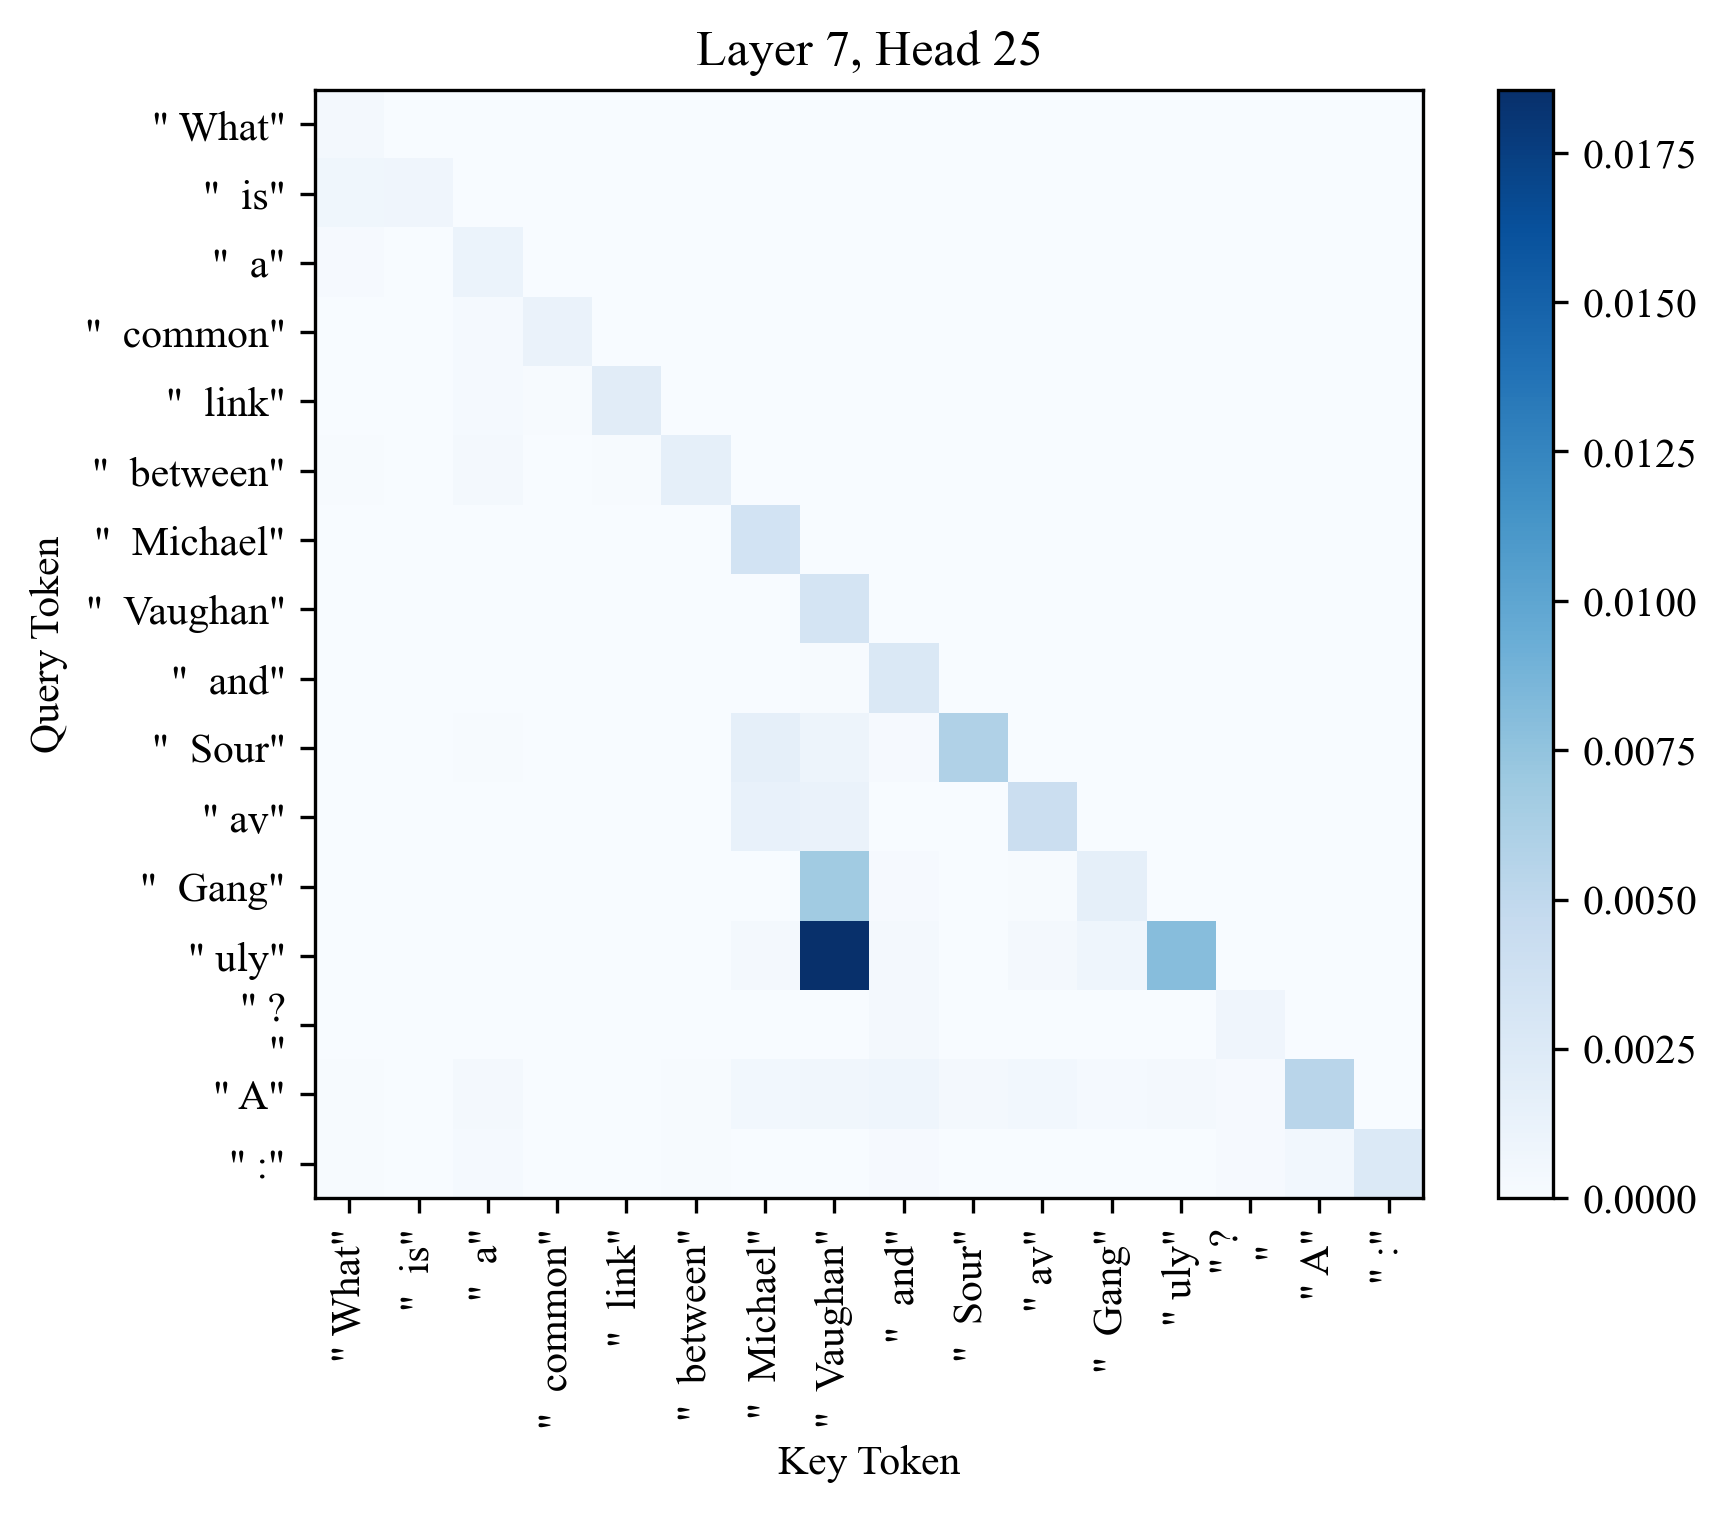

Layer 9, Head 19


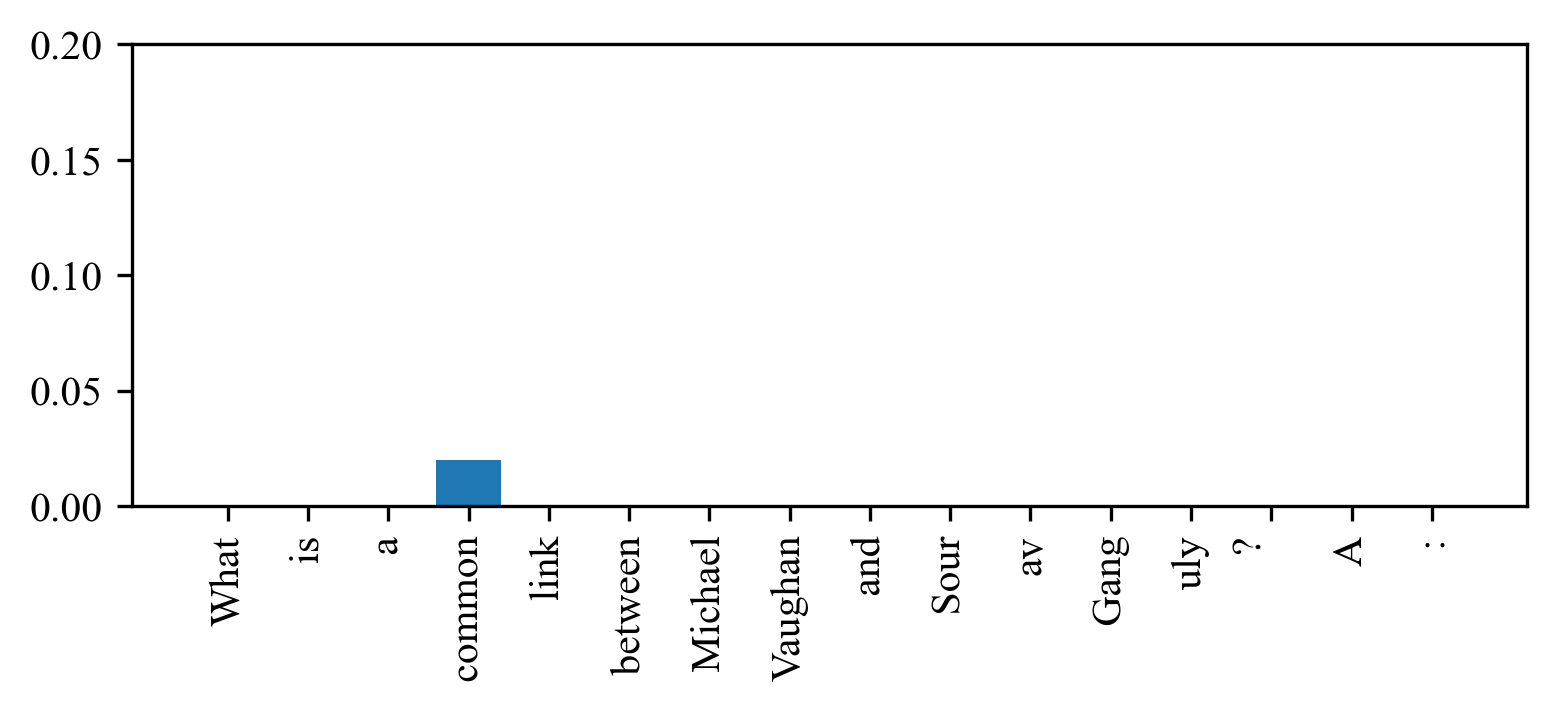

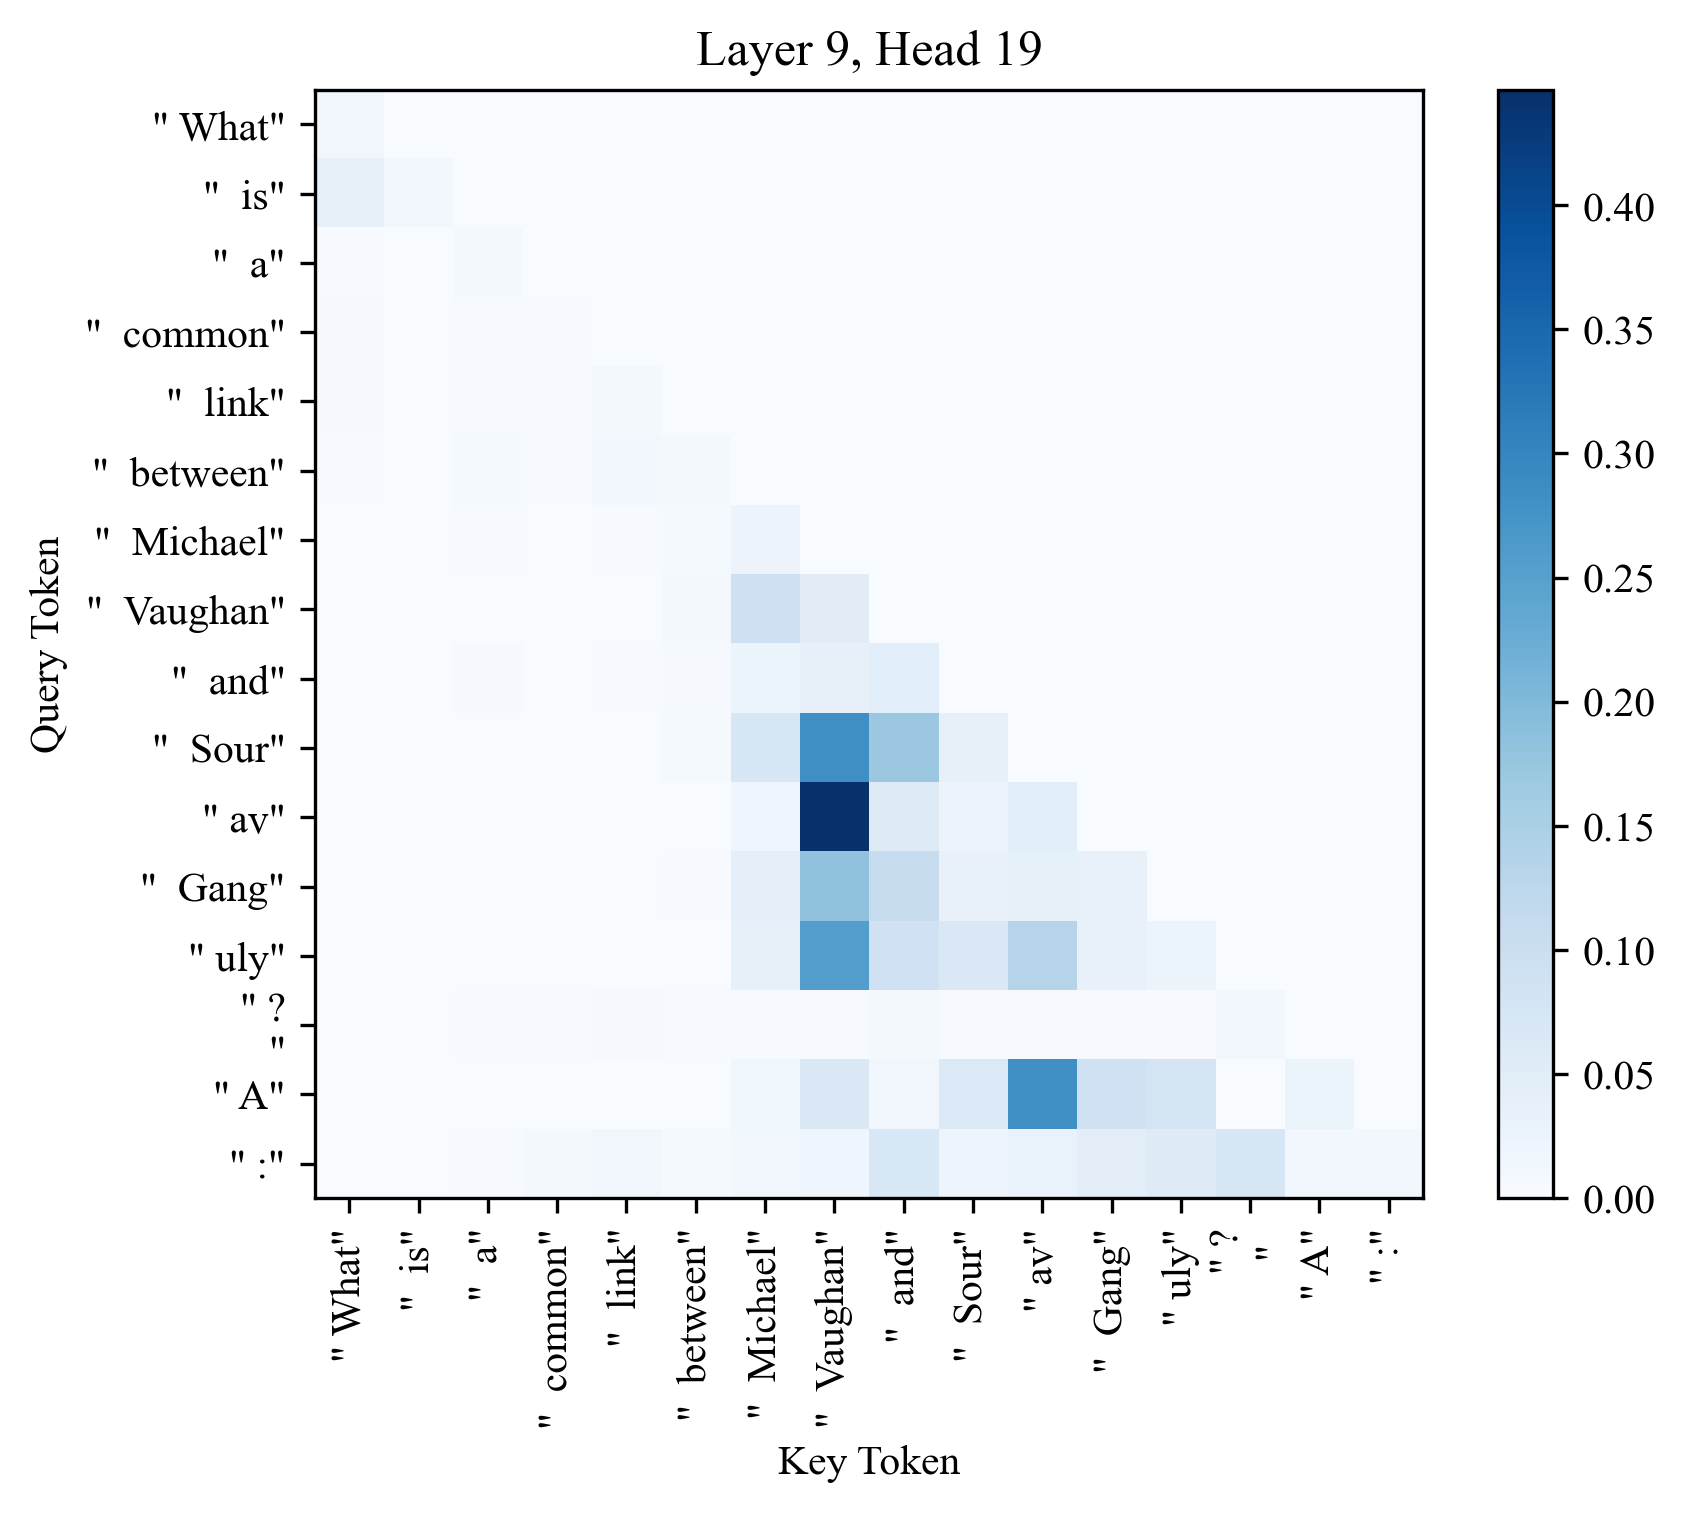

Layer 8, Head 17


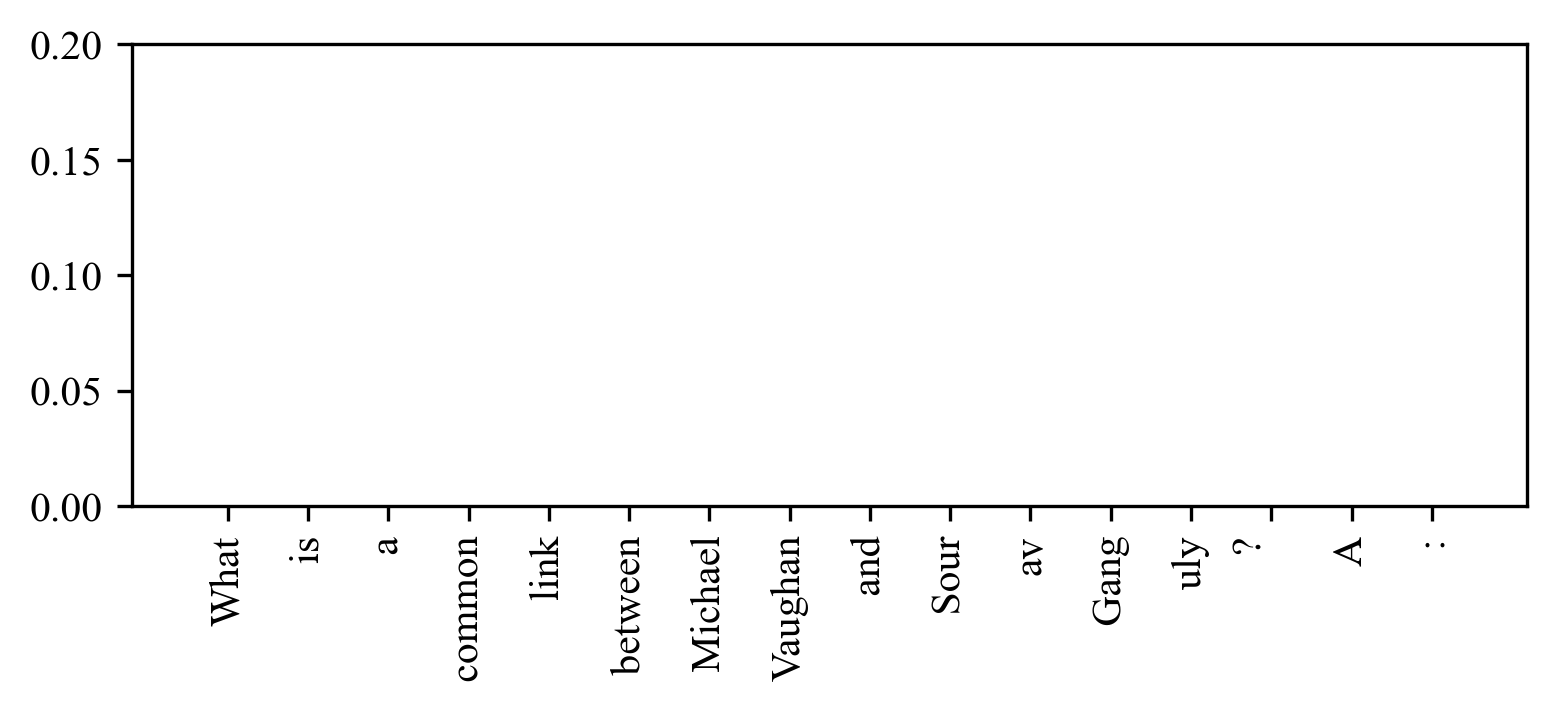

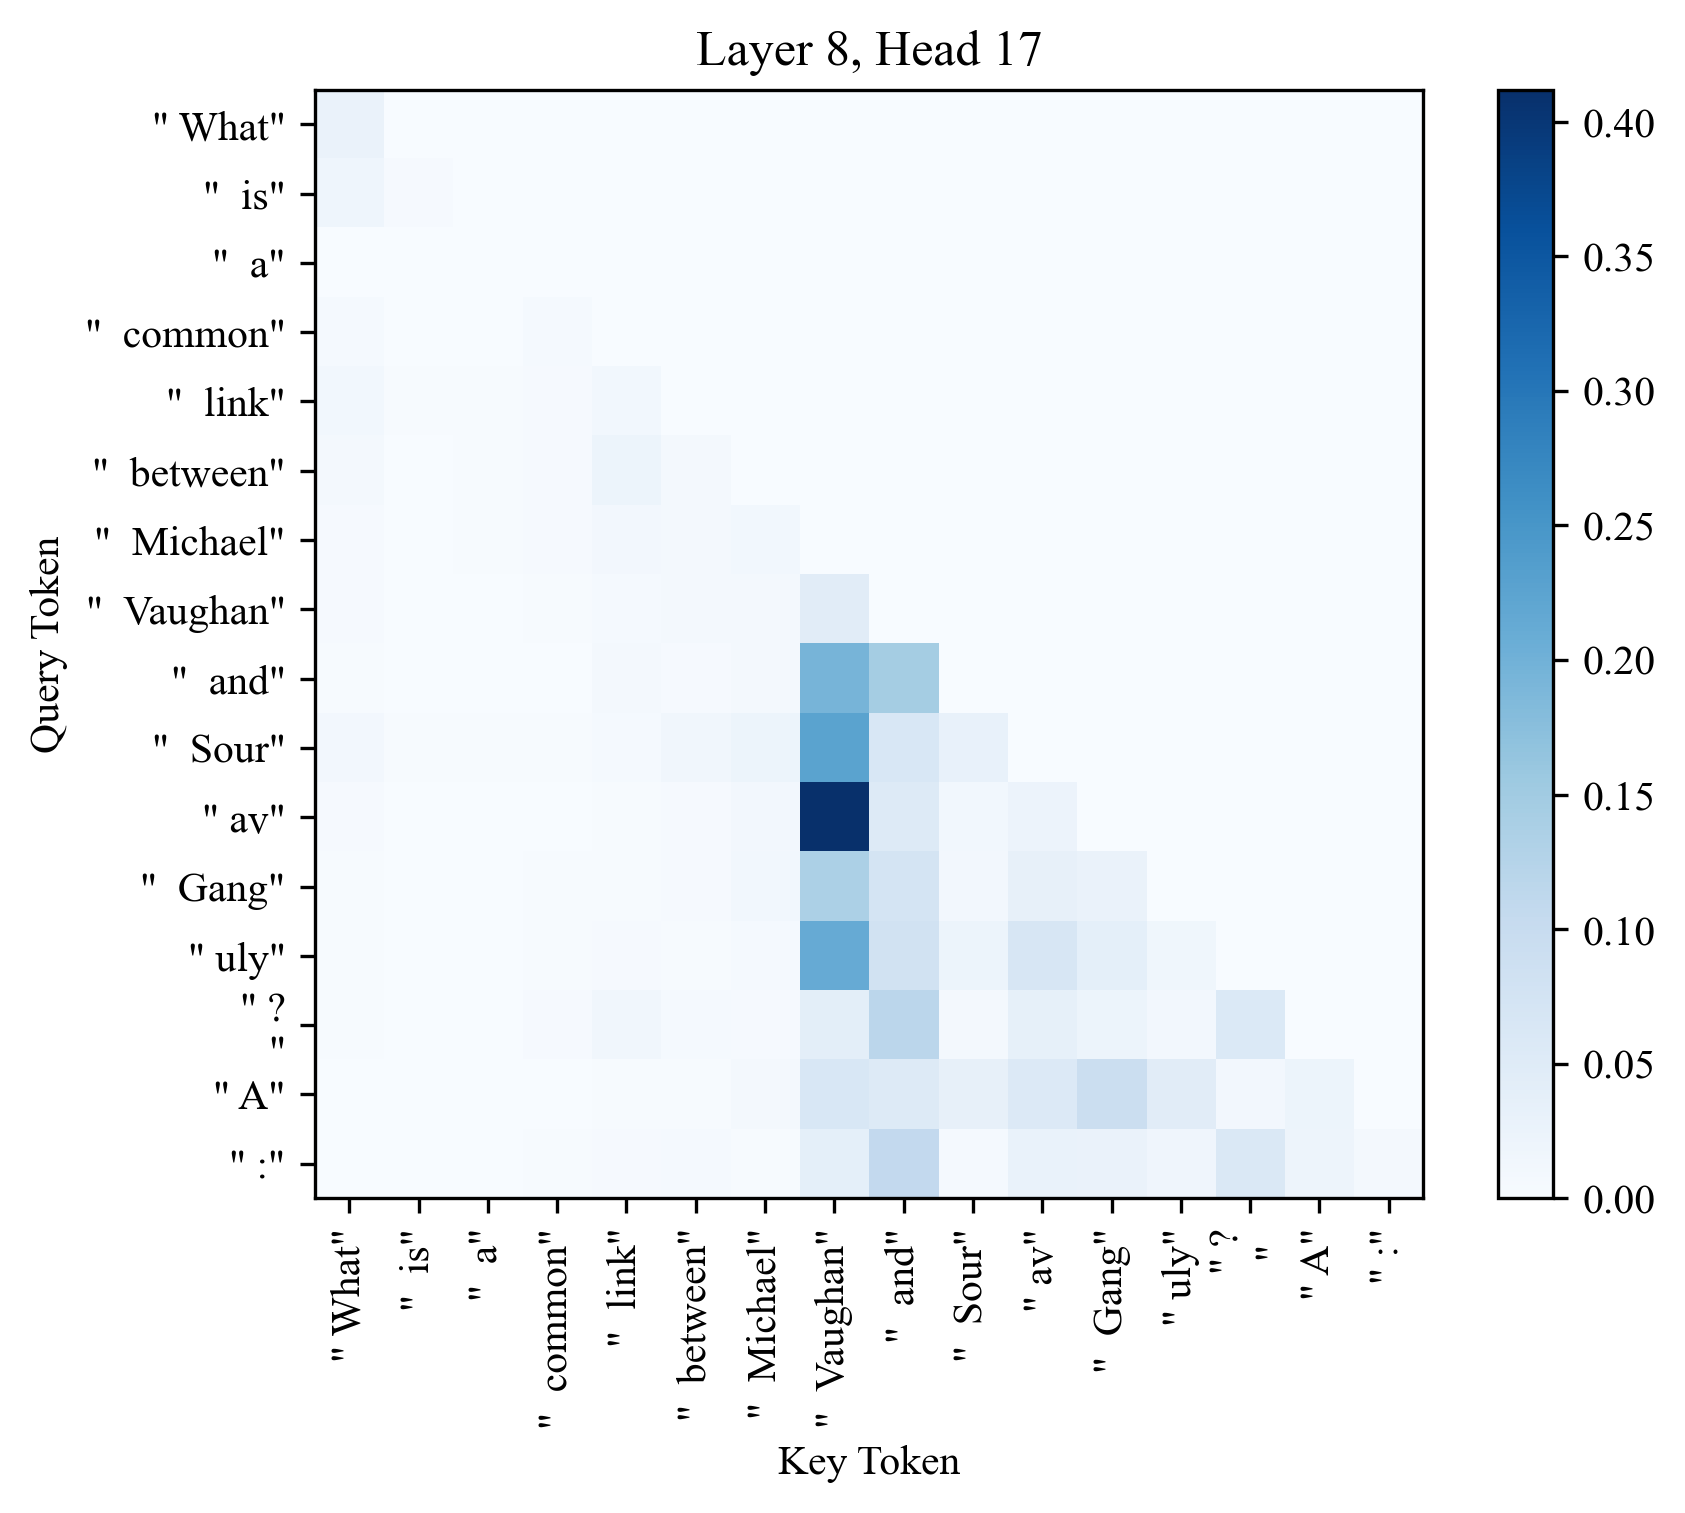

Layer 8, Head 18


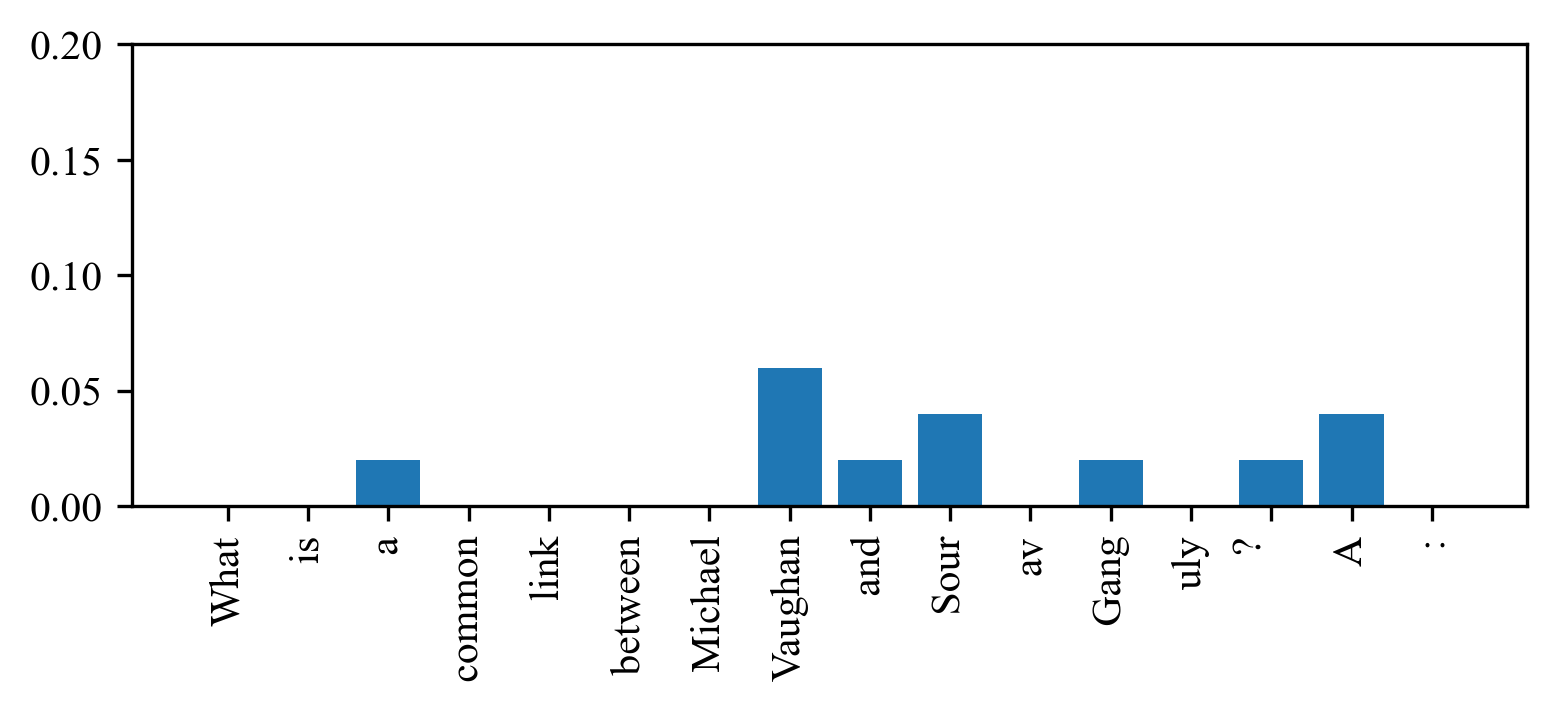

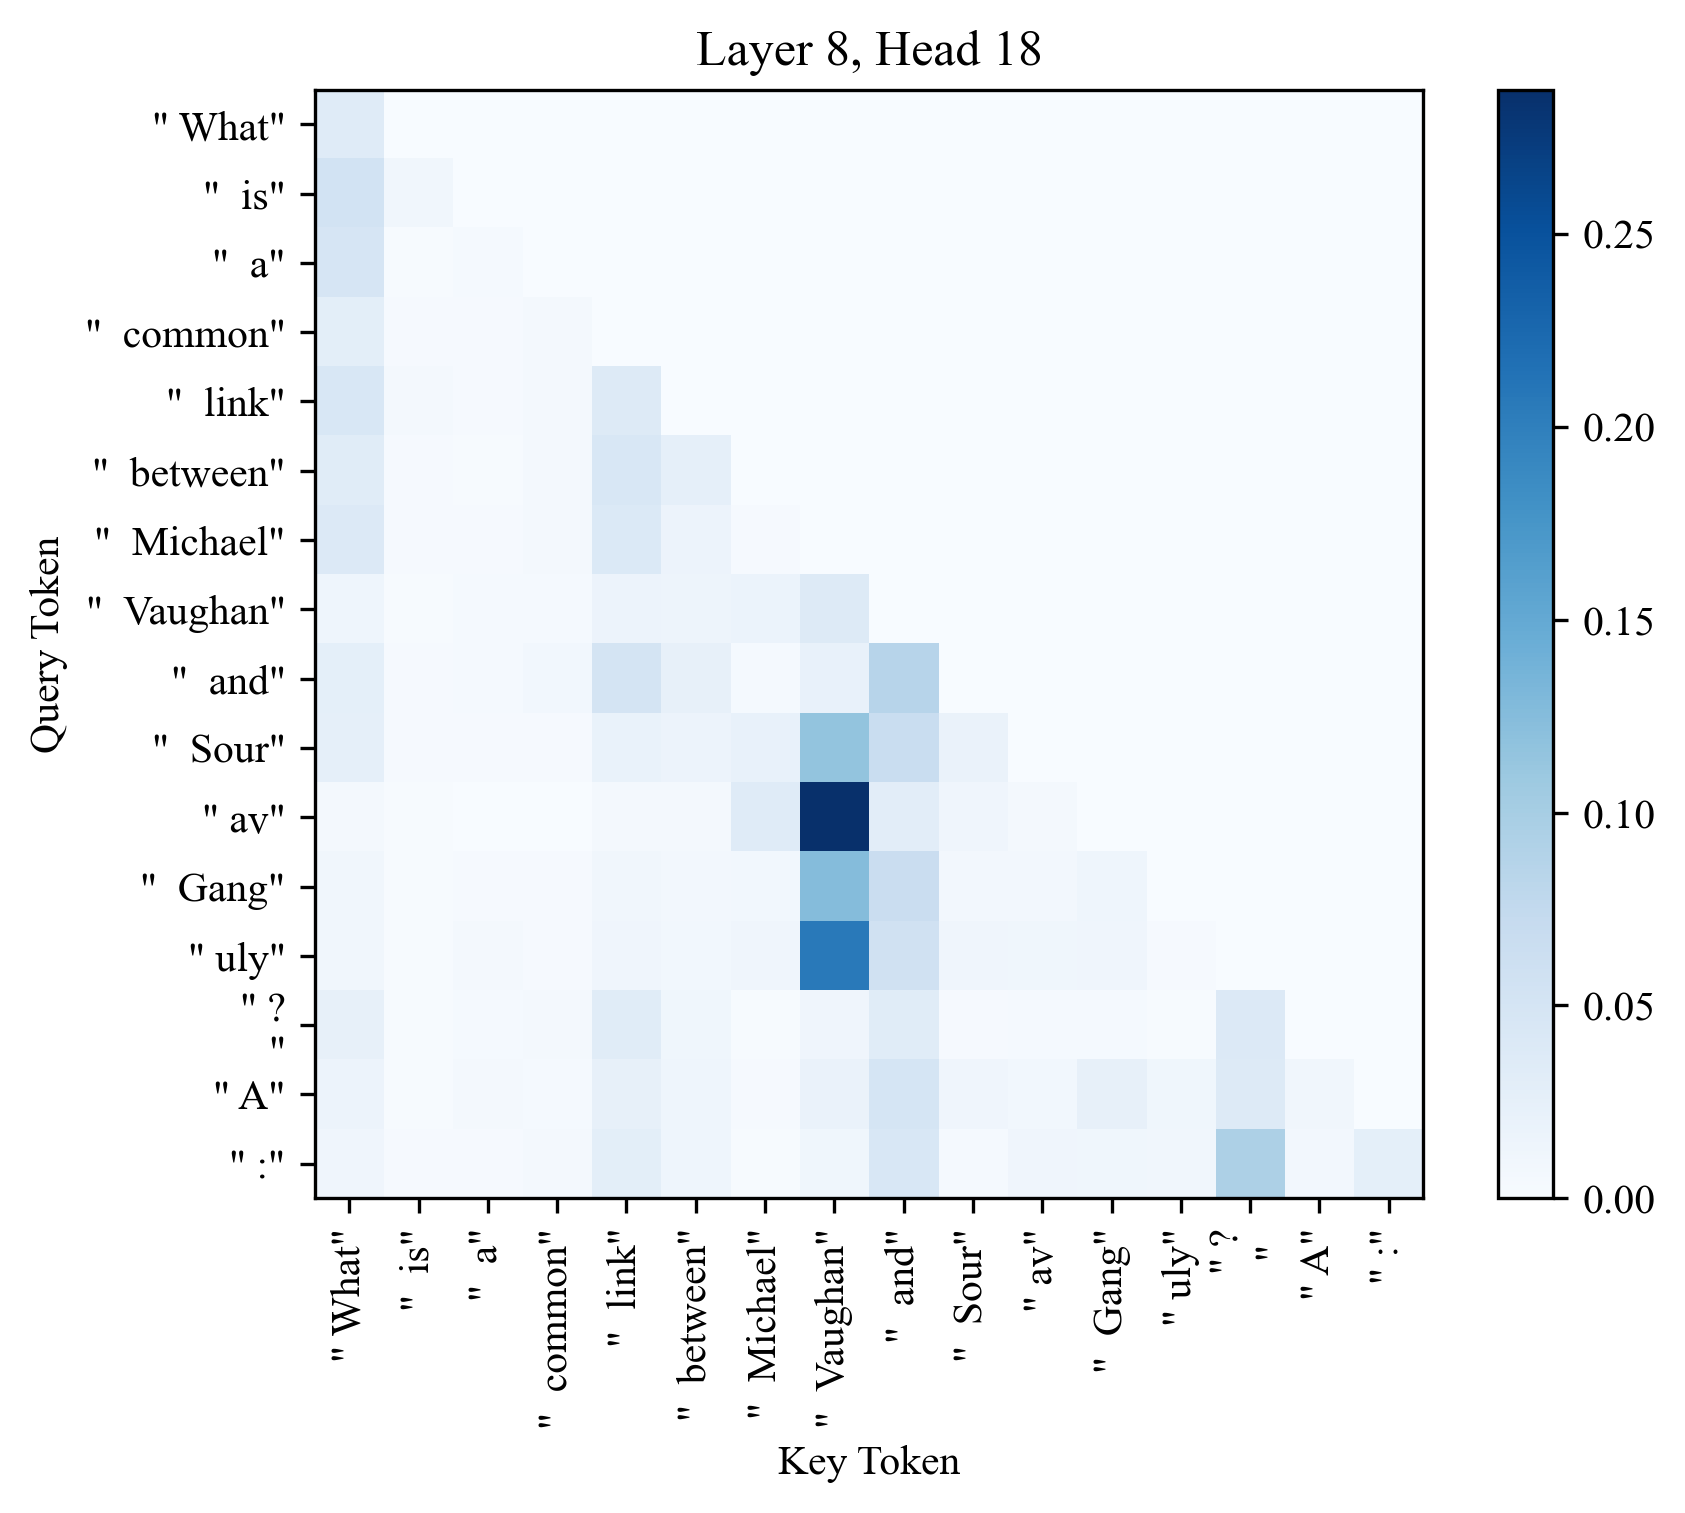

Layer 10, Head 7


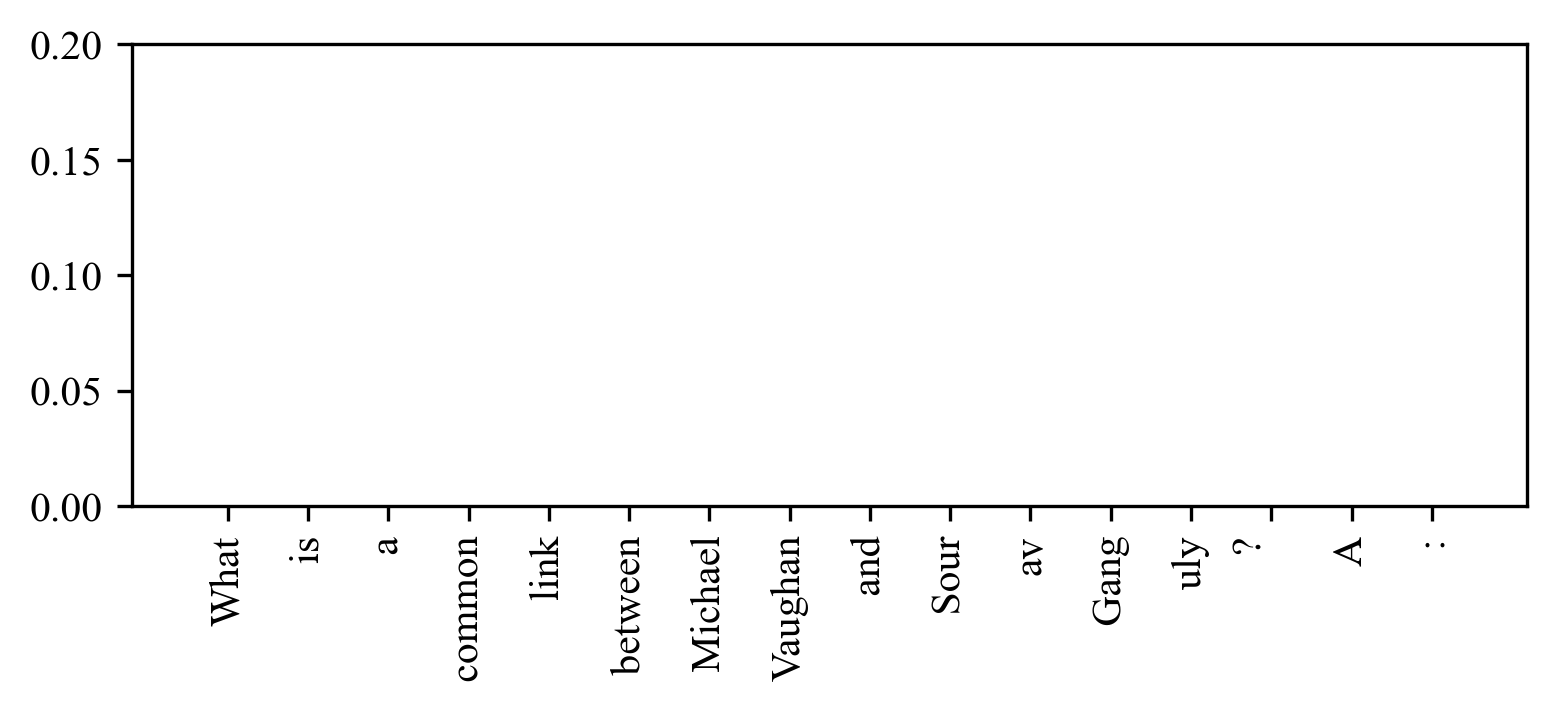

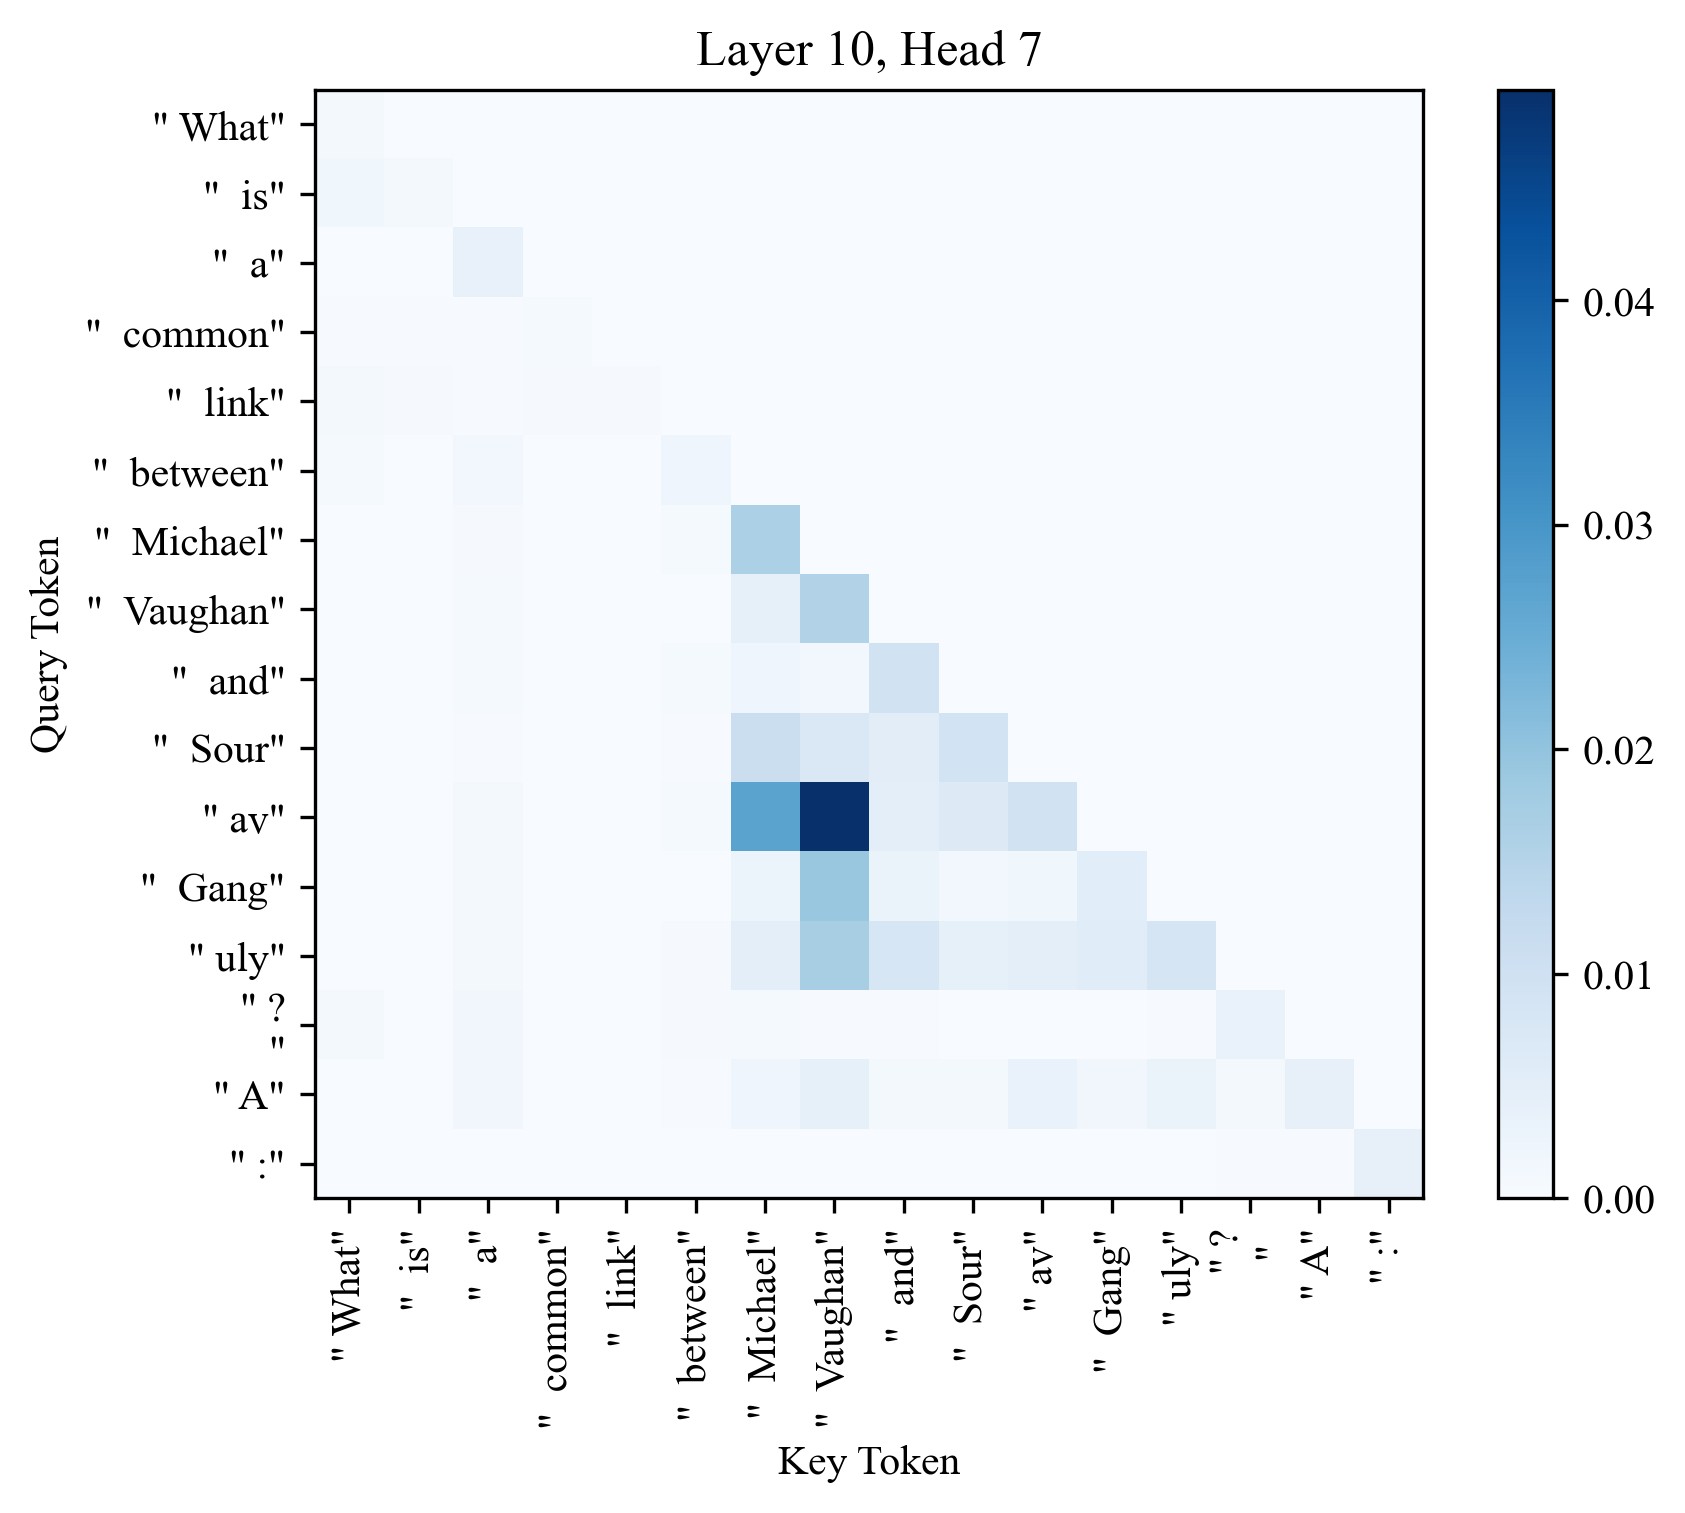

Layer 15, Head 6


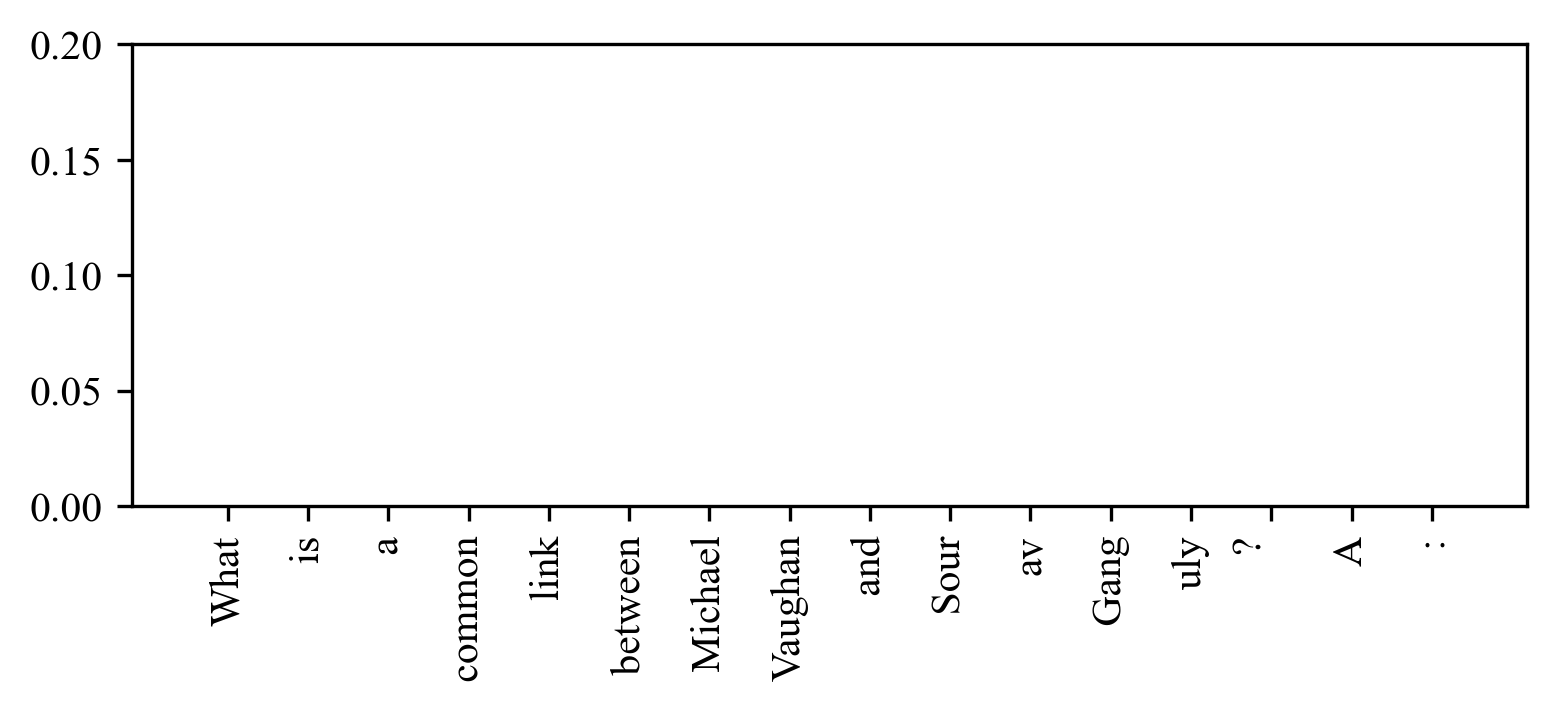

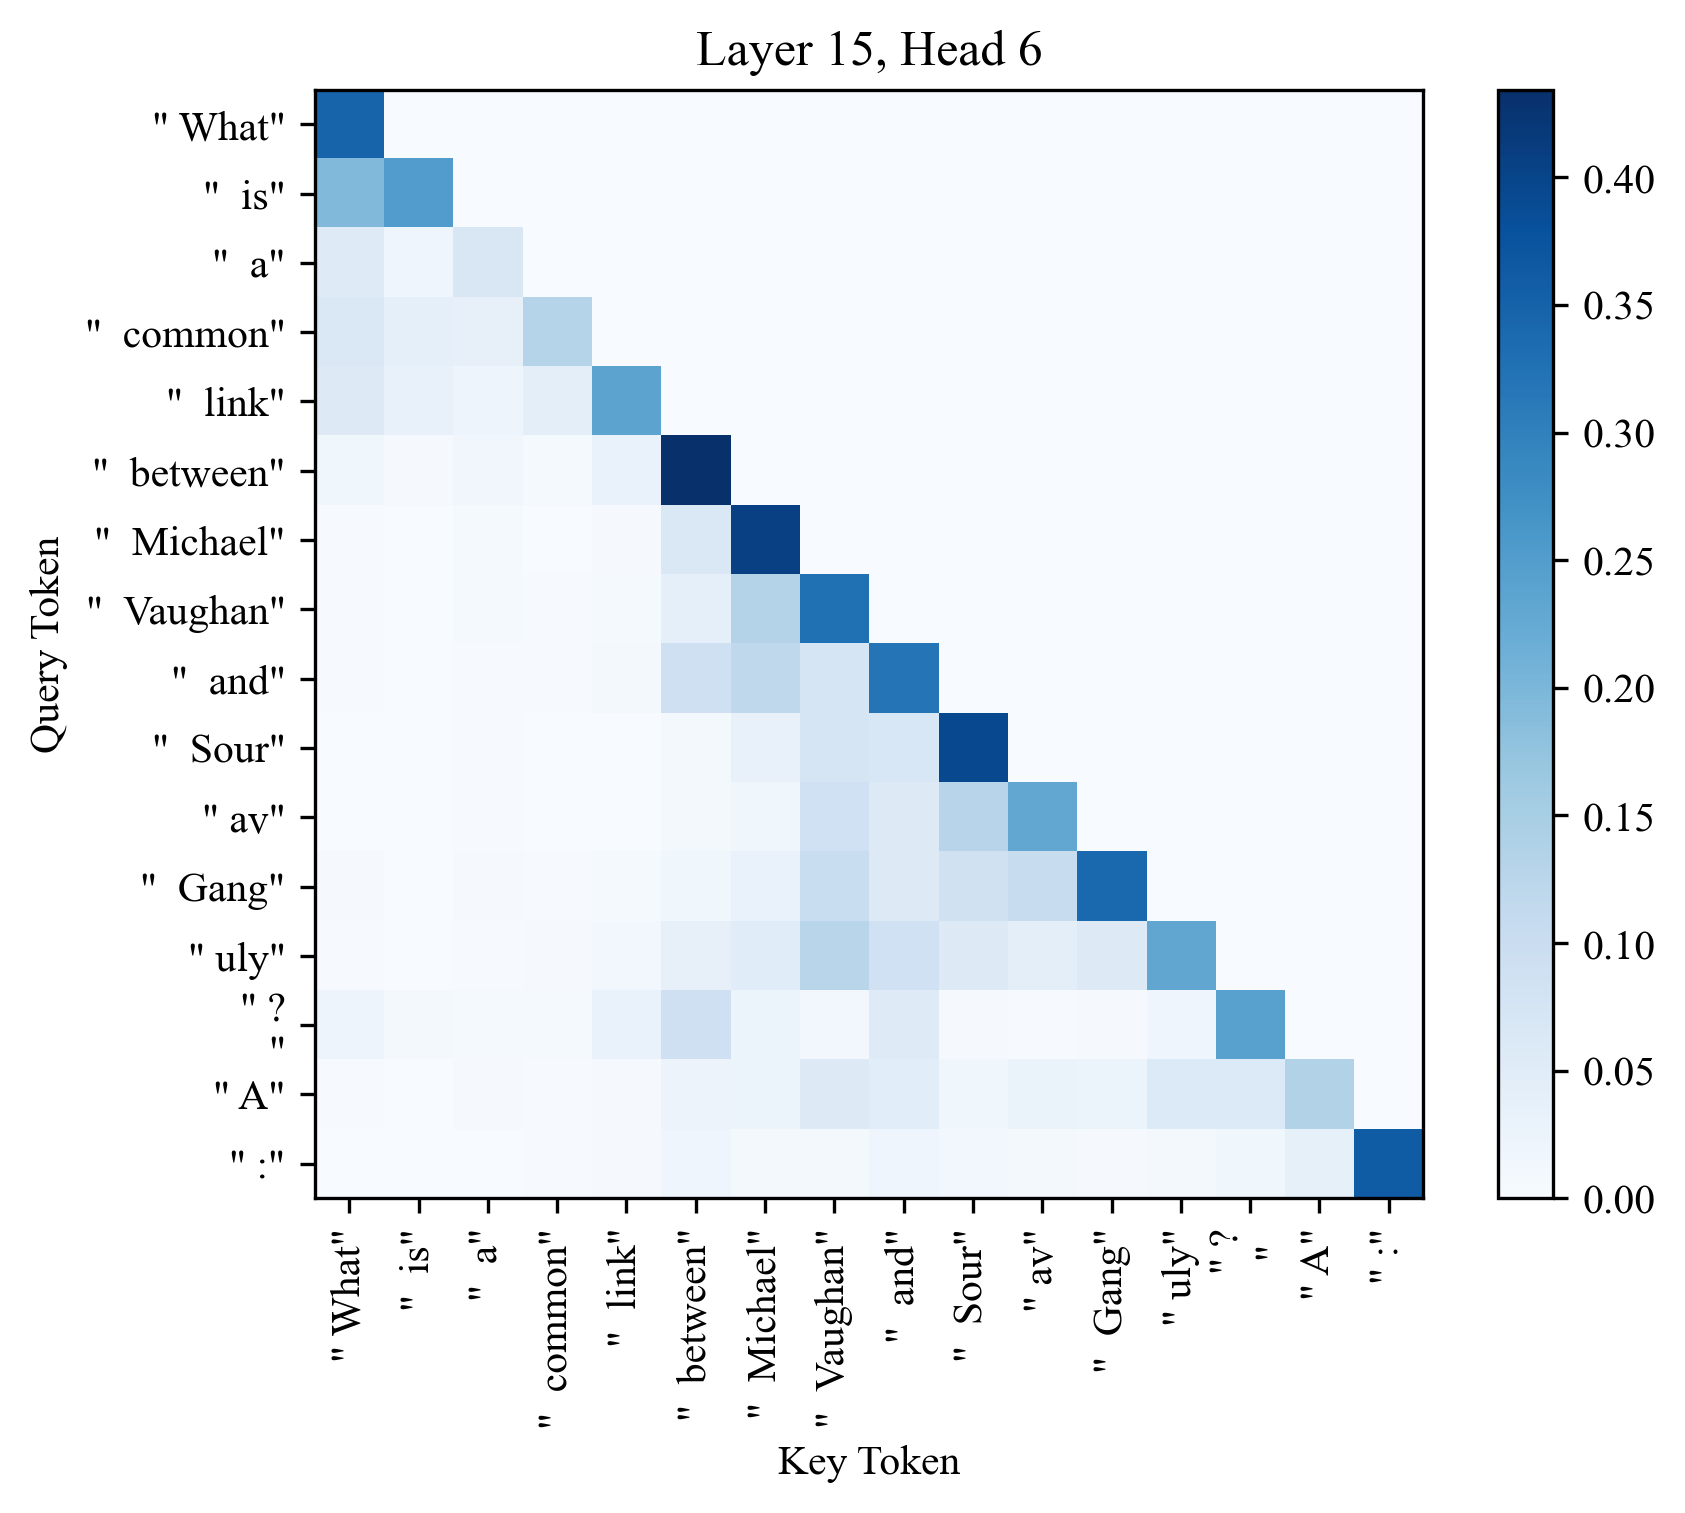

Layer 15, Head 11


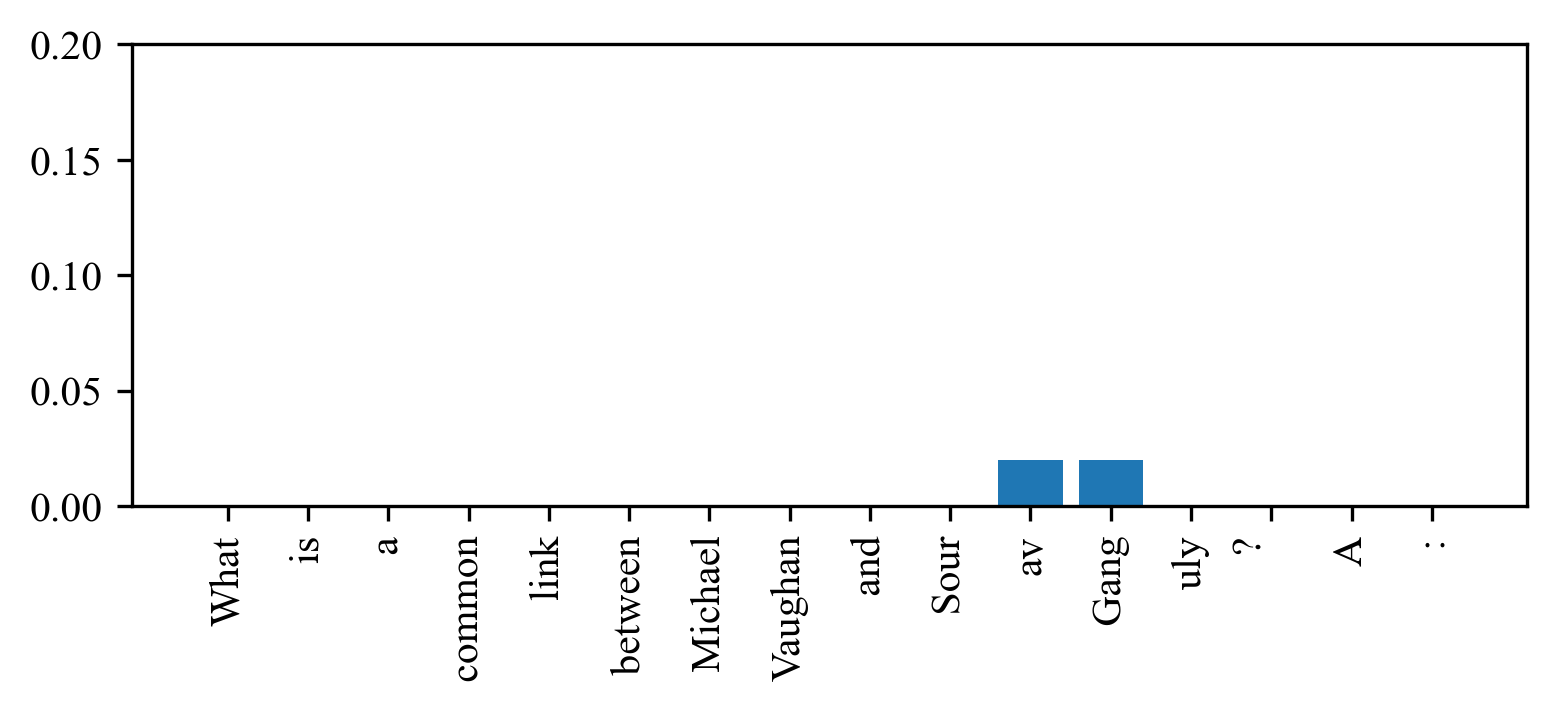

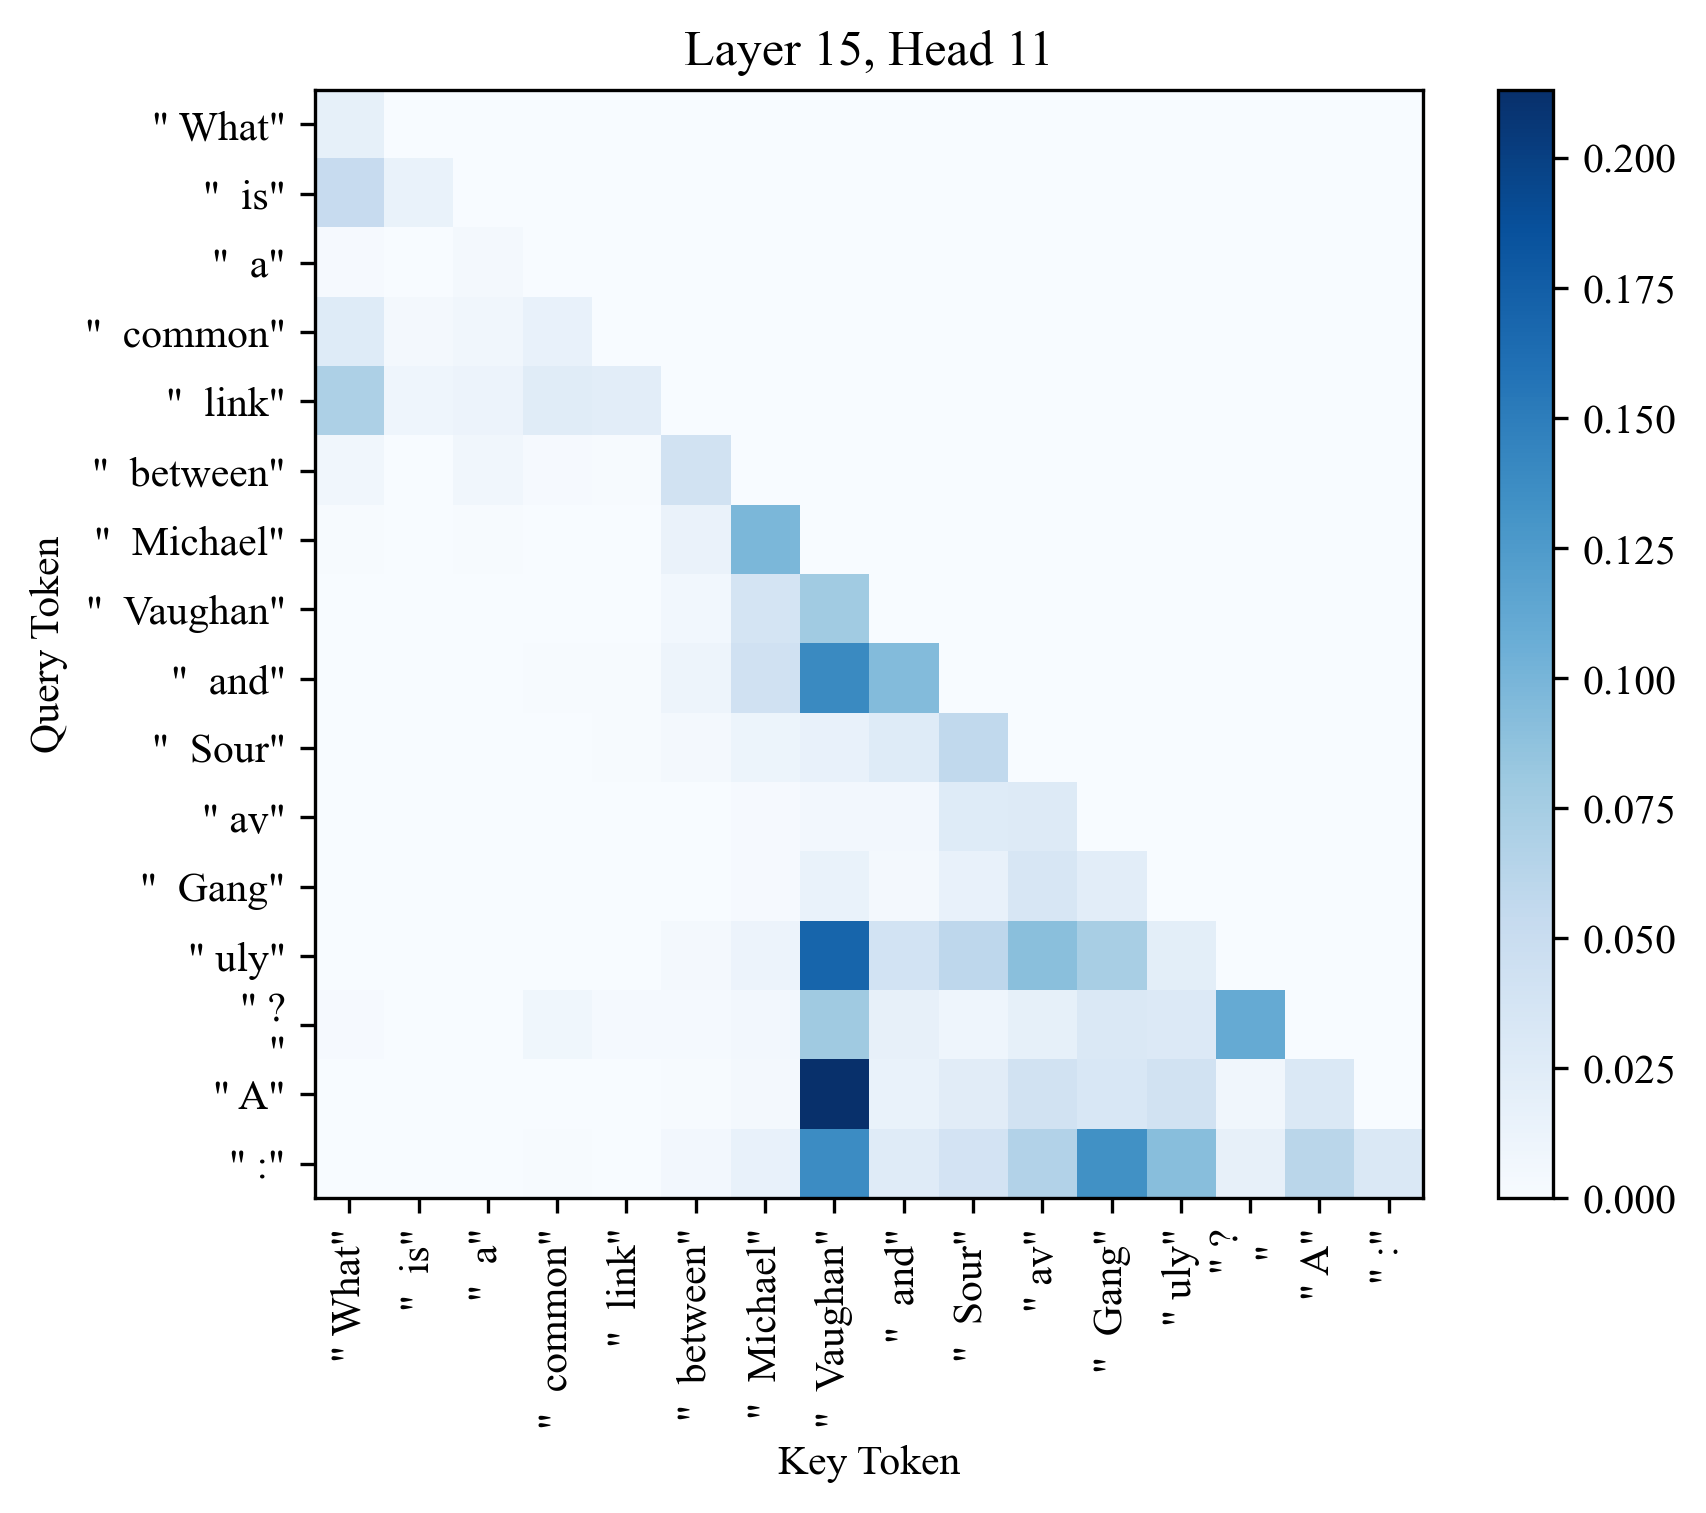

Layer 14, Head 10


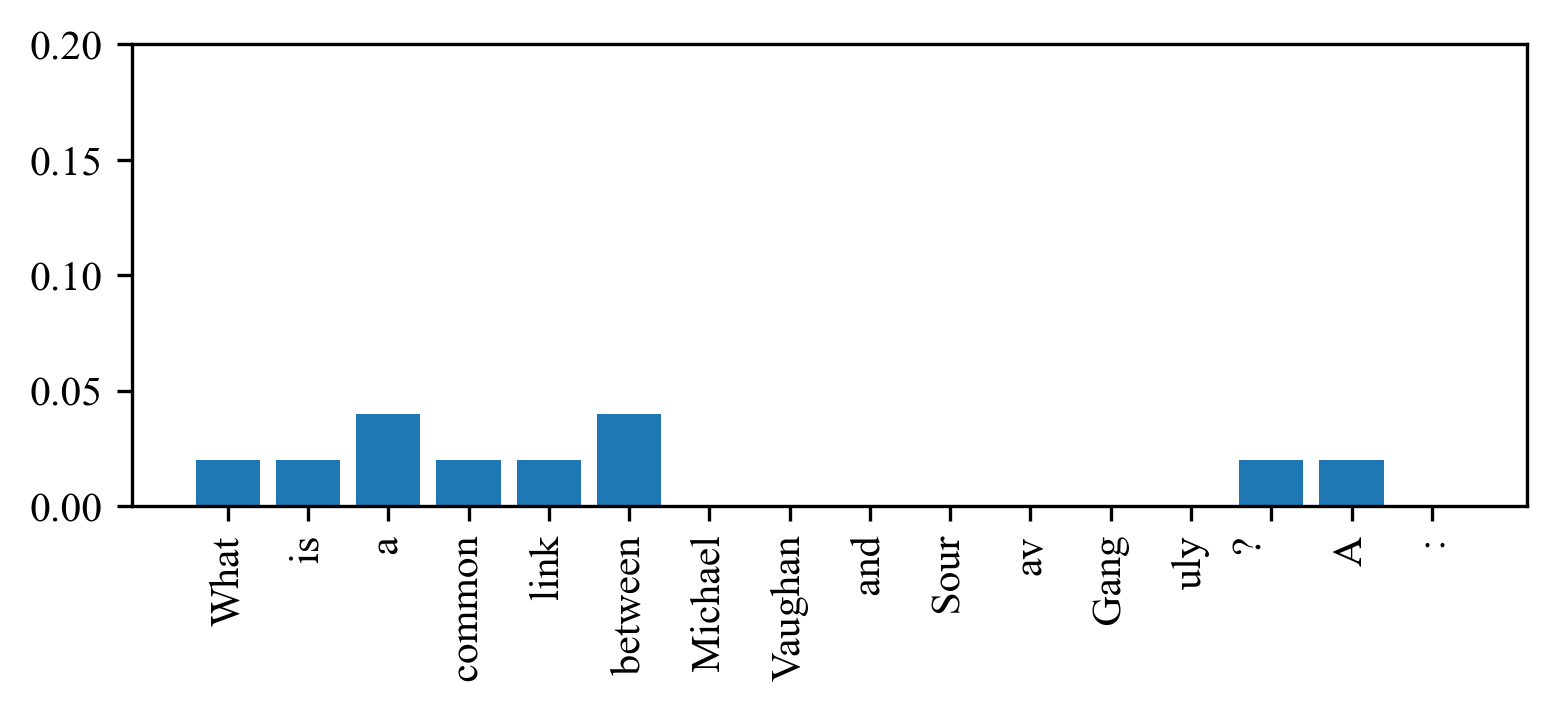

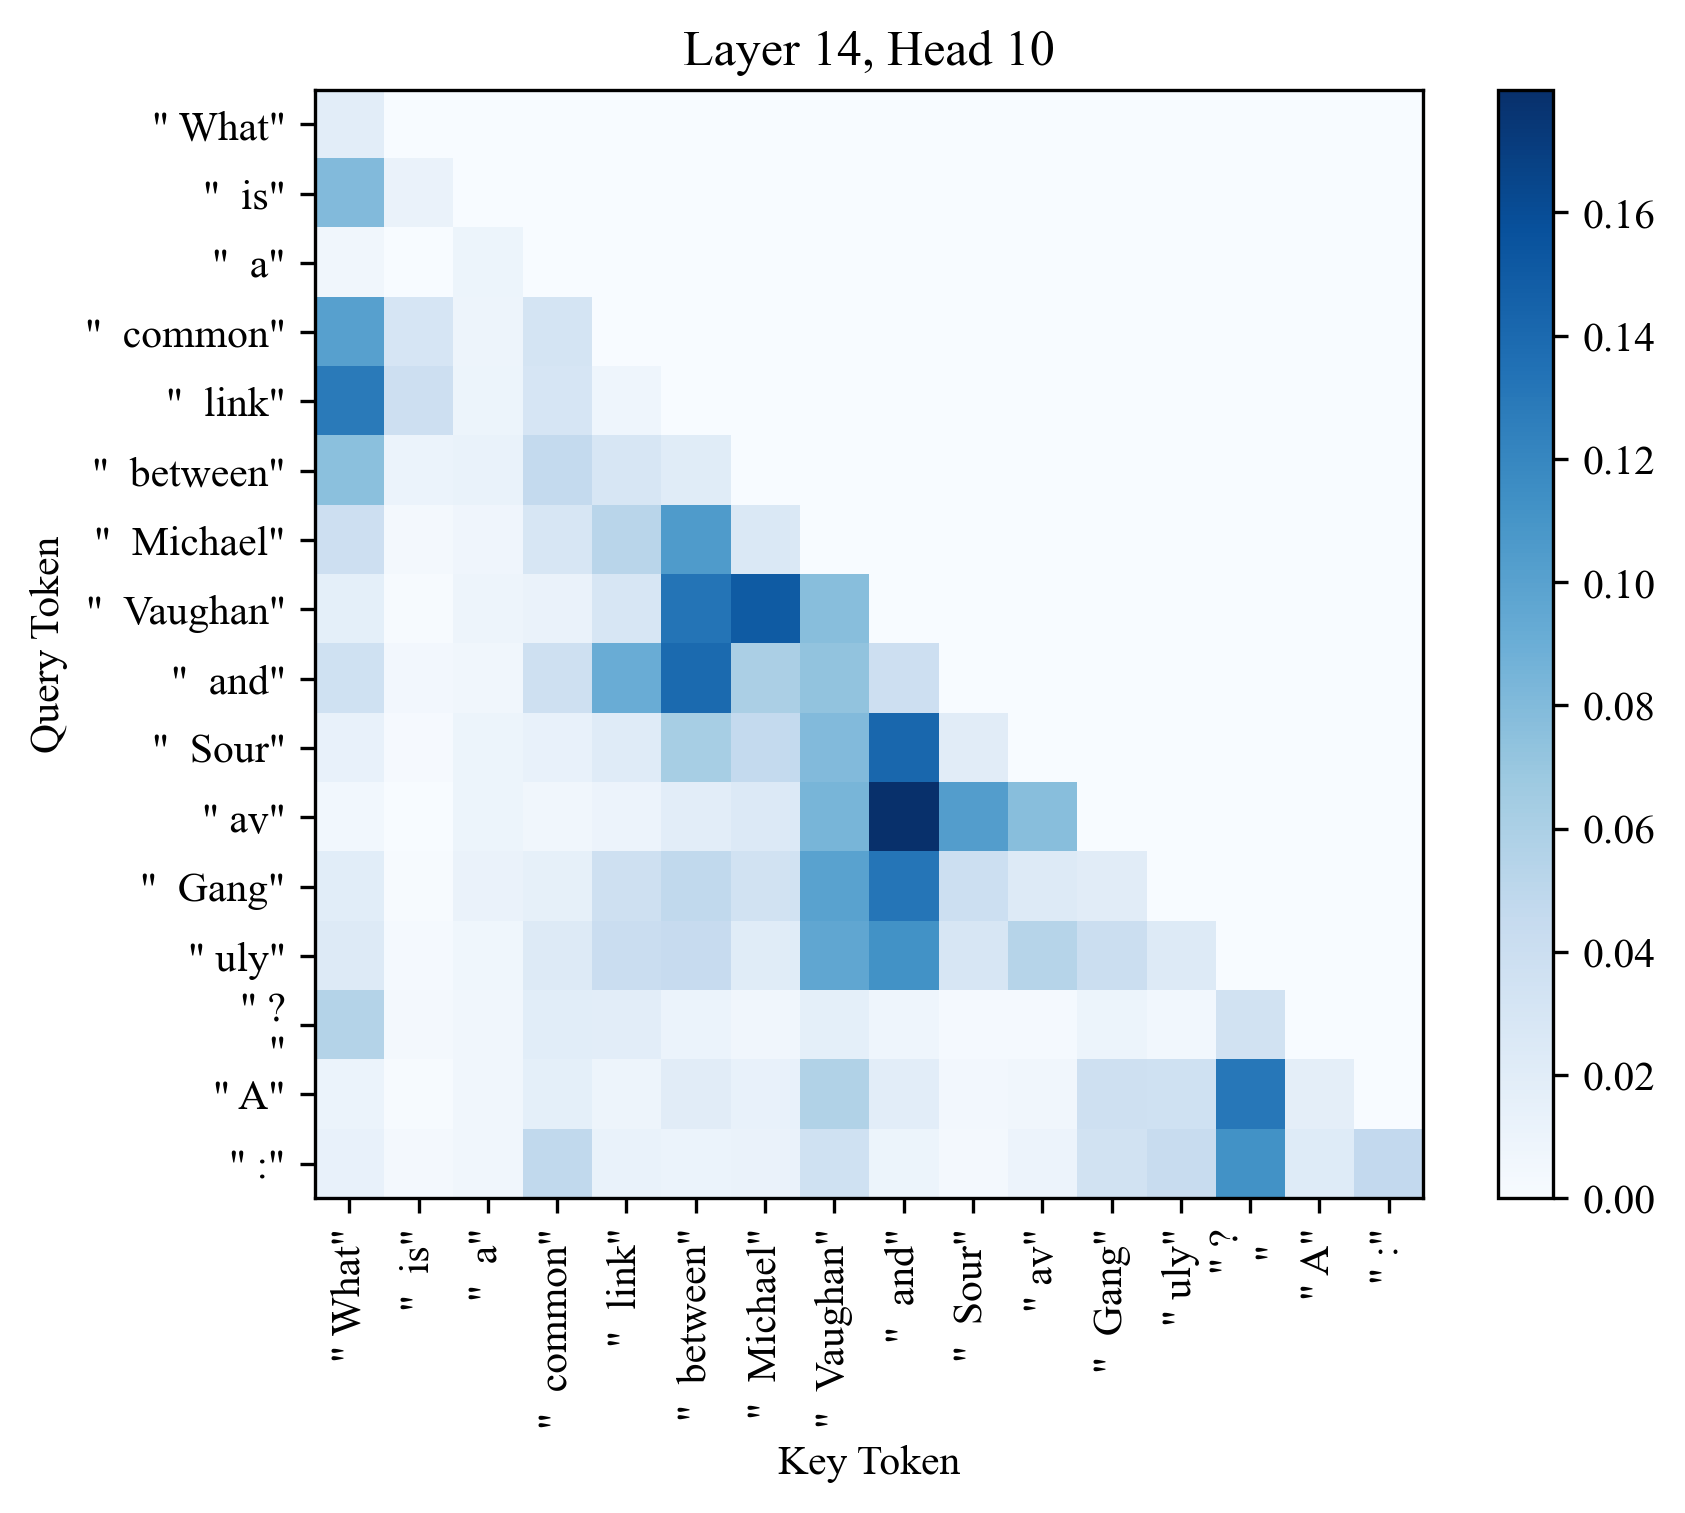

Layer 14, Head 11


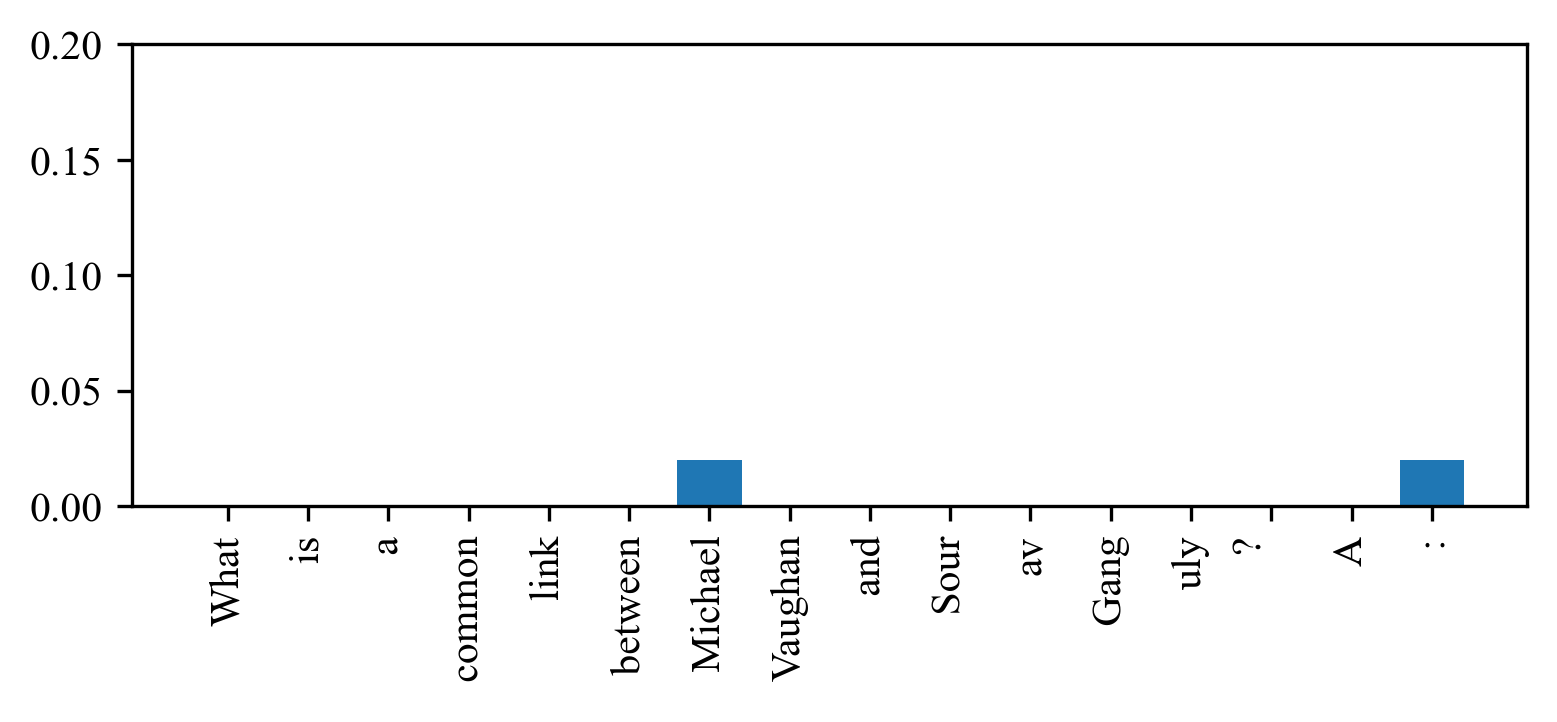

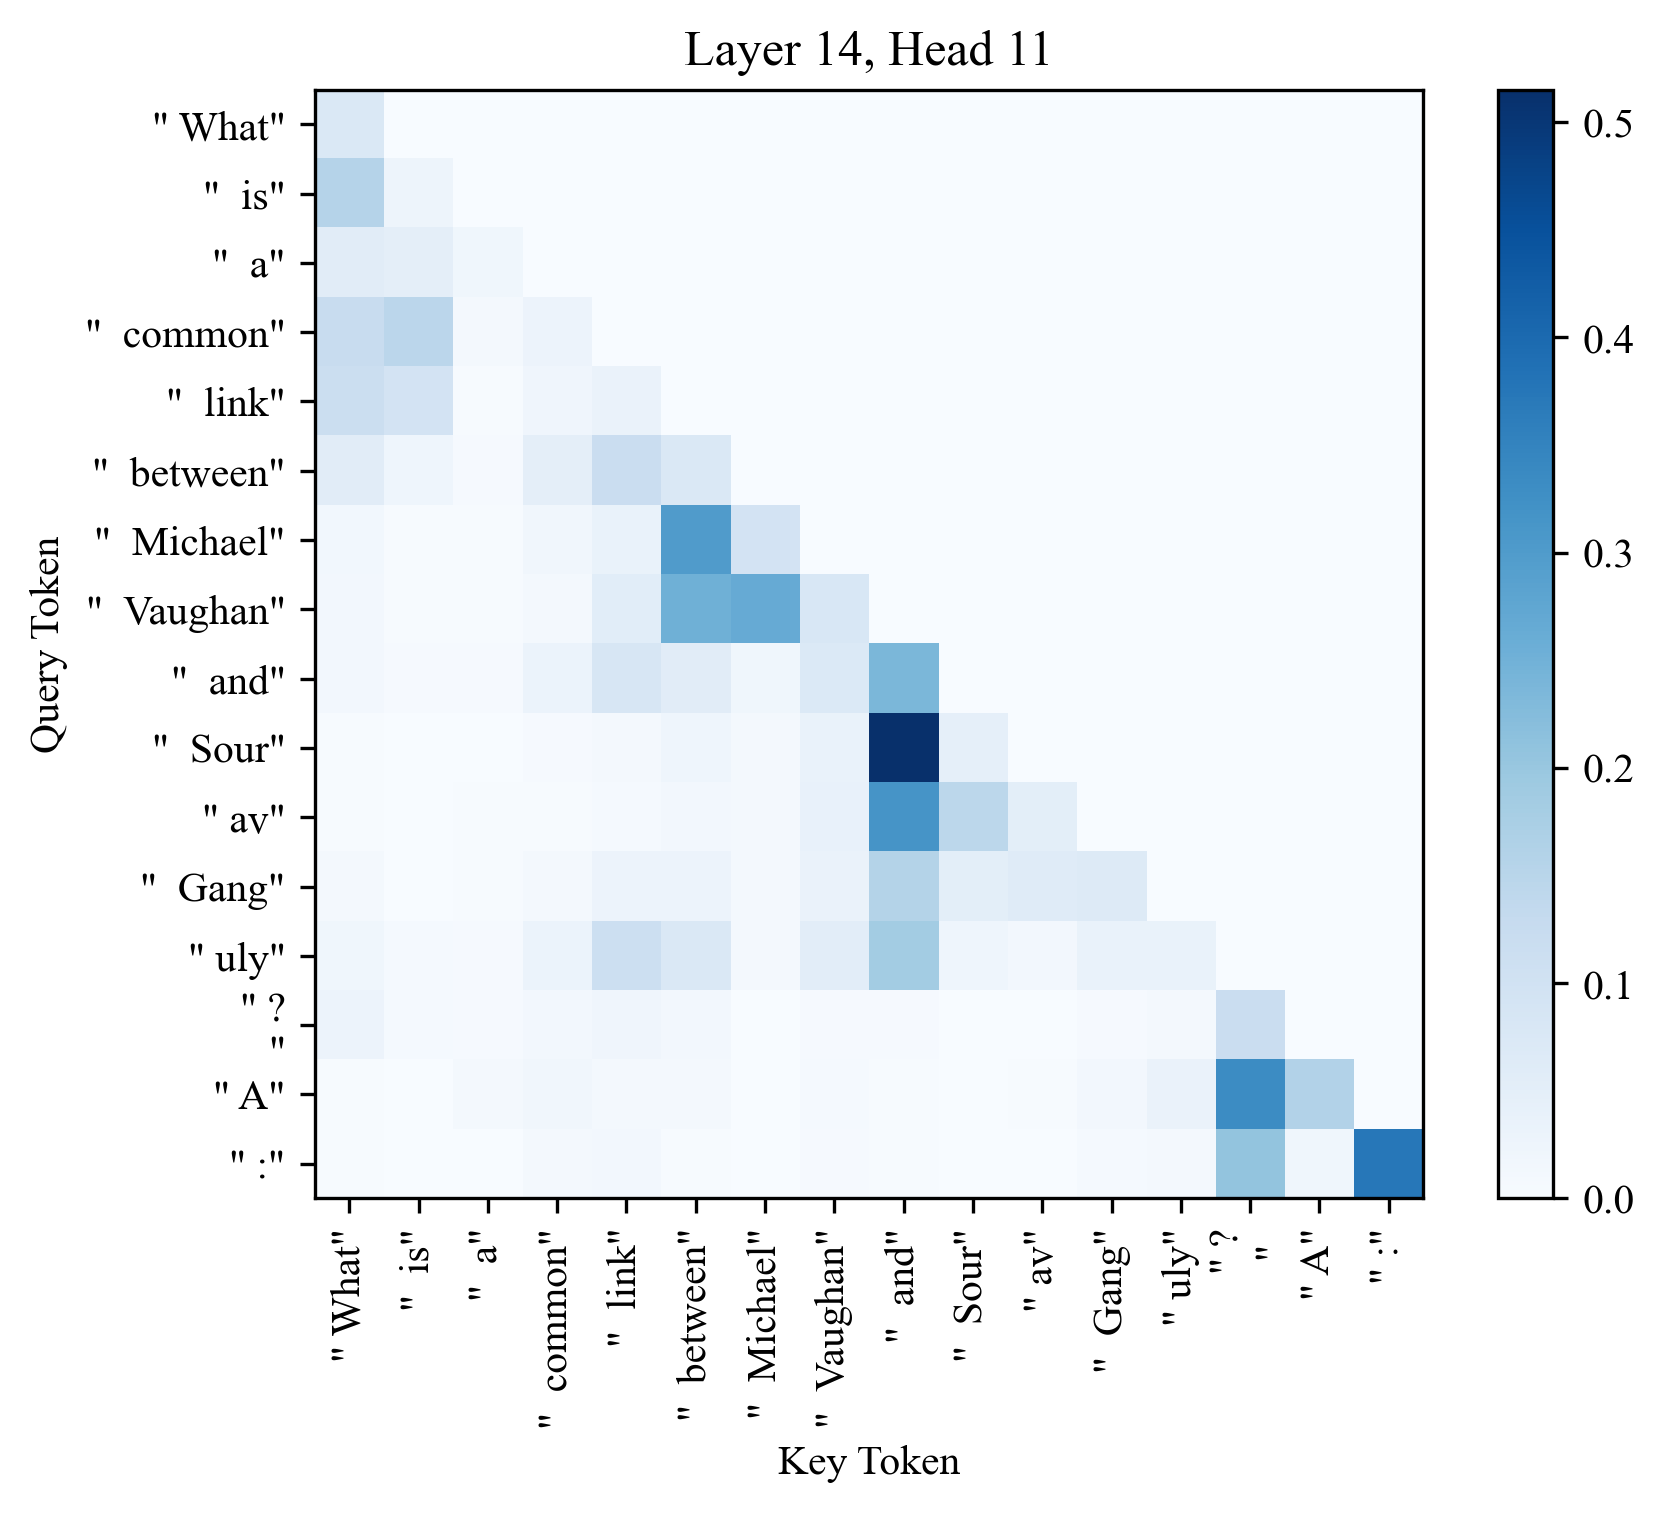

Layer 4, Head 9


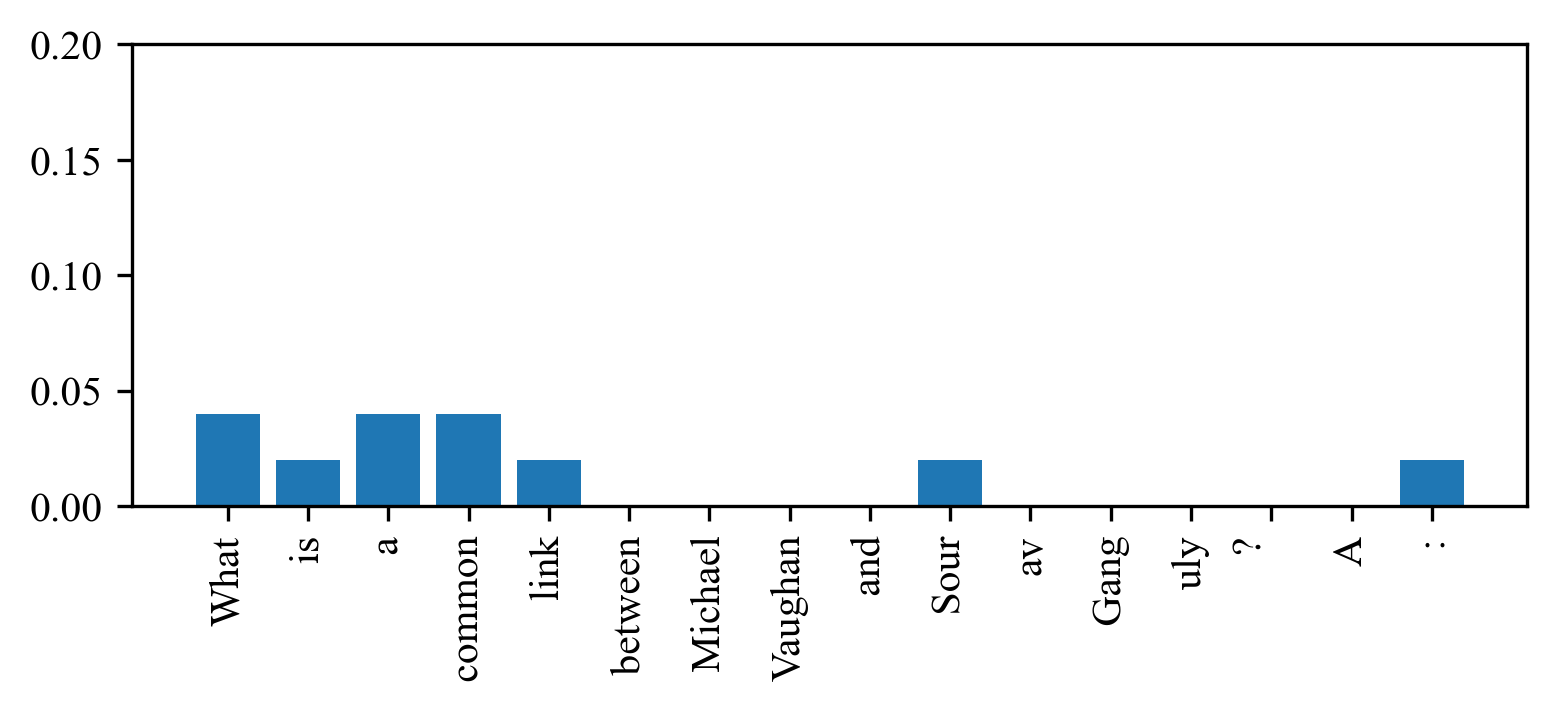

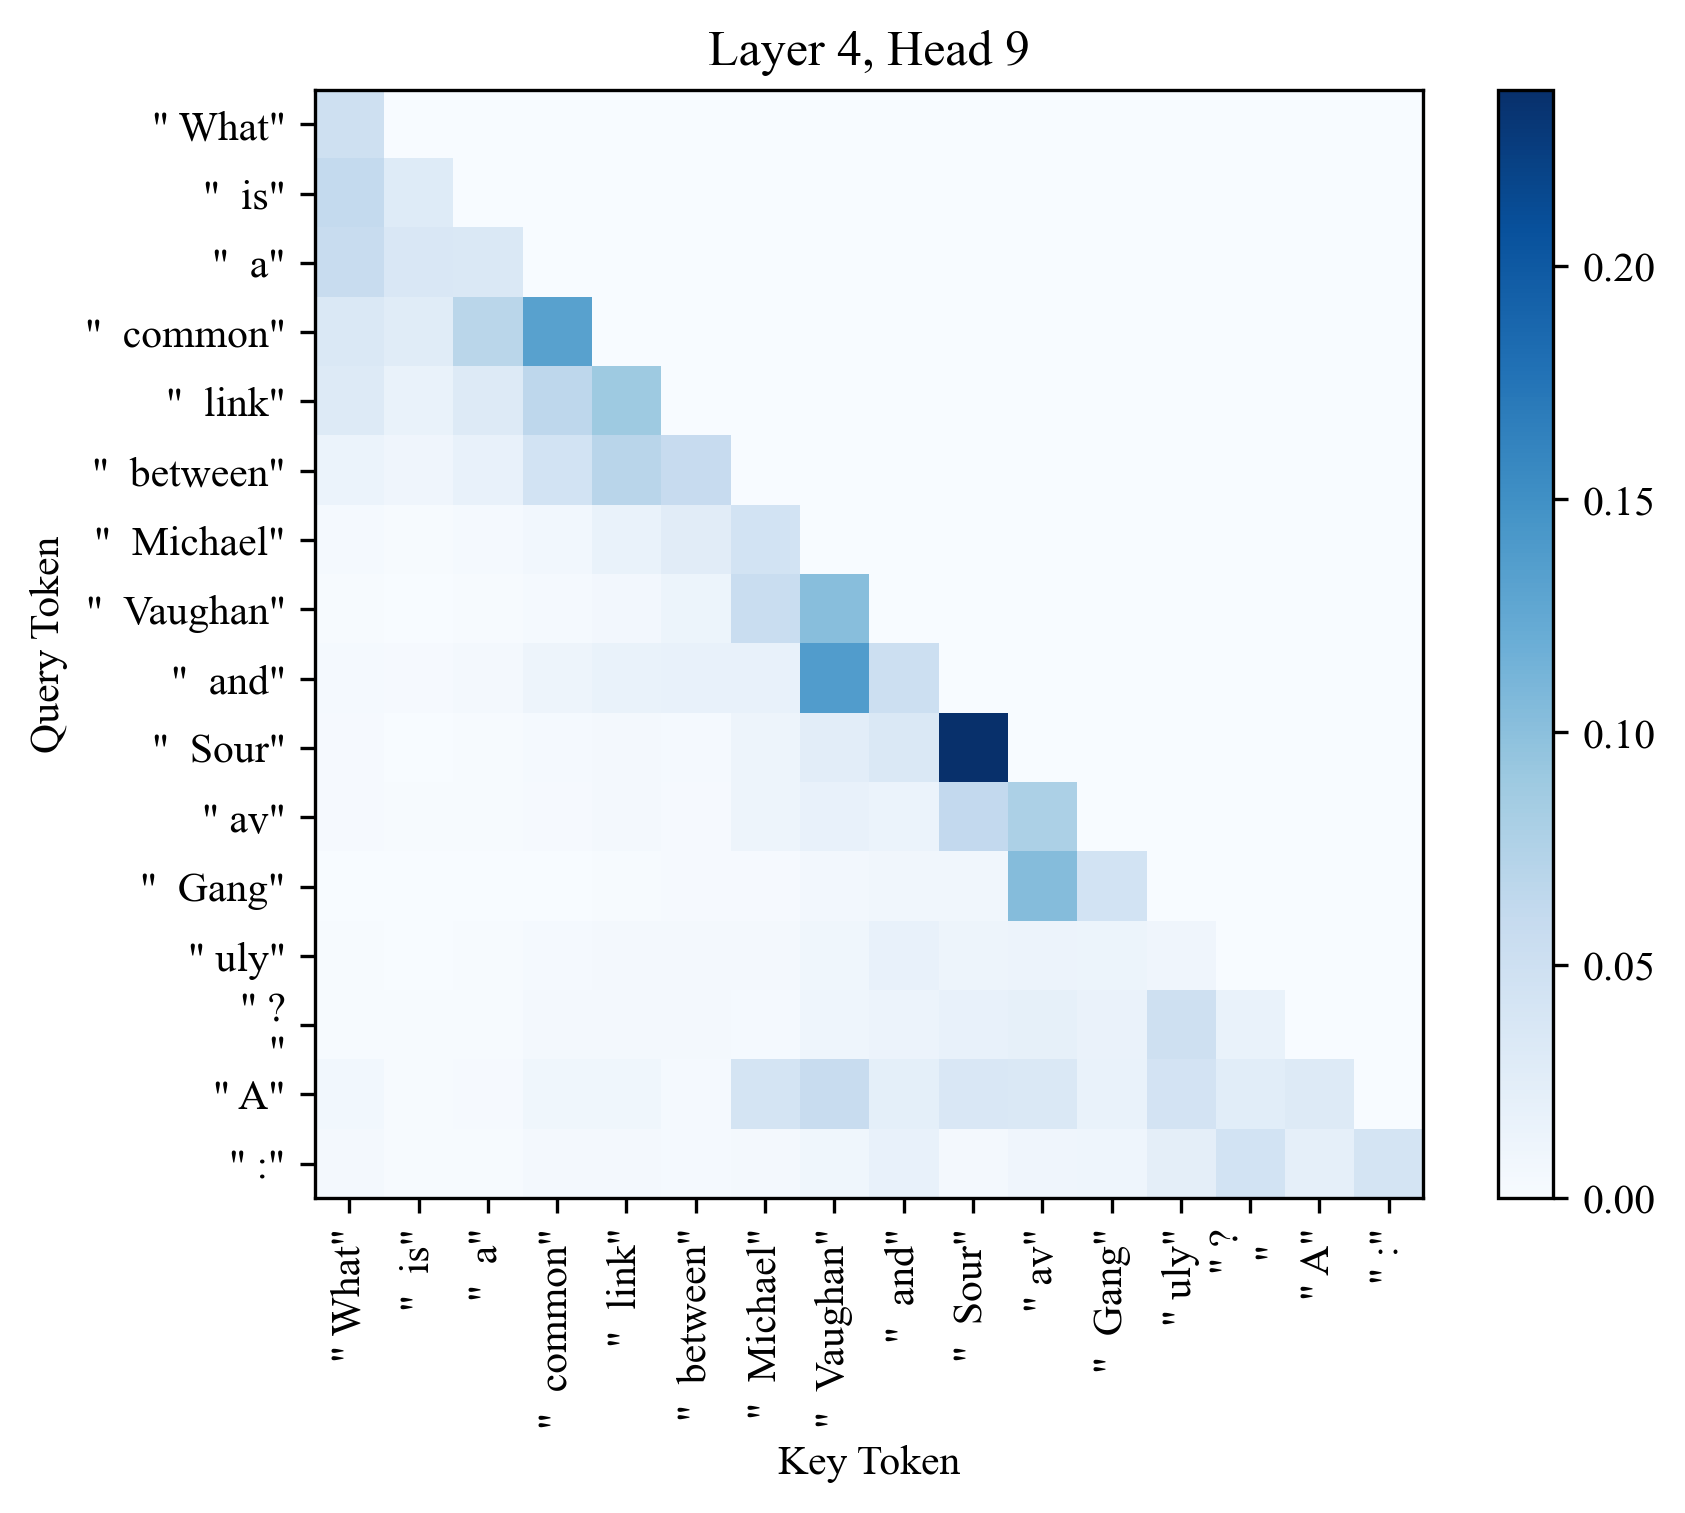

Layer 4, Head 10


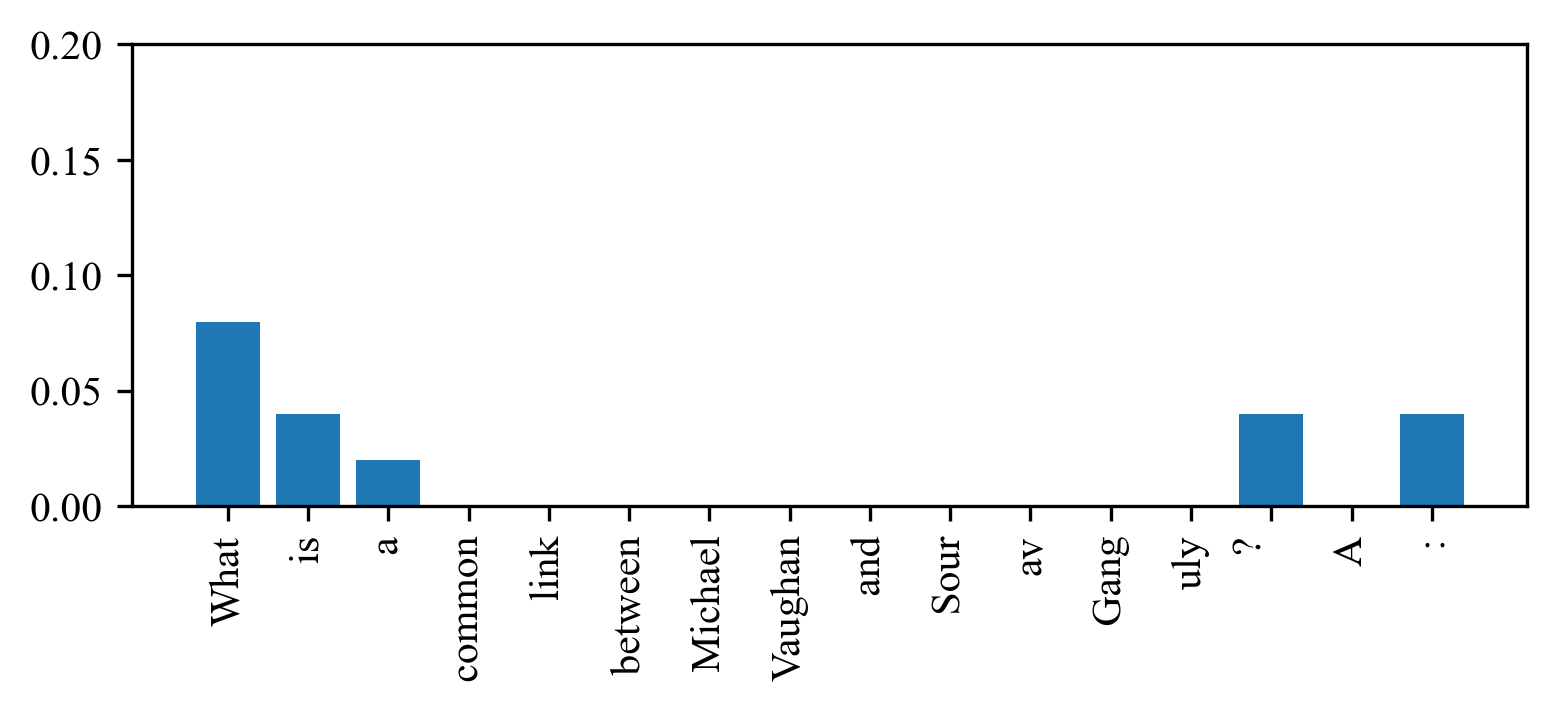

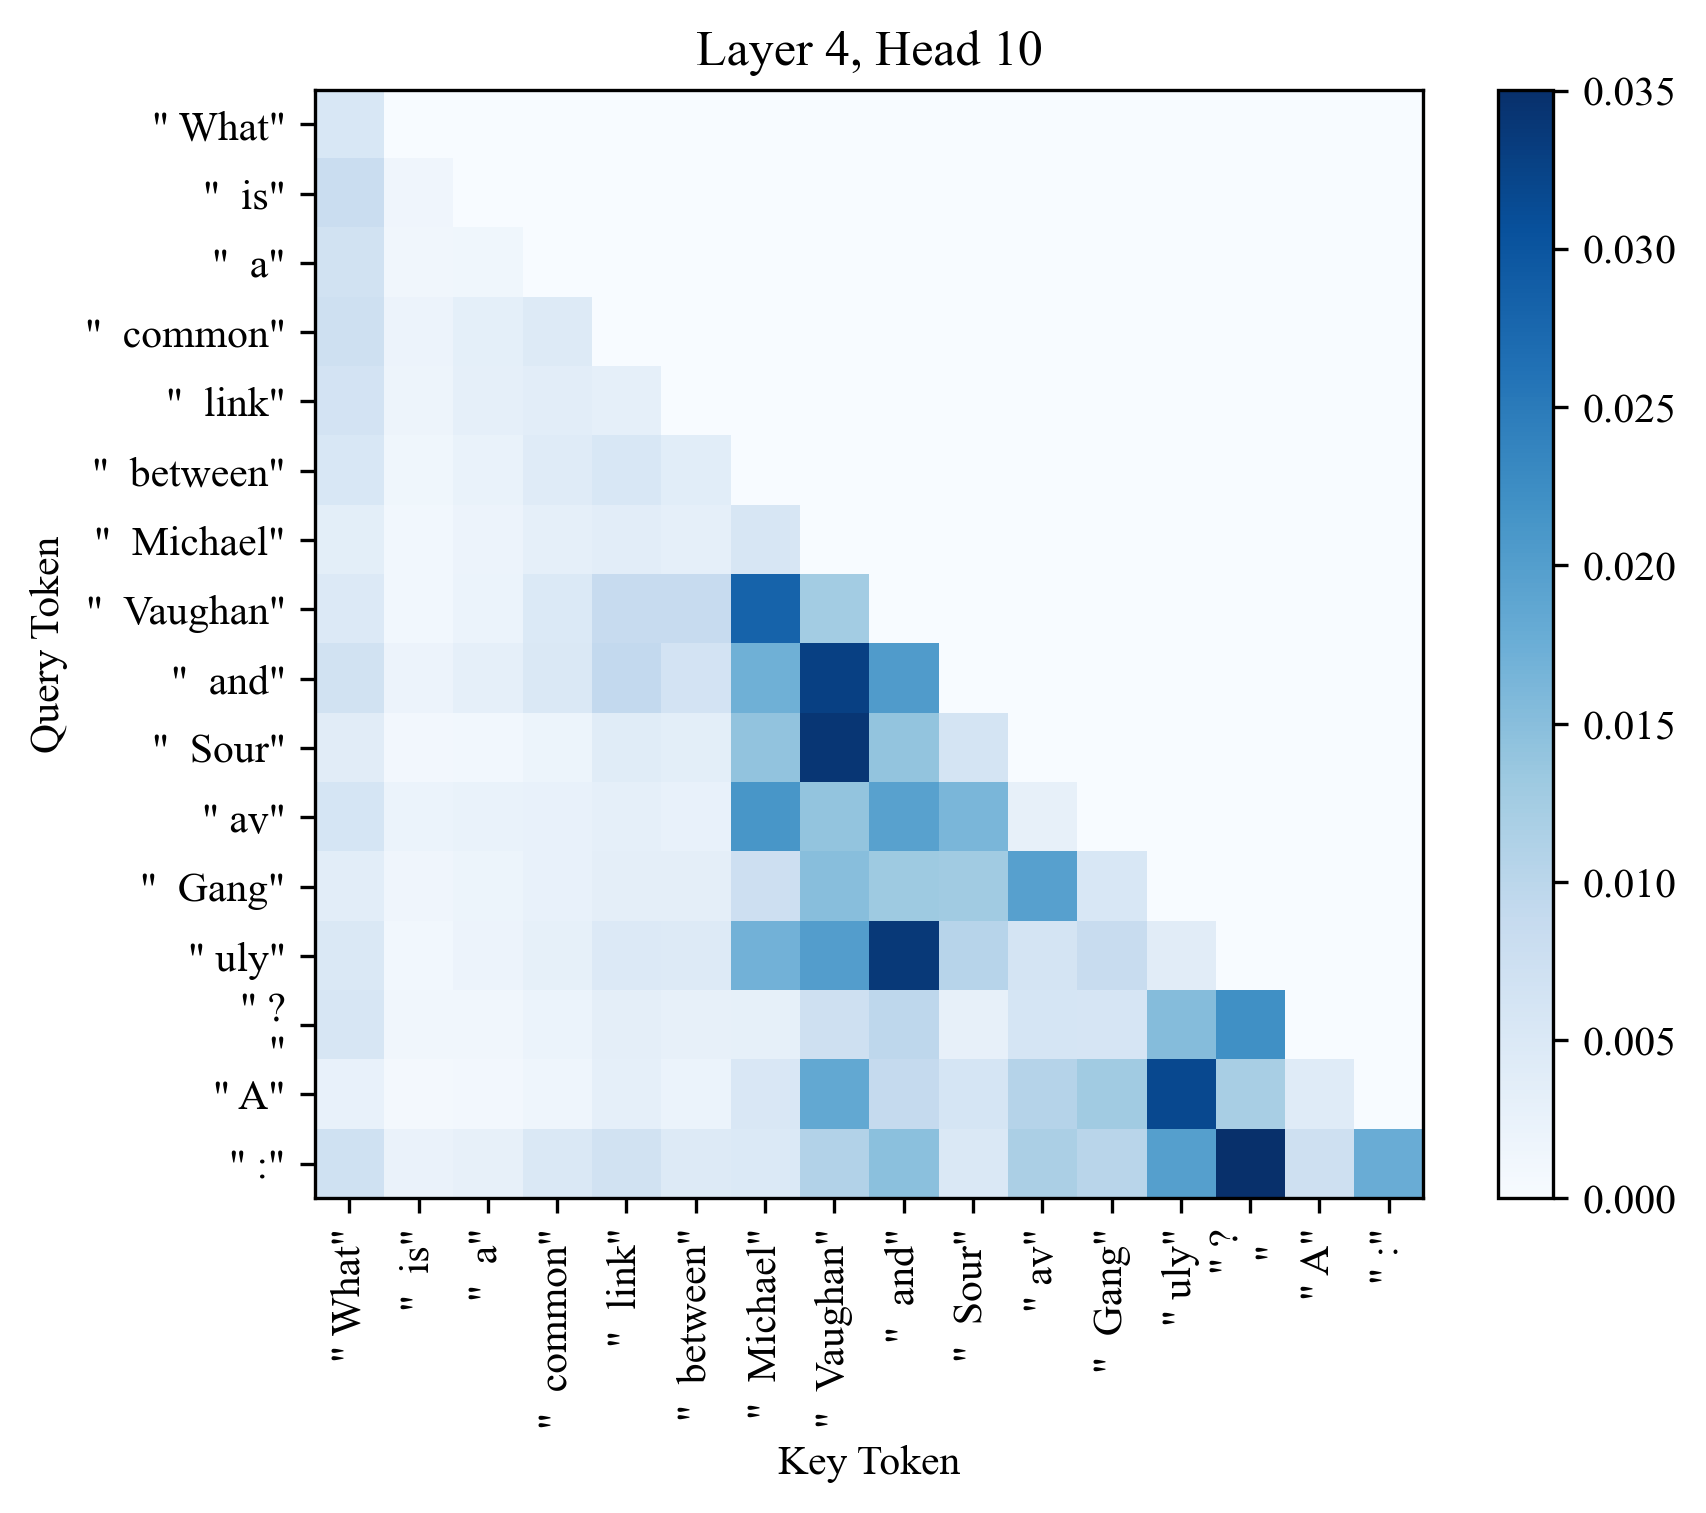

Layer 2, Head 22


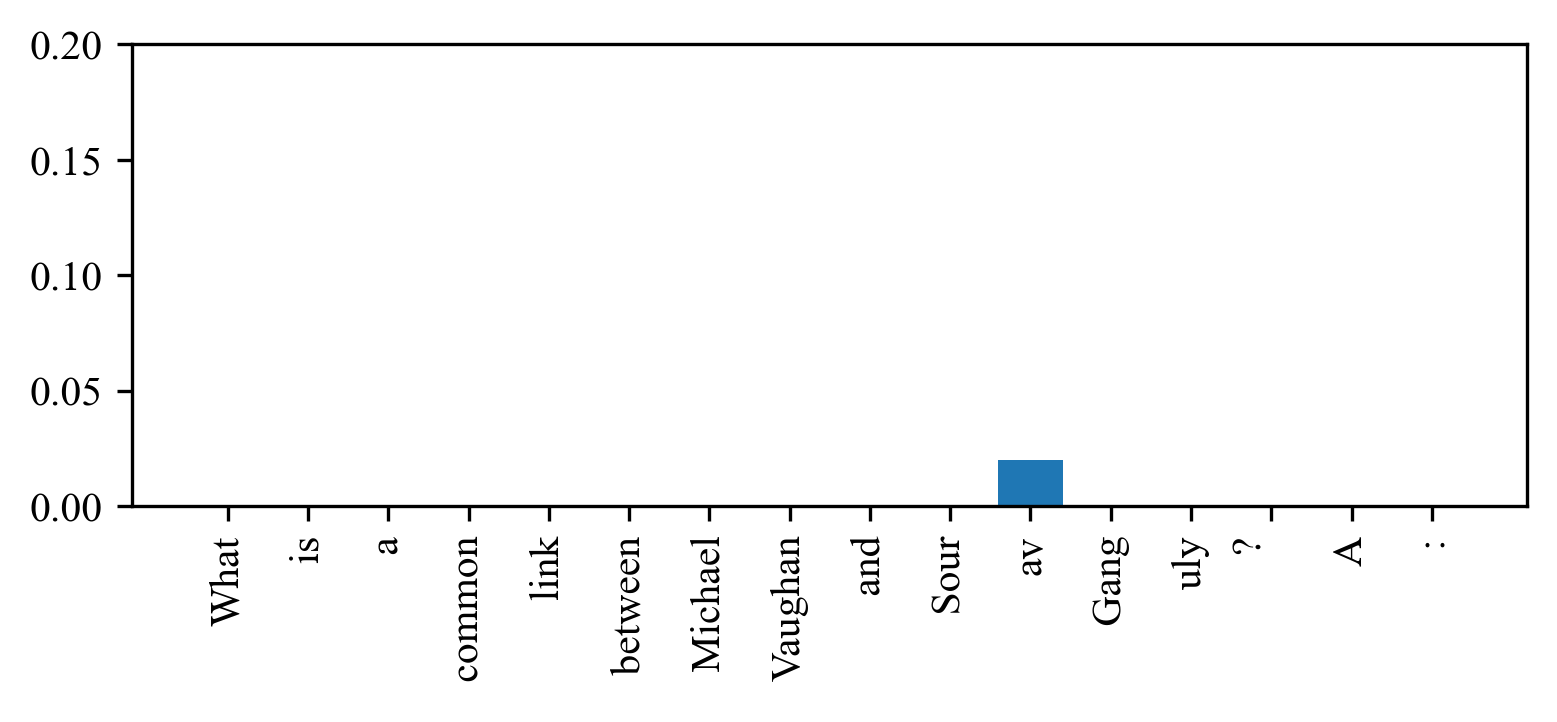

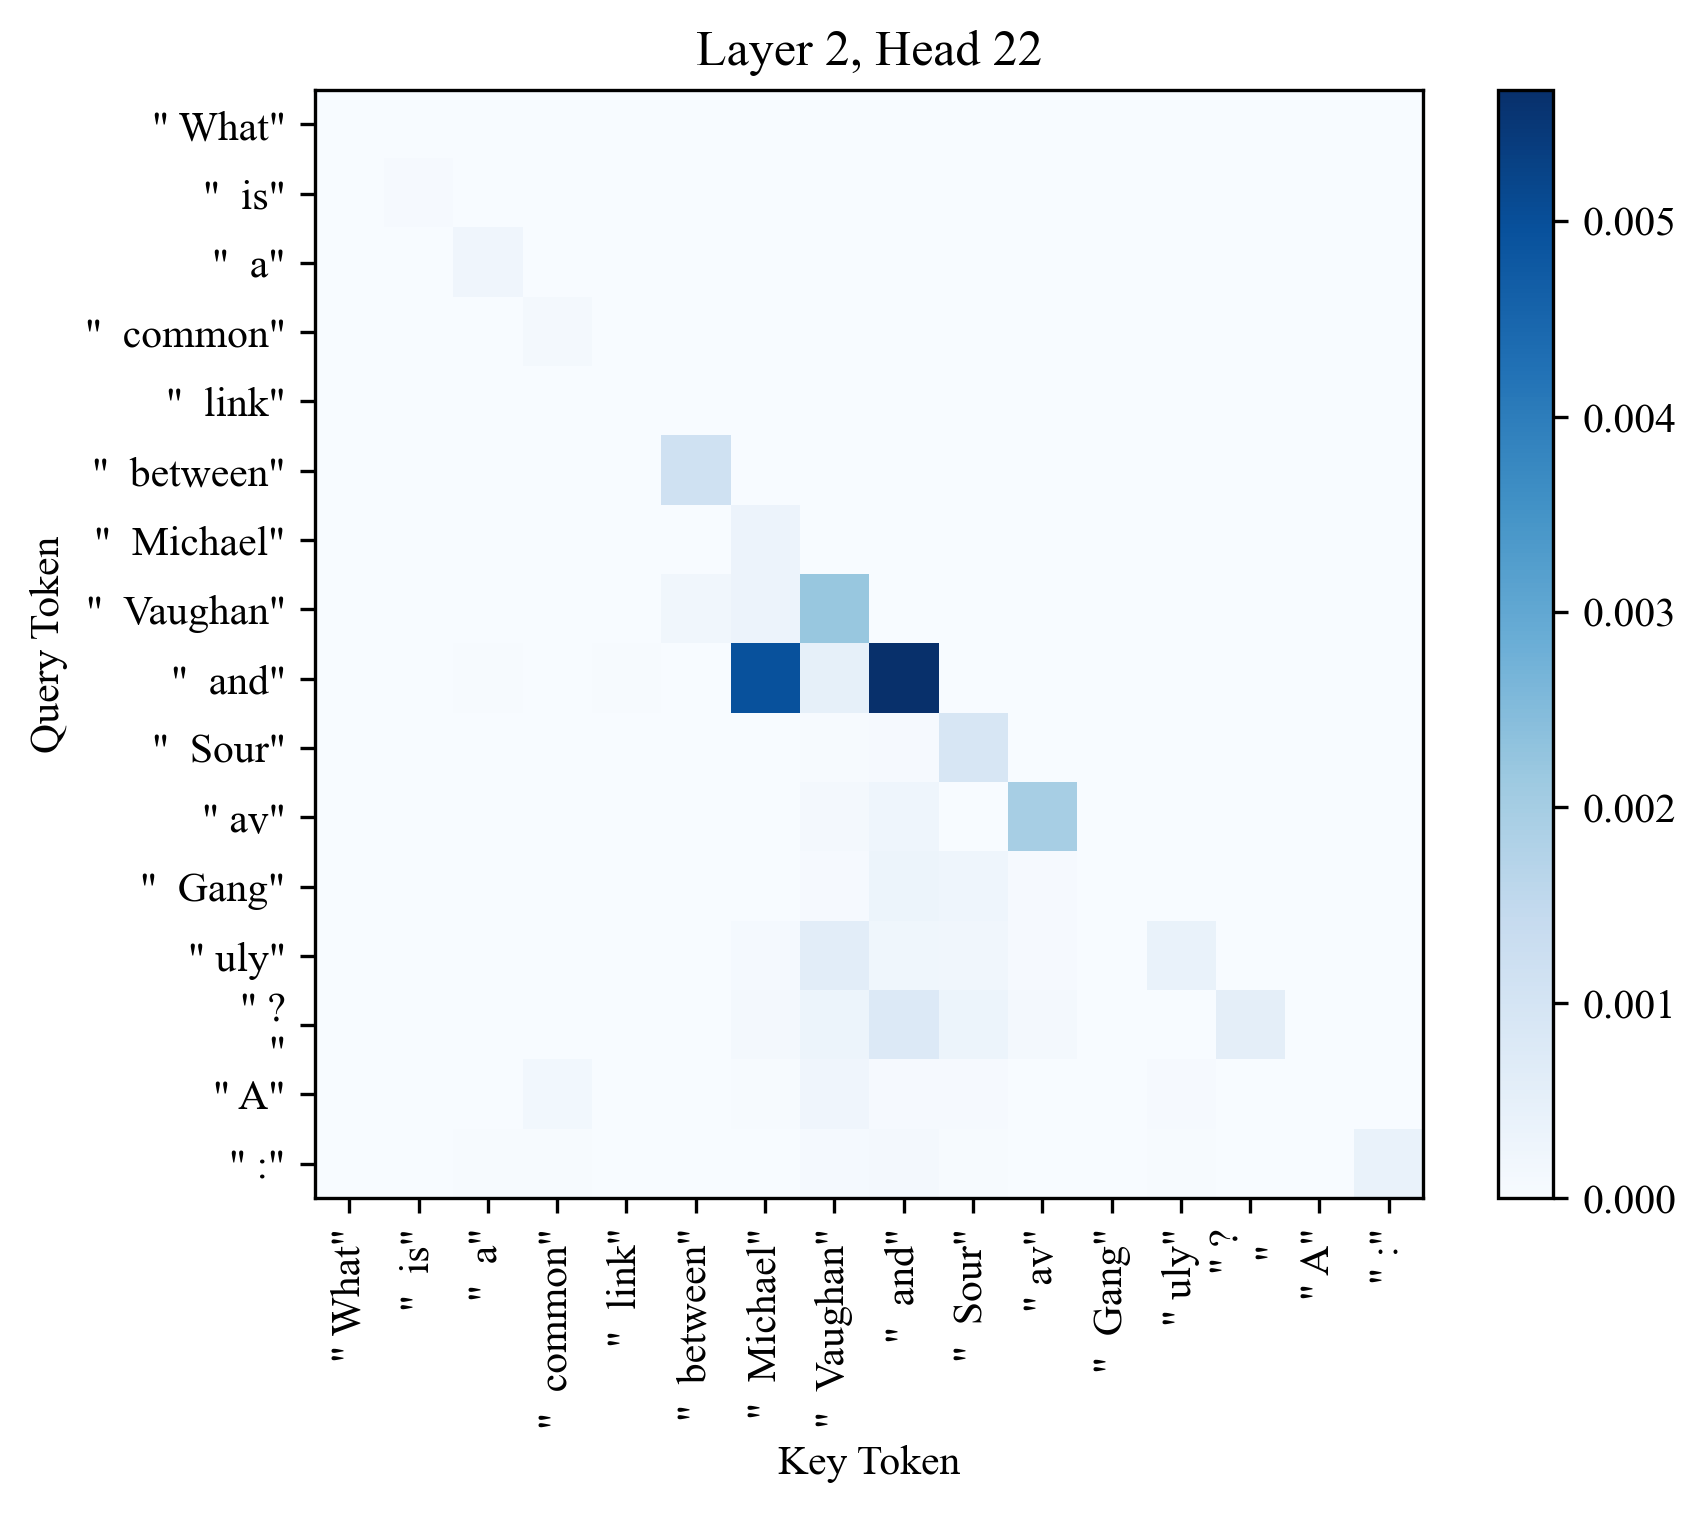

Layer 16, Head 29


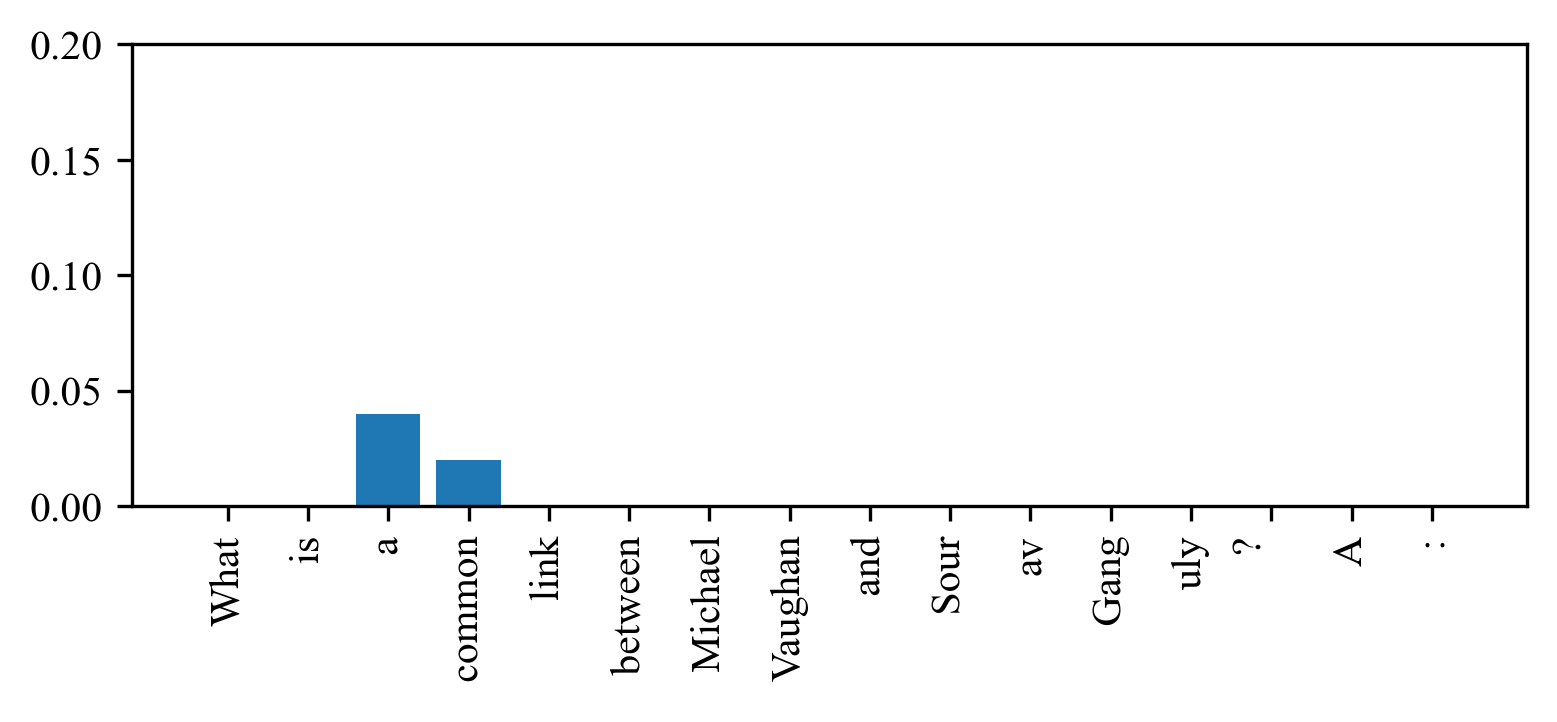

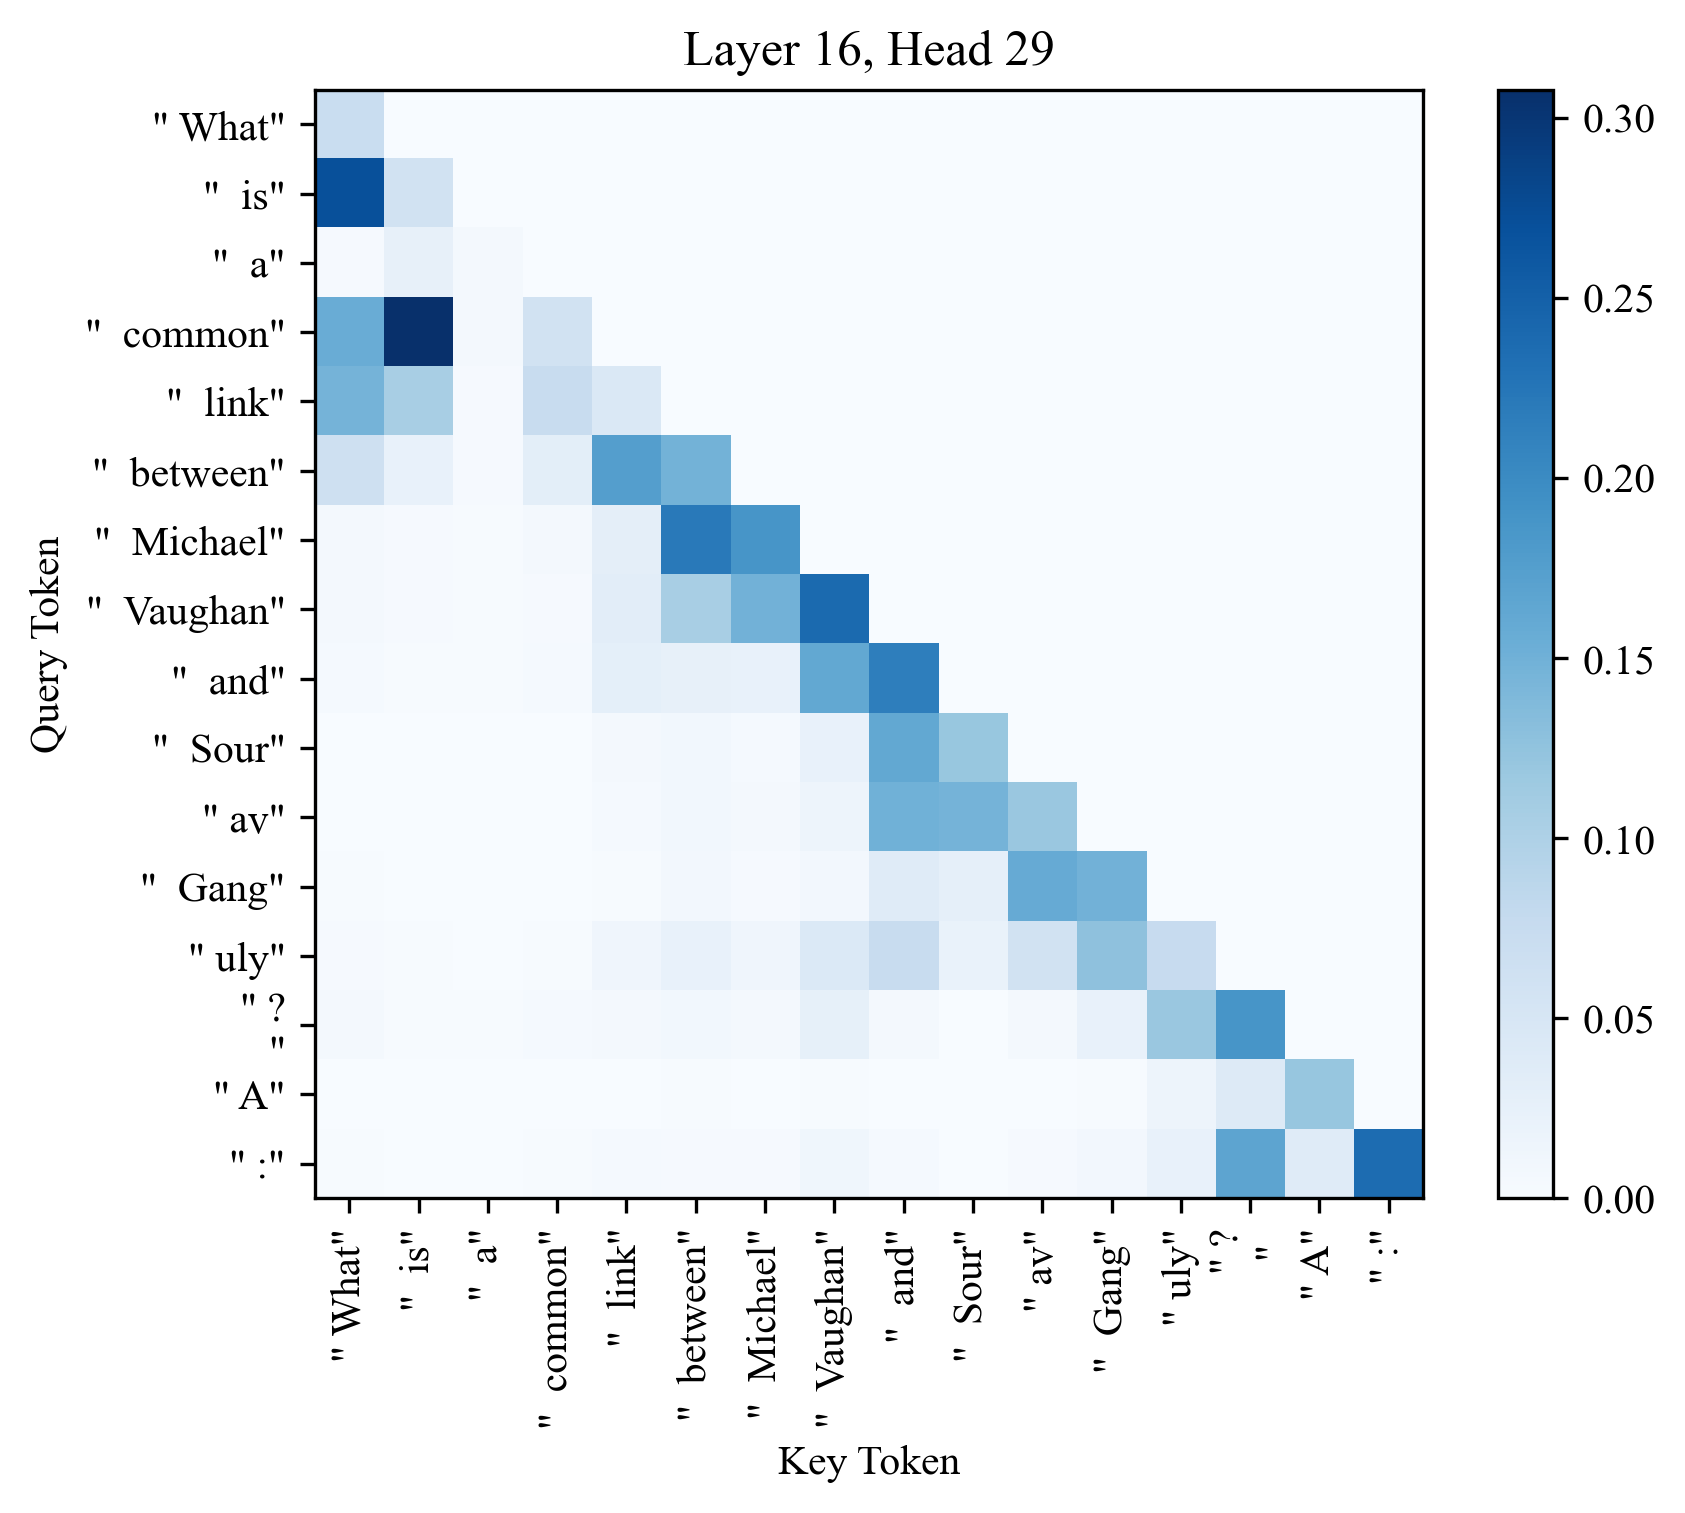

In [ ]:
from src.plotting import visualize_attn_matrix
from src.functional import logit_lens

for l in important_heads:   
    for h in important_heads[l]:
        print(f"Layer {l}, Head {h}")
        contributions = cache_attn_contributions[l][h].squeeze()

        plot_attribution_rates(contributions)
        visualize_attn_matrix(
            attn_matrix=cache_attn_matrices[l][h].squeeze().cpu().detach().numpy(),
            tokens = [mt.tokenizer.decode(t) for t in inputs["input_ids"][0]],
            remove_eos=mt.tokenizer.bos_token,
            savepdf=f"figures/att_mat_{l}_{h}.pdf",
            start_idx=nd,
            title=f"Layer {l}, Head {h}"
        )